In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './../scripts')

In [2]:
import pickle
import numpy as np
from scipy.interpolate import interp1d,RegularGridInterpolator
from scipy.optimize import least_squares
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.figure import figaspect
import time

import base_network as base_network
import ring_network as ring_network
import spat_ori_network as network
import sim_util as su
import ricciardi as ric
import integrate as integ

def imshowbar(fig,ax,A,**kwargs):
    imsh = ax.imshow(A,**kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(imsh, cax=cax, orientation='vertical')
    return cbar

# Load Sim and Dmft Results

In [26]:
sim_all_base_means = np.zeros((6))
sim_all_base_stds = np.zeros((6))
sim_all_opto_means = np.zeros((6))
sim_all_opto_stds = np.zeros((6))
sim_all_diff_means = np.zeros((6))
sim_all_diff_stds = np.zeros((6))
sim_all_norm_covs = np.zeros((6))
sim_vsm_base_means = np.zeros((6))
sim_vsm_base_stds = np.zeros((6))
sim_vsm_opto_means = np.zeros((6))
sim_vsm_opto_stds = np.zeros((6))
sim_vsm_diff_means = np.zeros((6))
sim_vsm_diff_stds = np.zeros((6))
sim_vsm_norm_covs = np.zeros((6))
sim_osm_diff_means = np.zeros((6))
sim_vsm_bals = np.zeros((6))
sim_vsm_oves = np.zeros((6))
sim_μrEs = np.zeros((6,3,20))
sim_μrIs = np.zeros((6,3,20))
sim_ΣrEs = np.zeros((6,4,20))
sim_ΣrIs = np.zeros((6,4,20))
sim_preds = np.zeros((6,6,20))
sim_Lexps = np.zeros((6,2))
sim_timeouts = np.zeros((6,2))

for c_idx in range(6):
    try:
        with open('./../results/best_fit_1s_id_None_c_{:d}'.format(c_idx)+'.pkl','rb') as\
                handle:
            res_dict = pickle.load(handle)

        sim_all_base_means[c_idx] = res_dict['all_base_means']
        sim_all_base_stds[c_idx] = res_dict['all_base_stds']
        sim_all_opto_means[c_idx] = res_dict['all_opto_means']
        sim_all_opto_stds[c_idx] = res_dict['all_opto_stds']
        sim_all_diff_means[c_idx] = res_dict['all_diff_means']
        sim_all_diff_stds[c_idx] = res_dict['all_diff_stds']
        sim_all_norm_covs[c_idx] = res_dict['all_norm_covs']
        sim_vsm_base_means[c_idx] = res_dict['vsm_base_means']
        sim_vsm_base_stds[c_idx] = res_dict['vsm_base_stds']
        sim_vsm_opto_means[c_idx] = res_dict['vsm_opto_means']
        sim_vsm_opto_stds[c_idx] = res_dict['vsm_opto_stds']
        sim_vsm_diff_means[c_idx] = res_dict['vsm_diff_means']
        sim_vsm_diff_stds[c_idx] = res_dict['vsm_diff_stds']
        sim_vsm_norm_covs[c_idx] = res_dict['vsm_norm_covs']
        sim_osm_diff_means[c_idx] = res_dict['osm_diff_means']
        sim_vsm_bals[c_idx] = res_dict['vsm_bals']
        sim_vsm_oves[c_idx] = res_dict['vsm_oves']
        sim_μrEs[c_idx] = np.mean(res_dict['μrEs'],0)
        sim_μrIs[c_idx] = np.mean(res_dict['μrIs'],0)
        sim_ΣrEs[c_idx] = np.mean(res_dict['ΣrEs'],0)
        sim_ΣrIs[c_idx] = np.mean(res_dict['ΣrIs'],0)
        sim_Lexps[c_idx] = np.median(res_dict['Lexps'],-2)
        sim_timeouts[c_idx] = np.sum(res_dict['timeouts'],-2)

    except:
        sim_all_base_means[c_idx] = np.nan
        sim_all_base_stds[c_idx] = np.nan
        sim_all_opto_means[c_idx] = np.nan
        sim_all_opto_stds[c_idx] = np.nan
        sim_all_diff_means[c_idx] = np.nan
        sim_all_diff_stds[c_idx] = np.nan
        sim_all_norm_covs[c_idx] = np.nan
        sim_vsm_base_means[c_idx] = np.nan
        sim_vsm_base_stds[c_idx] = np.nan
        sim_vsm_opto_means[c_idx] = np.nan
        sim_vsm_opto_stds[c_idx] = np.nan
        sim_vsm_diff_means[c_idx] = np.nan
        sim_vsm_diff_stds[c_idx] = np.nan
        sim_vsm_norm_covs[c_idx] = np.nan
        sim_osm_diff_means[c_idx] = np.nan
        sim_vsm_bals[c_idx] = np.nan
        sim_vsm_oves[c_idx] = np.nan
        sim_μrEs[c_idx] = np.nan
        sim_μrIs[c_idx] = np.nan
        sim_ΣrEs[c_idx] = np.nan
        sim_ΣrIs[c_idx] = np.nan
        sim_Lexps[c_idx] = np.nan
        sim_timeouts[c_idx] = 0
        
sim_preds = np.concatenate((
    sim_vsm_base_means[:,None],
    sim_vsm_opto_means[:,None],
    sim_vsm_base_stds[:,None],
    sim_vsm_opto_stds[:,None],
    sim_vsm_diff_stds[:,None],
    sim_vsm_norm_covs[:,None],
    sim_vsm_diff_means[:,None],
    sim_osm_diff_means[:,None],
),1)
        
sim_Epreds = np.concatenate((
    sim_μrEs[:,0:1,:],
    sim_μrEs[:,1:2,:],
    np.sqrt(sim_ΣrEs[:,0:1,:]),
    np.sqrt(sim_ΣrEs[:,1:2,:]),
    np.sqrt(sim_ΣrEs[:,2:3,:]),
    sim_ΣrEs[:,3:4,:]/sim_ΣrEs[:,2:3,:],
    sim_μrEs[:,2:3,:]
),1)

sim_Ipreds = np.concatenate((
    sim_μrIs[:,0:1,:],
    sim_μrIs[:,1:2,:],
    np.sqrt(sim_ΣrIs[:,0:1,:]),
    np.sqrt(sim_ΣrIs[:,1:2,:]),
    np.sqrt(sim_ΣrIs[:,2:3,:]),
    sim_ΣrIs[:,3:4,:]/sim_ΣrIs[:,2:3,:],
    sim_μrIs[:,2:3,:]
),1)

nEsamp = 400*50
nIsamp = 100*50

sim_Epred_errs = np.concatenate((
    np.sqrt(sim_ΣrEs[:,0:1,:]/nEsamp),
    np.sqrt(sim_ΣrEs[:,1:2,:]/nEsamp),
    np.sqrt(sim_ΣrEs[:,0:1,:]/(2*nEsamp)),
    np.sqrt(sim_ΣrEs[:,1:2,:]/(2*nEsamp)),
    np.sqrt(sim_ΣrEs[:,2:3,:]/(2*nEsamp)),
    np.abs(sim_ΣrEs[:,3:4,:]/sim_ΣrEs[:,2:3,:])/np.sqrt(nEsamp)
),1)

sim_Ipred_errs = np.concatenate((
    np.sqrt(sim_ΣrIs[:,0:1,:]/nIsamp),
    np.sqrt(sim_ΣrIs[:,1:2,:]/nIsamp),
    np.sqrt(sim_ΣrIs[:,0:1,:]/(2*nIsamp)),
    np.sqrt(sim_ΣrIs[:,1:2,:]/(2*nIsamp)),
    np.sqrt(sim_ΣrIs[:,2:3,:]/(2*nIsamp)),
    np.abs(sim_ΣrIs[:,3:4,:]/sim_ΣrIs[:,2:3,:])/np.sqrt(nIsamp)
),1)

In [27]:
dmft_all_base_means = np.zeros((6))
dmft_all_base_stds = np.zeros((6))
dmft_all_opto_means = np.zeros((6))
dmft_all_opto_stds = np.zeros((6))
dmft_all_diff_means = np.zeros((6))
dmft_all_diff_stds = np.zeros((6))
dmft_all_norm_covs = np.zeros((6))
dmft_vsm_base_means = np.zeros((6))
dmft_vsm_base_stds = np.zeros((6))
dmft_vsm_opto_means = np.zeros((6))
dmft_vsm_opto_stds = np.zeros((6))
dmft_vsm_diff_means = np.zeros((6))
dmft_vsm_diff_stds = np.zeros((6))
dmft_vsm_norm_covs = np.zeros((6))
dmft_osm_diff_means = np.zeros((6))
# dmft_vsm_bals = np.zeros((6))
# dmft_vsm_oves = np.zeros((6))
dmft_μrEs = np.zeros((6,3,20))
dmft_μrIs = np.zeros((6,3,20))
dmft_ΣrEs = np.zeros((6,4,20))
dmft_ΣrIs = np.zeros((6,4,20))
# dmft_Lexps = np.zeros((6,2))
# dmft_timeouts = np.zeros((6,2))

for c_idx in range(6):
    try:
        with open('./../results/dmft_best_fit_id_None_c_{:d}'.format(c_idx)+'.pkl','rb') as\
                handle:
            res_dict = pickle.load(handle)
        # print(res_dict['convs'])

        dmft_all_base_means[c_idx] = res_dict['all_base_means']
        dmft_all_base_stds[c_idx] = res_dict['all_base_stds']
        dmft_all_opto_means[c_idx] = res_dict['all_opto_means']
        dmft_all_opto_stds[c_idx] = res_dict['all_opto_stds']
        dmft_all_diff_means[c_idx] = res_dict['all_diff_means']
        dmft_all_diff_stds[c_idx] = res_dict['all_diff_stds']
        dmft_all_norm_covs[c_idx] = res_dict['all_norm_covs']
        dmft_vsm_base_means[c_idx] = res_dict['vsm_base_means']
        dmft_vsm_base_stds[c_idx] = res_dict['vsm_base_stds']
        dmft_vsm_opto_means[c_idx] = res_dict['vsm_opto_means']
        dmft_vsm_opto_stds[c_idx] = res_dict['vsm_opto_stds']
        dmft_vsm_diff_means[c_idx] = res_dict['vsm_diff_means']
        dmft_vsm_diff_stds[c_idx] = res_dict['vsm_diff_stds']
        dmft_vsm_norm_covs[c_idx] = res_dict['vsm_norm_covs']
        dmft_osm_diff_means[c_idx] = res_dict['osm_diff_means']
        # dmft_vsm_bals[c_idx] = res_dict['vsm_bals']
        # dmft_vsm_oves[c_idx] = res_dict['vsm_oves']
        dmft_μrEs[c_idx] = res_dict['μrEs']
        dmft_μrIs[c_idx] = res_dict['μrIs']
        dmft_ΣrEs[c_idx] = res_dict['ΣrEs']
        dmft_ΣrIs[c_idx] = res_dict['ΣrIs']
        # dmft_Lexps[c_idx] = np.median(res_dict['Lexps'],-2)
        # dmft_timeouts[c_idx] = np.sum(res_dict['timeouts'],-2)

    except:
        dmft_all_base_means[c_idx] = np.nan
        dmft_all_base_stds[c_idx] = np.nan
        dmft_all_opto_means[c_idx] = np.nan
        dmft_all_opto_stds[c_idx] = np.nan
        dmft_all_diff_means[c_idx] = np.nan
        dmft_all_diff_stds[c_idx] = np.nan
        dmft_all_norm_covs[c_idx] = np.nan
        dmft_vsm_base_means[c_idx] = np.nan
        dmft_vsm_base_stds[c_idx] = np.nan
        dmft_vsm_opto_means[c_idx] = np.nan
        dmft_vsm_opto_stds[c_idx] = np.nan
        dmft_vsm_diff_means[c_idx] = np.nan
        dmft_vsm_diff_stds[c_idx] = np.nan
        dmft_vsm_norm_covs[c_idx] = np.nan
        dmft_osm_diff_means[c_idx] = np.nan
        # dmft_vsm_bals[c_idx] = np.nan
        # dmft_vsm_oves[c_idx] = np.nan
        dmft_μrEs[c_idx] = np.nan
        dmft_μrIs[c_idx] = np.nan
        dmft_ΣrEs[c_idx] = np.nan
        dmft_ΣrIs[c_idx] = np.nan
        # dmft_Lexps[c_idx] = np.nan
        # dmft_timeouts[c_idx] = 0
        
dmft_preds = np.concatenate((
    dmft_vsm_base_means[:,None],
    dmft_vsm_opto_means[:,None],
    dmft_vsm_base_stds[:,None],
    dmft_vsm_opto_stds[:,None],
    dmft_vsm_diff_stds[:,None],
    dmft_vsm_norm_covs[:,None],
    dmft_vsm_diff_means[:,None],
    dmft_osm_diff_means[:,None],
),1)
        
dmft_Epreds = np.concatenate((
    dmft_μrEs[:,0:1,:],
    dmft_μrEs[:,1:2,:],
    np.sqrt(dmft_ΣrEs[:,0:1,:]),
    np.sqrt(dmft_ΣrEs[:,1:2,:]),
    np.sqrt(dmft_ΣrEs[:,2:3,:]),
    dmft_ΣrEs[:,3:4,:]/dmft_ΣrEs[:,2:3,:],
    dmft_μrEs[:,2:3,:]
),1)

dmft_Ipreds = np.concatenate((
    dmft_μrIs[:,0:1,:],
    dmft_μrIs[:,1:2,:],
    np.sqrt(dmft_ΣrIs[:,0:1,:]),
    np.sqrt(dmft_ΣrIs[:,1:2,:]),
    np.sqrt(dmft_ΣrIs[:,2:3,:]),
    dmft_ΣrIs[:,3:4,:]/dmft_ΣrIs[:,2:3,:],
    dmft_μrIs[:,2:3,:]
),1)

In [28]:
rX_osm_diff_means = np.zeros((7,7))
rX_vsm_diff_means = np.zeros((7,7))
rX_vsm_diff_stds = np.zeros((7,7))
rX_vsm_std_diffs = np.zeros((7,7))
rX_vsm_norm_covs = np.zeros((7,7))

J_osm_diff_means = np.zeros((7,7))
J_vsm_diff_means = np.zeros((7,7))
J_vsm_diff_stds = np.zeros((7,7))
J_vsm_std_diffs = np.zeros((7,7))
J_vsm_norm_covs = np.zeros((7,7))

for sidx in range(7):
    for ridx in range(7):
        try:
            with open('./../results/vary_id_None_struct_{:d}_rX_{:d}'.format(sidx,ridx)+'.pkl', 'rb') as\
                    handle:
                res_dict = pickle.load(handle)
            rX_osm_diff_means[sidx,ridx] = res_dict['osm_diff_means']
            rX_vsm_diff_means[sidx,ridx] = res_dict['vsm_diff_means']
            rX_vsm_diff_stds[sidx,ridx] = res_dict['vsm_diff_stds']
            # rX_vsm_std_diffs[sidx,ridx] = res_dict['vsm_opto_stds']-res_dict['vsm_base_stds']
            rX_vsm_std_diffs[sidx,ridx] = (res_dict['vsm_opto_stds']**2-res_dict['vsm_base_stds']**2)/res_dict['vsm_diff_stds']**2
            rX_vsm_norm_covs[sidx,ridx] = res_dict['vsm_norm_covs']
        except:
            rX_osm_diff_means[sidx,ridx] = np.nan
            rX_vsm_diff_means[sidx,ridx] = np.nan
            rX_vsm_diff_stds[sidx,ridx] = np.nan
            rX_vsm_std_diffs[sidx,ridx] = np.nan
            rX_vsm_norm_covs[sidx,ridx] = np.nan
            

for sidx in range(7):
    for jidx in range(7):
        try:
            with open('./../results/vary_id_None_struct_{:d}_J_{:d}'.format(sidx,jidx)+'.pkl', 'rb') as\
                    handle:
                res_dict = pickle.load(handle)
            J_osm_diff_means[sidx,jidx] = res_dict['osm_diff_means']
            J_vsm_diff_means[sidx,jidx] = res_dict['vsm_diff_means']
            J_vsm_diff_stds[sidx,jidx] = res_dict['vsm_diff_stds']
            J_vsm_std_diffs[sidx,jidx] = (res_dict['vsm_opto_stds']**2-res_dict['vsm_base_stds']**2)/res_dict['vsm_diff_stds']**2
            J_vsm_norm_covs[sidx,jidx] = res_dict['vsm_norm_covs']
        except:
            J_osm_diff_means[sidx,jidx] = np.nan
            J_vsm_diff_means[sidx,jidx] = np.nan
            J_vsm_diff_stds[sidx,jidx] = np.nan
            J_vsm_std_diffs[sidx,jidx] = np.nan
            J_vsm_norm_covs[sidx,jidx] = np.nan

In [29]:
sim_norm_μrEs = np.zeros((6,3,20))
sim_norm_μrIs = np.zeros((6,3,20))
sim_norm_ΣrEs = np.zeros((6,4,20))
sim_norm_ΣrIs = np.zeros((6,4,20))

for c_idx in range(6):
    try:
        with open('./../results/opto_norm_id_None_base_1.0_c1_{:d}_c2_{:d}'.format(c_idx,c_idx)+'.pkl','rb') as\
                handle:
            res_dict = pickle.load(handle)

        sim_norm_μrEs[c_idx] = np.mean(res_dict['μrEs'],0)
        sim_norm_μrIs[c_idx] = np.mean(res_dict['μrIs'],0)
        sim_norm_ΣrEs[c_idx] = np.mean(res_dict['ΣrEs'],0)
        sim_norm_ΣrIs[c_idx] = np.mean(res_dict['ΣrIs'],0)

    except:
        sim_norm_μrEs[c_idx] = np.nan
        sim_norm_μrIs[c_idx] = np.nan
        sim_norm_ΣrEs[c_idx] = np.nan
        sim_norm_ΣrIs[c_idx] = np.nan

In [30]:
dmft_norm_μrEs = np.zeros((6,2,20))
dmft_norm_μrIs = np.zeros((6,2,20))
dmft_norm_ΣrEs = np.zeros((6,2,20))
dmft_norm_ΣrIs = np.zeros((6,2,20))

for c_idx in range(6):
    try:
        with open('./../results/dmft_opto_norm_id_None_c_{:d}'.format(c_idx)+'.pkl','rb') as\
                handle:
            res_dict = pickle.load(handle)

        dmft_norm_μrEs[c_idx] = res_dict['μrEs']
        dmft_norm_μrIs[c_idx] = res_dict['μrIs']
        dmft_norm_ΣrEs[c_idx] = res_dict['ΣrEs']
        dmft_norm_ΣrIs[c_idx] = res_dict['ΣrIs']

    except:
        dmft_norm_μrEs[c_idx] = np.nan
        dmft_norm_μrIs[c_idx] = np.nan
        dmft_norm_ΣrEs[c_idx] = np.nan
        dmft_norm_ΣrIs[c_idx] = np.nan

# Plot Response Statistics vs Contrast & Feature

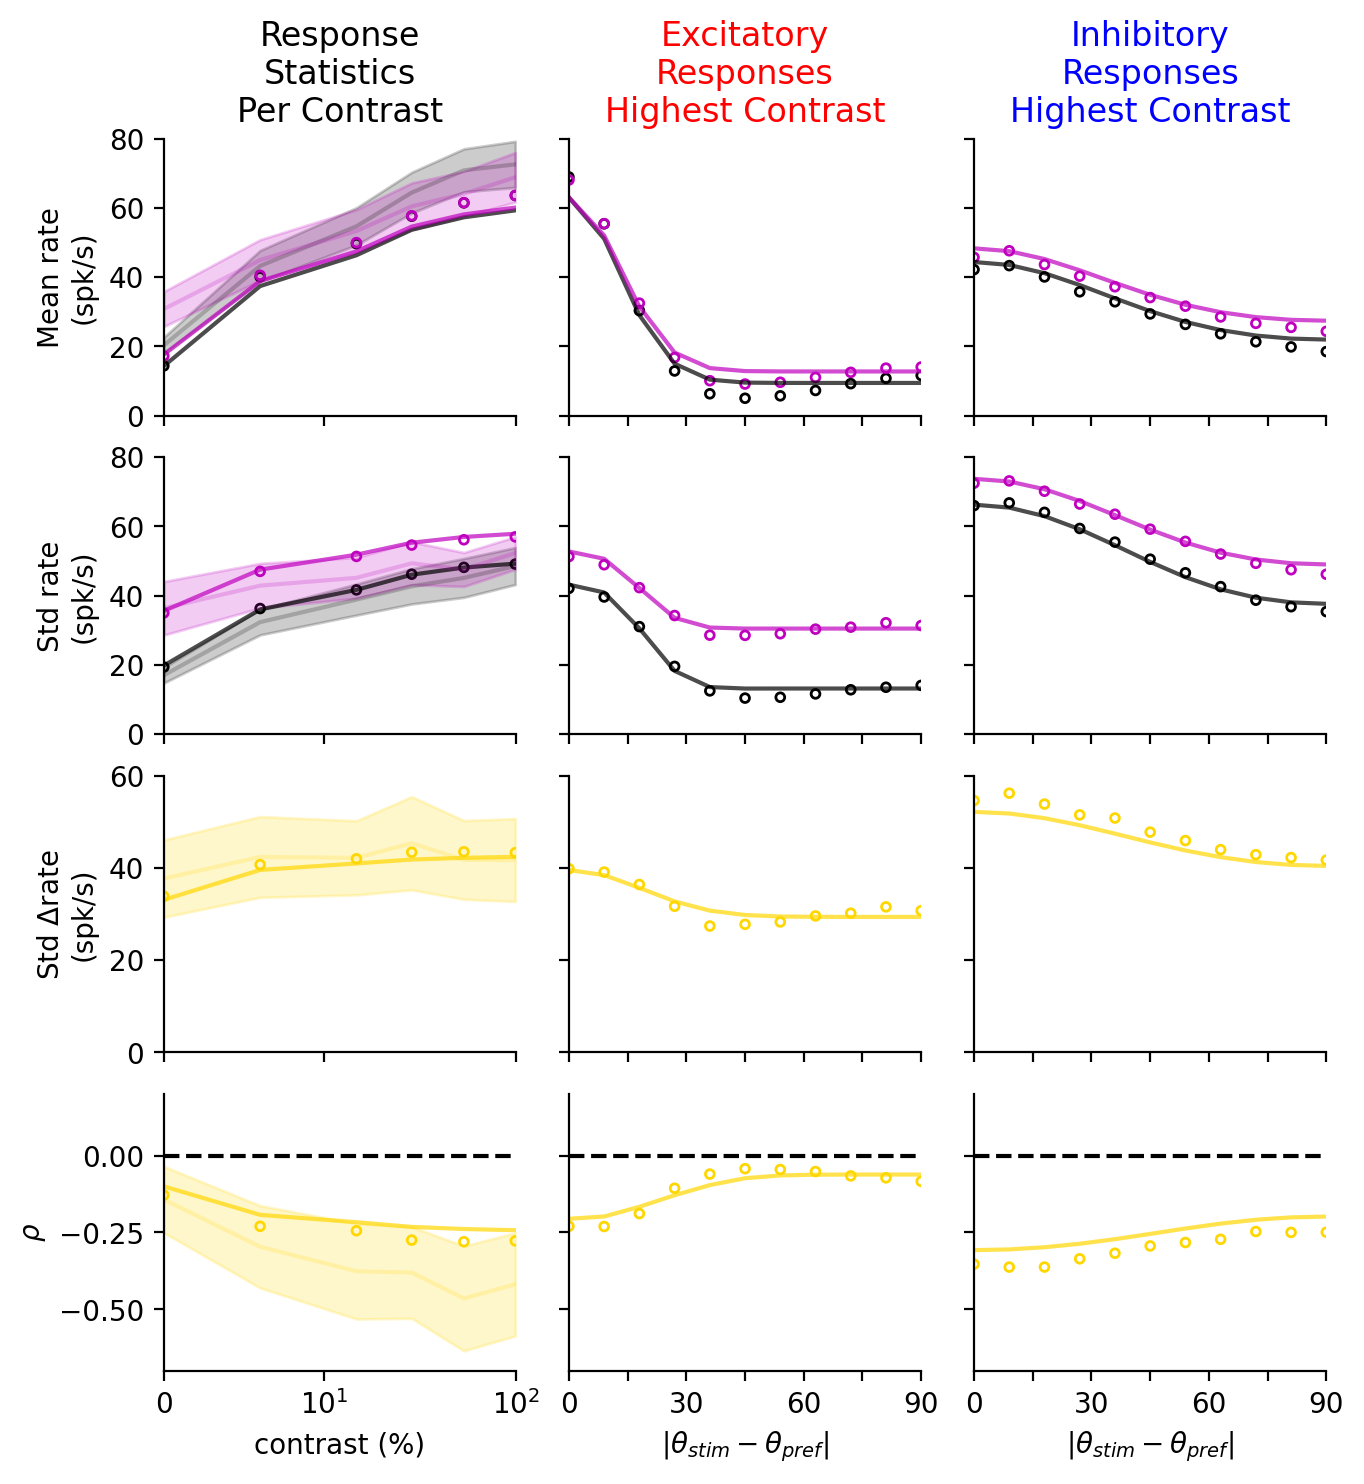

In [430]:
with open('./data_moments'+'.pkl', 'rb') as handle:
    data_preds = np.transpose(pickle.load(handle)[1],(1,0,2))
with open('./data_contrasts'+'.pkl', 'rb') as handle:
    cons = pickle.load(handle)[1]
    
nori = 20

oris = np.arange(nori//2+1) * 90/(nori/2)
def abs_ori(A):
    return 0.5*(A[:nori//2+1] + np.concatenate((A[0:1],A[-1:nori//2-1:-1])))

cidx = 5

fig,axs = plt.subplots(4,3,figsize=(2.5*3,2*4),dpi=200,sharex='col',sharey='row')
fig.subplots_adjust(hspace=0.15,wspace=0.15)

axs[0,0].plot([-1],[-1],label=r'Data $\pm$ SEM')
axs[0,0].plot([-1],[-1],label='Simulation')
axs[0,0].plot([-1],[-1],label='Theory')
axs[0,0].plot(cons,data_preds[:,0,0],color='k',alpha=0.2,label='Vis Stim Only')
axs[0,0].fill_between(cons,data_preds[:,0,0]-data_preds[:,0,1],
    data_preds[:,0,0]+data_preds[:,0,1],color='k',alpha=0.2,label='Vis Stim Only')
axs[0,0].plot(cons,dmft_preds[:,0],c='k',ls='-',label='Vis Stim Only',alpha=0.7)
axs[0,0].scatter(cons,sim_preds[:,0],edgecolors='k',facecolors='none',marker='o',s=10,label='Vis Stim Only')
axs[0,0].plot(cons,data_preds[:,1,0],color='m',alpha=0.2)
axs[0,0].fill_between(cons,data_preds[:,1,0]-data_preds[:,1,1],
    data_preds[:,1,0]+data_preds[:,1,1],color='m',alpha=0.2)
axs[0,0].plot(cons,dmft_preds[:,1],c='m',ls='-',alpha=0.7)
axs[0,0].scatter(cons,sim_preds[:,1],edgecolors='m',facecolors='none',marker='o',s=10)

axs[1,0].plot(cons,data_preds[:,2,0],color='k',alpha=0.2)
axs[1,0].fill_between(cons,data_preds[:,2,0]-data_preds[:,2,1],
    data_preds[:,2,0]+data_preds[:,2,1],color='k',alpha=0.2)
axs[1,0].plot(cons,dmft_preds[:,2],c='k',ls='-',alpha=0.7)
axs[1,0].scatter(cons,sim_preds[:,2],edgecolors='k',facecolors='none',marker='o',s=10)
axs[1,0].plot(cons,data_preds[:,3,0],color='m',alpha=0.2,label='Vis+Opto Stim')
axs[1,0].fill_between(cons,data_preds[:,3,0]-data_preds[:,3,1],
    data_preds[:,3,0]+data_preds[:,3,1],color='m',alpha=0.2,label='Vis+Opto Stim')
axs[1,0].plot(cons,dmft_preds[:,3],c='m',ls='-',label='Vis+Opto Stim',alpha=0.7)
axs[1,0].scatter(cons,sim_preds[:,3],edgecolors='m',facecolors='none',marker='o',s=10,label='Vis+Opto Stim')

axs[2,0].plot(cons,data_preds[:,4,0],color='gold',alpha=0.2,label=r'Opto Evoked $\Delta$Rate')
axs[2,0].fill_between(cons,data_preds[:,4,0]-data_preds[:,4,1],
    data_preds[:,4,0]+data_preds[:,4,1],color='gold',alpha=0.2,label=r'Opto Evoked $\Delta$Rate')
axs[2,0].plot(cons,dmft_preds[:,4],c='gold',ls='-',label=r'Opto Evoked $\Delta$Rate',alpha=0.7)
axs[2,0].scatter(cons,sim_preds[:,4],edgecolors='gold',facecolors='none',marker='o',s=10,label=r'Opto Evoked $\Delta$Rate')

axs[3,0].plot(cons,data_preds[:,5,0],color='gold',alpha=0.2)
axs[3,0].fill_between(cons,data_preds[:,5,0]-data_preds[:,5,1],
    data_preds[:,5,0]+data_preds[:,5,1],color='gold',alpha=0.2)
axs[3,0].plot(cons,dmft_preds[:,5],c='gold',ls='-',alpha=0.7)
axs[3,0].scatter(cons,sim_preds[:,5],edgecolors='gold',facecolors='none',marker='o',s=10)

axs[0,1].plot(oris,abs_ori(dmft_Epreds[cidx,0,:]),c='k',ls='-',alpha=0.7)
axs[0,1].scatter(oris,abs_ori(sim_Epreds[cidx,0,:]),#abs_ori(sim_Epred_errs[cidx,0,:]),
    edgecolors='k',facecolors='none',marker='o',s=10)
axs[0,1].plot(oris,abs_ori(dmft_Epreds[cidx,1,:]),c='m',ls='-',alpha=0.7)
axs[0,1].scatter(oris,abs_ori(sim_Epreds[cidx,1,:]),#abs_ori(sim_Epred_errs[cidx,1,:]),
    edgecolors='m',facecolors='none',marker='o',s=10)

axs[0,2].plot(oris,abs_ori(dmft_Ipreds[cidx,0,:]),c='k',ls='-',alpha=0.7)
axs[0,2].scatter(oris,abs_ori(sim_Ipreds[cidx,0,:]),#abs_ori(sim_Ipred_errs[cidx,0,:]),
    edgecolors='k',facecolors='none',marker='o',s=10)
axs[0,2].plot(oris,abs_ori(dmft_Ipreds[cidx,1,:]),c='m',ls='-',alpha=0.7)
axs[0,2].scatter(oris,abs_ori(sim_Ipreds[cidx,1,:]),#abs_ori(sim_Ipred_errs[cidx,1,:]),
    edgecolors='m',facecolors='none',marker='o',s=10)

axs[1,1].plot(oris,abs_ori(dmft_Epreds[cidx,2,:]),c='k',ls='-',alpha=0.7)
axs[1,1].scatter(oris,abs_ori(sim_Epreds[cidx,2,:]),#abs_ori(sim_Epred_errs[cidx,2,:]),
    edgecolors='k',facecolors='none',marker='o',s=10)
axs[1,1].plot(oris,abs_ori(dmft_Epreds[cidx,3,:]),c='m',ls='-',alpha=0.7)
axs[1,1].scatter(oris,abs_ori(sim_Epreds[cidx,3,:]),#abs_ori(sim_Epred_errs[cidx,3,:]),
    edgecolors='m',facecolors='none',marker='o',s=10)

axs[1,2].plot(oris,abs_ori(dmft_Ipreds[cidx,2,:]),c='k',ls='-',alpha=0.7)
axs[1,2].scatter(oris,abs_ori(sim_Ipreds[cidx,2,:]),#abs_ori(sim_Ipred_errs[cidx,2,:]),
    edgecolors='k',facecolors='none',marker='o',s=10)
axs[1,2].plot(oris,abs_ori(dmft_Ipreds[cidx,3,:]),c='m',ls='-',alpha=0.7)
axs[1,2].scatter(oris,abs_ori(sim_Ipreds[cidx,3,:]),#abs_ori(sim_Ipred_errs[cidx,3,:]),
    edgecolors='m',facecolors='none',marker='o',s=10)

axs[2,1].plot(oris,abs_ori(dmft_Epreds[cidx,4,:]),c='gold',ls='-',alpha=0.7)
axs[2,1].scatter(oris,abs_ori(sim_Epreds[cidx,4,:]),#abs_ori(sim_Epred_errs[cidx,4,:]),
    edgecolors='gold',facecolors='none',marker='o',s=10)

axs[2,2].plot(oris,abs_ori(dmft_Ipreds[cidx,4,:]),c='gold',ls='-',alpha=0.7)
axs[2,2].scatter(oris,abs_ori(sim_Ipreds[cidx,4,:]),#abs_ori(sim_Ipred_errs[cidx,4,:]),
    edgecolors='gold',facecolors='none',marker='o',s=10)

axs[3,1].plot(oris,abs_ori(dmft_Epreds[cidx,5,:]),c='gold',ls='-',alpha=0.7)
axs[3,1].scatter(oris,abs_ori(sim_Epreds[cidx,5,:]),#abs_ori(sim_Epred_errs[cidx,5,:]),
    edgecolors='gold',facecolors='none',marker='o',s=10)

axs[3,2].plot(oris,abs_ori(dmft_Ipreds[cidx,5,:]),c='gold',ls='-',alpha=0.7)
axs[3,2].scatter(oris,abs_ori(sim_Ipreds[cidx,5,:]),#abs_ori(sim_Ipred_errs[cidx,5,:]),
    edgecolors='gold',facecolors='none',marker='o',s=10)

for i in range(3):
    axs[3,i].axhline(0,c='k',ls='--')
    
# axs[0,0].legend()
# axs[1,0].legend()
# axs[2,0].legend()

for ax in axs.flat:
    ax.spines[['right', 'top']].set_visible(False)

axs[0,0].set_xscale('symlog', linthresh=12)
nticks = 7
ticks = np.array(['{:.0f}'.format(ori) for ori in np.linspace(0,90,nticks)])
ticks[1::2] = ''
for i in range(1,3):
    axs[0,i].set_xticks(np.linspace(0,90,7),ticks)

axs[0,0].set_xlim(0,100)
axs[0,1].set_xlim(0,90)
axs[0,2].set_xlim(0,90)
axs[0,0].set_ylim(0,80)
axs[1,0].set_ylim(0,80)
axs[2,0].set_ylim(0,60)
axs[3,0].set_ylim(-0.7,0.2)

axs[3,0].set_xlabel('contrast (%)')
axs[3,1].set_xlabel(r'$|\theta_{stim}-\theta_{pref}|$')
axs[3,2].set_xlabel(r'$|\theta_{stim}-\theta_{pref}|$')

axs[0,0].set_ylabel('Mean rate\n(spk/s)')
axs[1,0].set_ylabel('Std rate\n(spk/s)')
axs[2,0].set_ylabel(r'Std $\Delta$rate'+'\n(spk/s)')
axs[3,0].set_ylabel(r'$\rho$')

axs[0,0].set_title('Response\nStatistics\nPer Contrast',color='k')
axs[0,1].set_title('Excitatory\nResponses\nHighest Contrast',color='r')
axs[0,2].set_title('Inhibitory\nResponses\nHighest Contrast',color='b')

# fig.tight_layout()
fig.savefig('./../plots/resp_stats_paper.pdf')

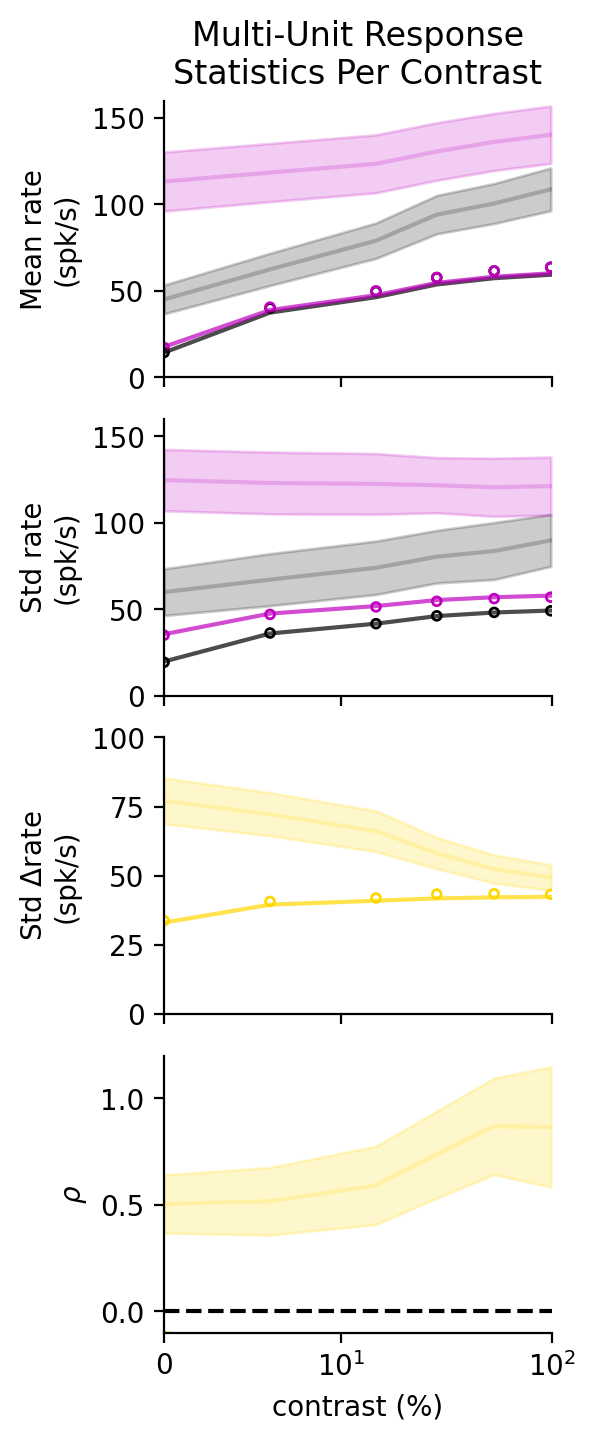

In [48]:
with open('./mu_data_moments'+'.pkl', 'rb') as handle:
    data_preds = np.transpose(pickle.load(handle),(1,0,2))
with open('./data_contrasts'+'.pkl', 'rb') as handle:
    cons = pickle.load(handle)[1]
    
nori = 20

oris = np.arange(nori//2+1) * 90/(nori/2)
def abs_ori(A):
    return 0.5*(A[:nori//2+1] + np.concatenate((A[0:1],A[-1:nori//2-1:-1])))

cidx = 5

fig,axs = plt.subplots(4,1,figsize=(2.5*1,2*4),dpi=200,sharex='col',sharey='row')
fig.subplots_adjust(hspace=0.15,wspace=0.15)

axs[0].plot([-1],[-1],label=r'Data $\pm$ SEM')
axs[0].plot([-1],[-1],label='Simulation')
axs[0].plot([-1],[-1],label='Theory')
axs[0].plot(cons,data_preds[:,0,0],color='k',alpha=0.2,label='Vis Stim Only')
axs[0].fill_between(cons,data_preds[:,0,0]-data_preds[:,0,1],
    data_preds[:,0,0]+data_preds[:,0,1],color='k',alpha=0.2,label='Vis Stim Only')
axs[0].plot(cons,dmft_preds[:,0],c='k',ls='-',label='Vis Stim Only',alpha=0.7)
axs[0].scatter(cons,sim_preds[:,0],edgecolors='k',facecolors='none',marker='o',s=10,label='Vis Stim Only')
axs[0].plot(cons,data_preds[:,1,0],color='m',alpha=0.2)
axs[0].fill_between(cons,data_preds[:,1,0]-data_preds[:,1,1],
    data_preds[:,1,0]+data_preds[:,1,1],color='m',alpha=0.2)
axs[0].plot(cons,dmft_preds[:,1],c='m',ls='-',alpha=0.7)
axs[0].scatter(cons,sim_preds[:,1],edgecolors='m',facecolors='none',marker='o',s=10)

axs[1].plot(cons,data_preds[:,2,0],color='k',alpha=0.2)
axs[1].fill_between(cons,data_preds[:,2,0]-data_preds[:,2,1],
    data_preds[:,2,0]+data_preds[:,2,1],color='k',alpha=0.2)
axs[1].plot(cons,dmft_preds[:,2],c='k',ls='-',alpha=0.7)
axs[1].scatter(cons,sim_preds[:,2],edgecolors='k',facecolors='none',marker='o',s=10)
axs[1].plot(cons,data_preds[:,3,0],color='m',alpha=0.2,label='Vis+Opto Stim')
axs[1].fill_between(cons,data_preds[:,3,0]-data_preds[:,3,1],
    data_preds[:,3,0]+data_preds[:,3,1],color='m',alpha=0.2,label='Vis+Opto Stim')
axs[1].plot(cons,dmft_preds[:,3],c='m',ls='-',label='Vis+Opto Stim',alpha=0.7)
axs[1].scatter(cons,sim_preds[:,3],edgecolors='m',facecolors='none',marker='o',s=10,label='Vis+Opto Stim')

axs[2].plot(cons,data_preds[:,4,0],color='gold',alpha=0.2,label=r'Opto Evoked $\Delta$Rate')
axs[2].fill_between(cons,data_preds[:,4,0]-data_preds[:,4,1],
    data_preds[:,4,0]+data_preds[:,4,1],color='gold',alpha=0.2,label=r'Opto Evoked $\Delta$Rate')
axs[2].plot(cons,dmft_preds[:,4],c='gold',ls='-',label=r'Opto Evoked $\Delta$Rate',alpha=0.7)
axs[2].scatter(cons,sim_preds[:,4],edgecolors='gold',facecolors='none',marker='o',s=10,label=r'Opto Evoked $\Delta$Rate')

axs[3].plot(cons,data_preds[:,5,0],color='gold',alpha=0.2)
axs[3].fill_between(cons,data_preds[:,5,0]-data_preds[:,5,1],
    data_preds[:,5,0]+data_preds[:,5,1],color='gold',alpha=0.2)
axs[3].plot(cons,dmft_preds[:,5],c='gold',ls='-',alpha=0.7)
axs[3].scatter(cons,sim_preds[:,5],edgecolors='gold',facecolors='none',marker='o',s=10)

axs[3].axhline(0,c='k',ls='--')
    
# axs[0,0].legend()
# axs[1,0].legend()
# axs[2,0].legend()

for ax in axs.flat:
    ax.spines[['right', 'top']].set_visible(False)

axs[0].set_xscale('symlog', linthresh=12)

axs[0].set_xlim(0,100)
axs[0].set_ylim(0,160)
axs[1].set_ylim(0,160)
axs[2].set_ylim(0,100)
axs[3].set_ylim(-0.1,1.2)

axs[3].set_xlabel('contrast (%)')

axs[0].set_ylabel('Mean rate\n(spk/s)')
axs[1].set_ylabel('Std rate\n(spk/s)')
axs[2].set_ylabel(r'Std $\Delta$rate'+'\n(spk/s)')
axs[3].set_ylabel(r'$\rho$')

axs[0].set_title('Multi-Unit Response\nStatistics Per Contrast',color='k')

# fig.tight_layout()
fig.savefig('./../plots/resp_stats_mult_unit_paper.pdf')

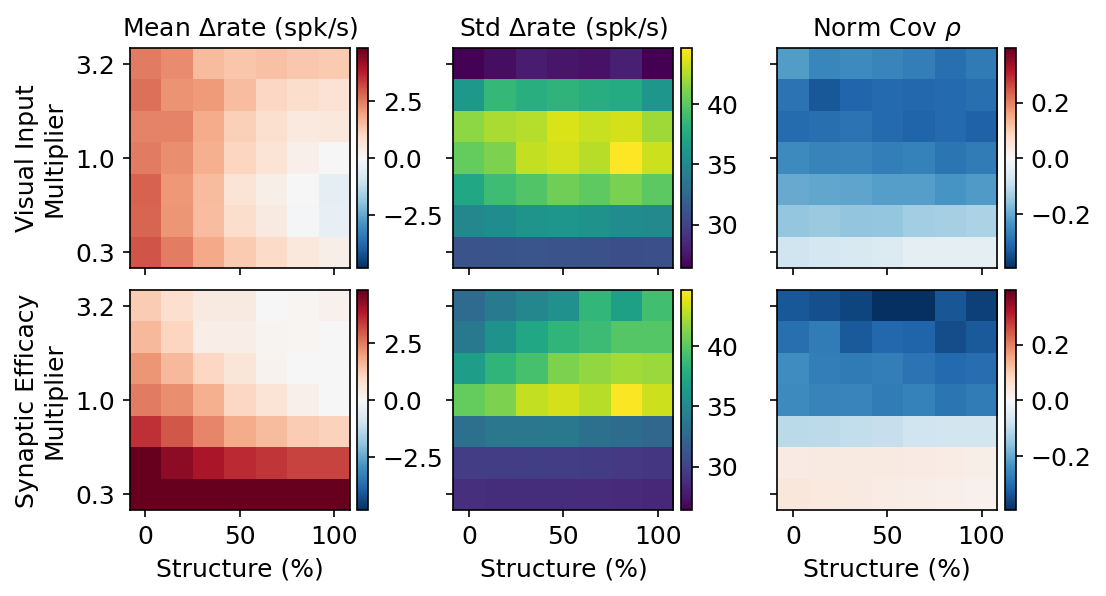

In [431]:
fig,axs = plt.subplots(2,3,figsize=(2.6*3,2*2),dpi=150,sharey=True,sharex='col')#,width_ratios=[3,3,4])
fig.subplots_adjust(wspace=0.25,hspace=0.1)

diff_mean_lim = np.nanmax(np.abs(np.concatenate((rX_vsm_diff_means.flatten(),J_vsm_diff_means[:,1:].flatten()))))
diff_std_lolim = np.nanmin(np.concatenate((rX_vsm_diff_stds.flatten(),J_vsm_diff_stds.flatten())))
diff_std_uplim = np.nanmax(np.concatenate((rX_vsm_diff_stds.flatten(),J_vsm_diff_stds.flatten())))
norm_cov_lim = np.nanmax(np.abs(np.concatenate((rX_vsm_norm_covs.flatten(),J_vsm_norm_covs[:,1:].flatten()))))
# norm_cov_lim = 0.32

cbar = imshowbar(fig,axs[0,0],rX_vsm_diff_means.T,origin='lower',cmap='RdBu_r',vmin=-diff_mean_lim,vmax=diff_mean_lim)
# axs[0,0].imshow(rX_vsm_diff_means,origin='lower',cmap='RdBu_r',vmin=-diff_mean_lim,vmax=diff_mean_lim)
cbar.ax.tick_params(labelsize=12)
cbar = imshowbar(fig,axs[0,1],rX_vsm_diff_stds.T,origin='lower',vmin=diff_std_lolim,vmax=diff_std_uplim)
# axs[1,0].imshow(rX_vsm_diff_stds,origin='lower',vmin=diff_std_lolim,vmax=diff_std_uplim)
cbar.ax.tick_params(labelsize=12)
cbar = imshowbar(fig,axs[0,2],rX_vsm_norm_covs.T,origin='lower',cmap='RdBu_r',vmin=-norm_cov_lim,vmax=norm_cov_lim)
# axs[2,0].imshow(rX_vsm_norm_covs,origin='lower',cmap='RdBu_r',vmin=-norm_cov_lim,vmax=norm_cov_lim)
cbar.ax.tick_params(labelsize=12)

cbar = imshowbar(fig,axs[1,0],J_vsm_diff_means.T,origin='lower',cmap='RdBu_r',vmin=-diff_mean_lim,vmax=diff_mean_lim)
# axs[0,1].imshow(J_vsm_diff_means,origin='lower',cmap='RdBu_r',vmin=-diff_mean_lim,vmax=diff_mean_lim)
cbar.ax.tick_params(labelsize=12)
cbar = imshowbar(fig,axs[1,1],J_vsm_diff_stds.T,origin='lower',vmin=diff_std_lolim,vmax=diff_std_uplim)
# axs[1,1].imshow(J_vsm_diff_stds,origin='lower',vmin=diff_std_lolim,vmax=diff_std_uplim)
cbar.ax.tick_params(labelsize=12)
cbar = imshowbar(fig,axs[1,2],J_vsm_norm_covs.T,origin='lower',cmap='RdBu_r',vmin=-norm_cov_lim,vmax=norm_cov_lim)
# axs[2,1].imshow(J_vsm_norm_covs,origin='lower',cmap='RdBu_r',vmin=-norm_cov_lim,vmax=norm_cov_lim)
cbar.ax.tick_params(labelsize=12)

# cbar = imshowbar(fig,axs[0,2],CVL_vsm_diff_means,origin='lower',cmap='RdBu_r',vmin=-diff_mean_lim,vmax=diff_mean_lim)
# cbar.ax.tick_params(labelsize=12)
# cbar = imshowbar(fig,axs[1,2],CVL_vsm_diff_stds,origin='lower',vmin=diff_std_lolim,vmax=diff_std_uplim)
# cbar.ax.tick_params(labelsize=12)
# cbar = imshowbar(fig,axs[2,2],CVL_vsm_norm_covs,origin='lower',cmap='RdBu_r',vmin=-norm_cov_lim,vmax=norm_cov_lim)
# cbar.ax.tick_params(labelsize=12)

axs[0,0].set_ylabel('Visual Input\nMultiplier',fontsize=12)
axs[1,0].set_ylabel('Synaptic Efficacy\nMultiplier',fontsize=12)

for i in range(2):
    axs[i,0].set_yticks(np.arange(0,7,3),['{:.1f}'.format(x) for x in 10**(np.arange(0,6+1)/6-0.5)[::3]],
                        fontsize=12)

for i in range(3):
    axs[1,i].set_xticks(np.arange(0,7,3),['{:d}'.format(int(struct*100)) for struct in (np.arange(6+1)/6)[::3]],
                        fontsize=12)
    axs[1,i].set_xlabel('Structure (%)',fontsize=12)

axs[0,0].set_title(r'Mean $\Delta$rate (spk/s)',fontsize=12)
axs[0,1].set_title(r'Std $\Delta$rate (spk/s)',fontsize=12)
axs[0,2].set_title(r'Norm Cov $\rho$',fontsize=12)

# fig.tight_layout()
fig.savefig('../plots'+'/varied_struct_paper.pdf', bbox_inches='tight')

/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_23801/1541660732.py:61: RuntimeWarning: invalid value encountered in divide
  axs[1,0].plot(cons,np.concatenate(([1,],((peak2-base)/(peak1-base))[1:])),c=['k','m'][i],ls='-',alpha=0.7)


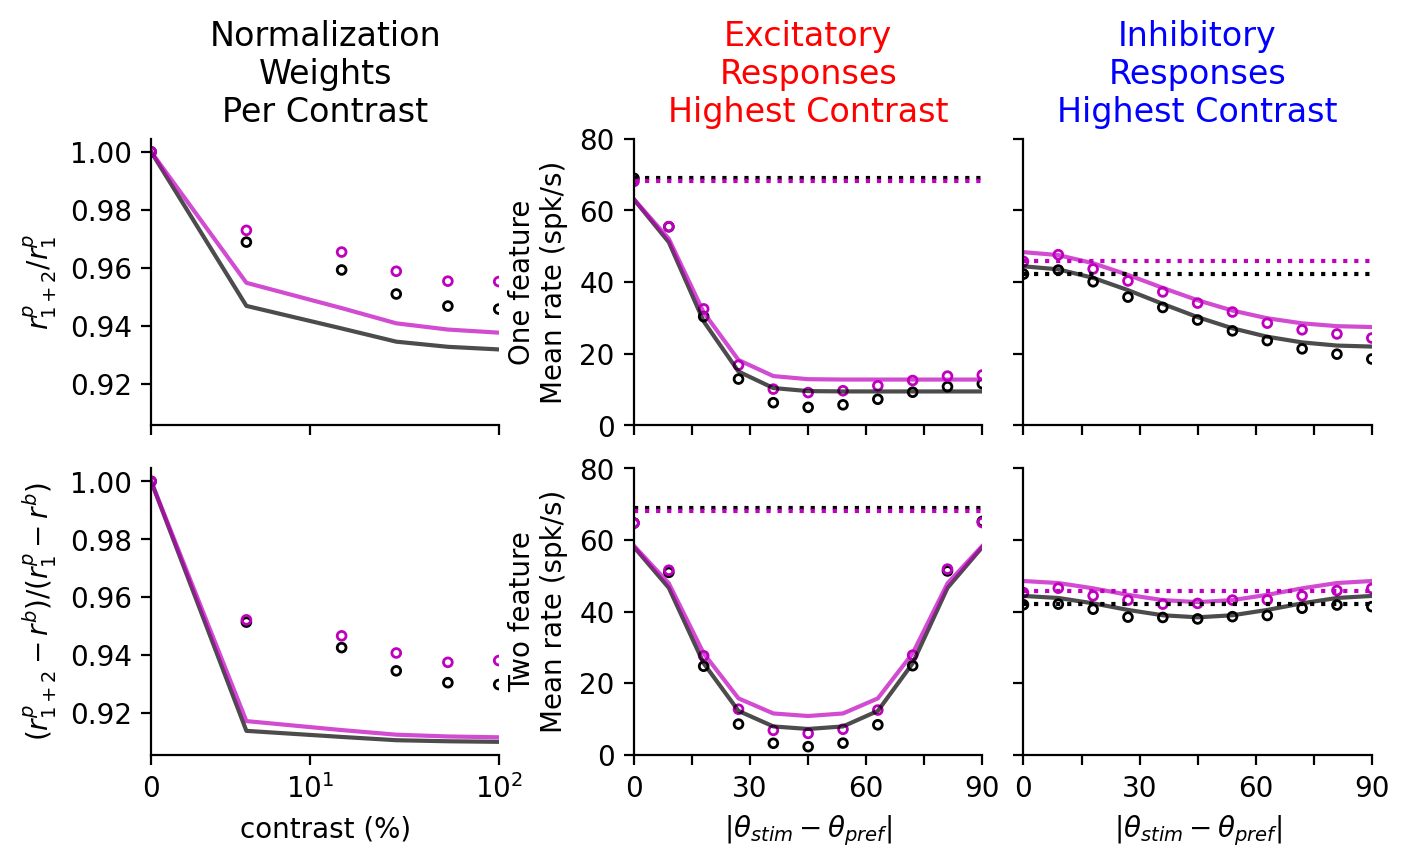

In [443]:
with open('./data_moments'+'.pkl', 'rb') as handle:
    data_preds = np.transpose(pickle.load(handle)[1],(1,0,2))
with open('./data_contrasts'+'.pkl', 'rb') as handle:
    cons = pickle.load(handle)[1]
    
nori = 20

oris = np.arange(nori//2+1) * 90/(nori/2)
def abs_ori(A):
    return 0.5*(A[:nori//2+1] + np.concatenate((A[0:1],A[-1:nori//2-1:-1])))

cidx = 5

fig,axs = plt.subplots(2,4,figsize=(2.5*3.15,2*2),dpi=200,sharex='col',sharey='col',width_ratios=[1,0.15,1,1])
fig.subplots_adjust(hspace=0.15,wspace=0.15)

axs[0,1].set_axis_off()
axs[1,1].set_axis_off()
axs[0,3].yaxis.set_tick_params(which='both',labelleft=False)
axs[1,3].yaxis.set_tick_params(which='both',labelleft=False)

axs[0,2].plot(oris,abs_ori(dmft_μrEs[cidx,0,:]),c='k',ls='-',alpha=0.7)
axs[0,2].scatter(oris,abs_ori(sim_μrEs[cidx,0,:]),
    edgecolors='k',facecolors='none',marker='o',s=10)
axs[0,2].plot(oris,abs_ori(dmft_μrEs[cidx,1,:]),c='m',ls='-',alpha=0.7)
axs[0,2].scatter(oris,abs_ori(sim_μrEs[cidx,1,:]),
    edgecolors='m',facecolors='none',marker='o',s=10)

axs[0,3].plot(oris,abs_ori(dmft_μrIs[cidx,0,:]),c='k',ls='-',alpha=0.7)
axs[0,3].scatter(oris,abs_ori(sim_μrIs[cidx,0,:]),
    edgecolors='k',facecolors='none',marker='o',s=10)
axs[0,3].plot(oris,abs_ori(dmft_μrIs[cidx,1,:]),c='m',ls='-',alpha=0.7)
axs[0,3].scatter(oris,abs_ori(sim_μrIs[cidx,1,:]),
    edgecolors='m',facecolors='none',marker='o',s=10)

axs[1,2].plot(oris,abs_ori(dmft_norm_μrEs[cidx,0,:]),c='k',ls='-',alpha=0.7)
axs[1,2].scatter(oris,abs_ori(sim_norm_μrEs[cidx,0,:]),
    edgecolors='k',facecolors='none',marker='o',s=10)
axs[1,2].plot(oris,abs_ori(dmft_norm_μrEs[cidx,1,:]),c='m',ls='-',alpha=0.7)
axs[1,2].scatter(oris,abs_ori(sim_norm_μrEs[cidx,1,:]),
    edgecolors='m',facecolors='none',marker='o',s=10)

axs[1,3].plot(oris,abs_ori(dmft_norm_μrIs[cidx,0,:]),c='k',ls='-',alpha=0.7)
axs[1,3].scatter(oris,abs_ori(sim_norm_μrIs[cidx,0,:]),
    edgecolors='k',facecolors='none',marker='o',s=10)
axs[1,3].plot(oris,abs_ori(dmft_norm_μrIs[cidx,1,:]),c='m',ls='-',alpha=0.7)
axs[1,3].scatter(oris,abs_ori(sim_norm_μrIs[cidx,1,:]),
    edgecolors='m',facecolors='none',marker='o',s=10)

for i in range(2):
    axs[i,2].axhline(sim_μrEs[cidx,0,0],c='k',ls=':')
    axs[i,2].axhline(sim_μrEs[cidx,1,0],c='m',ls=':')
    axs[i,3].axhline(sim_μrIs[cidx,0,0],c='k',ls=':')
    axs[i,3].axhline(sim_μrIs[cidx,1,0],c='m',ls=':')
    
for i,opto in enumerate(np.arange(2)):
    base = 0.8*np.mean(dmft_μrEs[0,i,:])+0.2*np.mean(dmft_μrIs[0,i,:])
    peak1 = 0.8*dmft_μrEs[:,i,0]+0.2*dmft_μrIs[:,i,0]
    peak2 = 0.8*dmft_norm_μrEs[:,i,0]+0.2*dmft_norm_μrIs[:,i,0]
    axs[0,0].plot(cons,peak2/peak1,c=['k','m'][i],ls='-',alpha=0.7)
    axs[1,0].plot(cons,np.concatenate(([1,],((peak2-base)/(peak1-base))[1:])),c=['k','m'][i],ls='-',alpha=0.7)
    base = 0.8*np.mean(sim_μrEs[0,i,:])+0.2*np.mean(sim_μrIs[0,i,:])
    peak1 = 0.8*sim_μrEs[:,i,0]+0.2*sim_μrIs[:,i,0]
    peak2 = 0.8*sim_norm_μrEs[:,i,0]+0.2*sim_norm_μrIs[:,i,0]
    axs[0,0].scatter(cons,peak2/peak1,edgecolors=['k','m'][i],
                facecolors='none',marker='o',s=10,
                label=['Vis Only','Vis+Opto'][i])
    axs[1,0].scatter(cons,(peak2-base)/(peak1-base),edgecolors=['k','m'][i],
                facecolors='none',marker='o',s=10,
                label=['Vis Only','Vis+Opto'][i])
    
# axs[0,0].legend()
# axs[1,0].legend()
# axs[2,0].legend()

for ax in axs.flat:
    ax.spines[['right', 'top']].set_visible(False)

axs[0,0].set_xscale('symlog', linthresh=12)
nticks = 7
ticks = np.array(['{:.0f}'.format(ori) for ori in np.linspace(0,90,nticks)])
ticks[1::2] = ''
for i in range(2,4):
    axs[0,i].set_xticks(np.linspace(0,90,7),ticks)

axs[0,0].set_xlim(0,100)
axs[0,2].set_xlim(0,90)
axs[0,3].set_xlim(0,90)
# axs[0,0].set_ylim(None,1)
for i in range(2,4):
    axs[0,i].set_ylim(0,80)
    axs[1,i].set_ylim(0,80)

axs[1,0].set_xlabel('contrast (%)')
axs[1,2].set_xlabel(r'$|\theta_{stim}-\theta_{pref}|$')
axs[1,3].set_xlabel(r'$|\theta_{stim}-\theta_{pref}|$')

axs[0,0].set_ylabel(r'$r^p_{1+2}/r^p_{1}$')
axs[1,0].set_ylabel(r'$(r^p_{1+2}-r^b)/(r^p_{1}-r^b)$')
axs[0,2].set_ylabel('One feature\nMean rate (spk/s)')
axs[1,2].set_ylabel('Two feature\nMean rate (spk/s)')

axs[0,0].set_title('Normalization\nWeights\nPer Contrast',color='k')
axs[0,2].set_title('Excitatory\nResponses\nHighest Contrast',color='r')
axs[0,3].set_title('Inhibitory\nResponses\nHighest Contrast',color='b')

# fig.tight_layout()
fig.savefig('./../plots/opto_norm_paper.pdf')

# Supplemental Figures

In [4]:
sim_opto_inh_all_base_means = np.zeros((6))
sim_opto_inh_all_base_stds = np.zeros((6))
sim_opto_inh_all_opto_means = np.zeros((6))
sim_opto_inh_all_opto_stds = np.zeros((6))
sim_opto_inh_all_diff_means = np.zeros((6))
sim_opto_inh_all_diff_stds = np.zeros((6))
sim_opto_inh_all_norm_covs = np.zeros((6))
sim_opto_inh_vsm_base_means = np.zeros((6))
sim_opto_inh_vsm_base_stds = np.zeros((6))
sim_opto_inh_vsm_opto_means = np.zeros((6))
sim_opto_inh_vsm_opto_stds = np.zeros((6))
sim_opto_inh_vsm_diff_means = np.zeros((6))
sim_opto_inh_vsm_diff_stds = np.zeros((6))
sim_opto_inh_vsm_norm_covs = np.zeros((6))
sim_opto_inh_osm_diff_means = np.zeros((6))
sim_opto_inh_vsm_bals = np.zeros((6))
sim_opto_inh_vsm_oves = np.zeros((6))
sim_opto_inh_μrEs = np.zeros((6,3,20))
sim_opto_inh_μrIs = np.zeros((6,3,20))
sim_opto_inh_ΣrEs = np.zeros((6,4,20))
sim_opto_inh_ΣrIs = np.zeros((6,4,20))
sim_opto_inh_preds = np.zeros((6,6,20))
sim_opto_inh_Lexps = np.zeros((6,2))
sim_opto_inh_timeouts = np.zeros((6,2))

for c_idx in range(6):
    try:
        with open('./../results/opto_inh_id_None_c_{:d}'.format(c_idx)+'.pkl','rb') as\
                handle:
            res_dict = pickle.load(handle)

        sim_opto_inh_all_base_means[c_idx] = res_dict['all_base_means']
        sim_opto_inh_all_base_stds[c_idx] = res_dict['all_base_stds']
        sim_opto_inh_all_opto_means[c_idx] = res_dict['all_opto_means']
        sim_opto_inh_all_opto_stds[c_idx] = res_dict['all_opto_stds']
        sim_opto_inh_all_diff_means[c_idx] = res_dict['all_diff_means']
        sim_opto_inh_all_diff_stds[c_idx] = res_dict['all_diff_stds']
        sim_opto_inh_all_norm_covs[c_idx] = res_dict['all_norm_covs']
        sim_opto_inh_vsm_base_means[c_idx] = res_dict['vsm_base_means']
        sim_opto_inh_vsm_base_stds[c_idx] = res_dict['vsm_base_stds']
        sim_opto_inh_vsm_opto_means[c_idx] = res_dict['vsm_opto_means']
        sim_opto_inh_vsm_opto_stds[c_idx] = res_dict['vsm_opto_stds']
        sim_opto_inh_vsm_diff_means[c_idx] = res_dict['vsm_diff_means']
        sim_opto_inh_vsm_diff_stds[c_idx] = res_dict['vsm_diff_stds']
        sim_opto_inh_vsm_norm_covs[c_idx] = res_dict['vsm_norm_covs']
        sim_opto_inh_osm_diff_means[c_idx] = res_dict['osm_diff_means']
        sim_opto_inh_vsm_bals[c_idx] = res_dict['vsm_bals']
        sim_opto_inh_vsm_oves[c_idx] = res_dict['vsm_oves']
        sim_opto_inh_μrEs[c_idx] = np.mean(res_dict['μrEs'],0)
        sim_opto_inh_μrIs[c_idx] = np.mean(res_dict['μrIs'],0)
        sim_opto_inh_ΣrEs[c_idx] = np.mean(res_dict['ΣrEs'],0)
        sim_opto_inh_ΣrIs[c_idx] = np.mean(res_dict['ΣrIs'],0)
        sim_opto_inh_Lexps[c_idx] = np.median(res_dict['Lexps'],-2)
        sim_opto_inh_timeouts[c_idx] = np.sum(res_dict['timeouts'],-2)

    except:
        sim_opto_inh_all_base_means[c_idx] = np.nan
        sim_opto_inh_all_base_stds[c_idx] = np.nan
        sim_opto_inh_all_opto_means[c_idx] = np.nan
        sim_opto_inh_all_opto_stds[c_idx] = np.nan
        sim_opto_inh_all_diff_means[c_idx] = np.nan
        sim_opto_inh_all_diff_stds[c_idx] = np.nan
        sim_opto_inh_all_norm_covs[c_idx] = np.nan
        sim_opto_inh_vsm_base_means[c_idx] = np.nan
        sim_opto_inh_vsm_base_stds[c_idx] = np.nan
        sim_opto_inh_vsm_opto_means[c_idx] = np.nan
        sim_opto_inh_vsm_opto_stds[c_idx] = np.nan
        sim_opto_inh_vsm_diff_means[c_idx] = np.nan
        sim_opto_inh_vsm_diff_stds[c_idx] = np.nan
        sim_opto_inh_vsm_norm_covs[c_idx] = np.nan
        sim_opto_inh_osm_diff_means[c_idx] = np.nan
        sim_opto_inh_vsm_bals[c_idx] = np.nan
        sim_opto_inh_vsm_oves[c_idx] = np.nan
        sim_opto_inh_μrEs[c_idx] = np.nan
        sim_opto_inh_μrIs[c_idx] = np.nan
        sim_opto_inh_ΣrEs[c_idx] = np.nan
        sim_opto_inh_ΣrIs[c_idx] = np.nan
        sim_opto_inh_Lexps[c_idx] = np.nan
        sim_opto_inh_timeouts[c_idx] = 0
        
sim_opto_inh_preds = np.concatenate((
    sim_opto_inh_vsm_base_means[:,None],
    sim_opto_inh_vsm_opto_means[:,None],
    sim_opto_inh_vsm_base_stds[:,None],
    sim_opto_inh_vsm_opto_stds[:,None],
    sim_opto_inh_vsm_diff_stds[:,None],
    sim_opto_inh_vsm_norm_covs[:,None],
    sim_opto_inh_vsm_diff_means[:,None],
    sim_opto_inh_osm_diff_means[:,None],
),1)
        
sim_opto_inh_Epreds = np.concatenate((
    sim_opto_inh_μrEs[:,0:1,:],
    sim_opto_inh_μrEs[:,1:2,:],
    np.sqrt(sim_opto_inh_ΣrEs[:,0:1,:]),
    np.sqrt(sim_opto_inh_ΣrEs[:,1:2,:]),
    np.sqrt(sim_opto_inh_ΣrEs[:,2:3,:]),
    sim_opto_inh_ΣrEs[:,3:4,:]/sim_opto_inh_ΣrEs[:,2:3,:],
    sim_opto_inh_μrEs[:,2:3,:]
),1)

sim_opto_inh_Ipreds = np.concatenate((
    sim_opto_inh_μrIs[:,0:1,:],
    sim_opto_inh_μrIs[:,1:2,:],
    np.sqrt(sim_opto_inh_ΣrIs[:,0:1,:]),
    np.sqrt(sim_opto_inh_ΣrIs[:,1:2,:]),
    np.sqrt(sim_opto_inh_ΣrIs[:,2:3,:]),
    sim_opto_inh_ΣrIs[:,3:4,:]/sim_opto_inh_ΣrIs[:,2:3,:],
    sim_opto_inh_μrIs[:,2:3,:]
),1)

nEsamp = 400*50
nIsamp = 100*50

sim_opto_inh_Epred_errs = np.concatenate((
    np.sqrt(sim_opto_inh_ΣrEs[:,0:1,:]/nEsamp),
    np.sqrt(sim_opto_inh_ΣrEs[:,1:2,:]/nEsamp),
    np.sqrt(sim_opto_inh_ΣrEs[:,0:1,:]/(2*nEsamp)),
    np.sqrt(sim_opto_inh_ΣrEs[:,1:2,:]/(2*nEsamp)),
    np.sqrt(sim_opto_inh_ΣrEs[:,2:3,:]/(2*nEsamp)),
    np.abs(sim_opto_inh_ΣrEs[:,3:4,:]/sim_opto_inh_ΣrEs[:,2:3,:])/np.sqrt(nEsamp)
),1)

sim_opto_inh_Ipred_errs = np.concatenate((
    np.sqrt(sim_opto_inh_ΣrIs[:,0:1,:]/nIsamp),
    np.sqrt(sim_opto_inh_ΣrIs[:,1:2,:]/nIsamp),
    np.sqrt(sim_opto_inh_ΣrIs[:,0:1,:]/(2*nIsamp)),
    np.sqrt(sim_opto_inh_ΣrIs[:,1:2,:]/(2*nIsamp)),
    np.sqrt(sim_opto_inh_ΣrIs[:,2:3,:]/(2*nIsamp)),
    np.abs(sim_opto_inh_ΣrIs[:,3:4,:]/sim_opto_inh_ΣrIs[:,2:3,:])/np.sqrt(nIsamp)
),1)

In [48]:
sim_opto_μrEs = np.zeros((6,3,20,5,2))
sim_opto_μrIs = np.zeros((6,3,20,5,2))
sim_opto_ΣrEs = np.zeros((6,4,20,5,2))
sim_opto_ΣrIs = np.zeros((6,4,20,5,2))
sim_opto_vsm_base_means = np.zeros((6,5,2))
sim_opto_vsm_base_stds = np.zeros((6,5,2))
sim_opto_vsm_opto_means = np.zeros((6,5,2))
sim_opto_vsm_opto_stds = np.zeros((6,5,2))
sim_opto_vsm_diff_means = np.zeros((6,5,2))
sim_opto_vsm_diff_stds = np.zeros((6,5,2))
sim_opto_vsm_norm_covs = np.zeros((6,5,2))
sim_opto_Lexps = np.zeros((6,5,2,2))
sim_opto_timeouts = np.zeros((6,5,2,2))

for c_idx in range(6):
    for opto_idx,Lx in enumerate(np.arange(4+1)/4):
        for sign_idx,sign in enumerate([-1,1]):
            try:
                if opto_idx==0 and sign_idx==0:
                    with open('./../results/vary_opto_id_None_Lx{:.2f}_c_{:d}'.format(Lx,c_idx)+'.pkl', 'rb') as\
                            handle:
                        res_dict = pickle.load(handle)
                else:
                    with open('./../results/vary_opto_id_None_Lx{:.2f}_c_{:d}'.format(sign*Lx,c_idx)+'.pkl', 'rb') as\
                            handle:
                        res_dict = pickle.load(handle)

                sim_opto_μrEs[c_idx,:,:,opto_idx,sign_idx] = np.mean(res_dict['μrEs'],0)
                sim_opto_μrIs[c_idx,:,:,opto_idx,sign_idx] = np.mean(res_dict['μrIs'],0)
                sim_opto_ΣrEs[c_idx,:,:,opto_idx,sign_idx] = np.mean(res_dict['ΣrEs'],0)
                sim_opto_ΣrIs[c_idx,:,:,opto_idx,sign_idx] = np.mean(res_dict['ΣrIs'],0)
                sim_opto_vsm_base_means[c_idx,opto_idx,sign_idx] = res_dict['vsm_base_means']
                sim_opto_vsm_base_stds[c_idx,opto_idx,sign_idx] = res_dict['vsm_base_stds']
                sim_opto_vsm_opto_means[c_idx,opto_idx,sign_idx] = res_dict['vsm_opto_means']
                sim_opto_vsm_opto_stds[c_idx,opto_idx,sign_idx] = res_dict['vsm_opto_stds']
                sim_opto_vsm_diff_means[c_idx,opto_idx,sign_idx] = res_dict['vsm_diff_means']
                sim_opto_vsm_diff_stds[c_idx,opto_idx,sign_idx] = res_dict['vsm_diff_stds']
                sim_opto_vsm_norm_covs[c_idx,opto_idx,sign_idx] = res_dict['vsm_norm_covs']
                sim_opto_Lexps[c_idx,opto_idx,sign_idx] = np.median(res_dict['Lexps'],-2)
                sim_opto_timeouts[c_idx,opto_idx,sign_idx] = np.sum(res_dict['timeouts'],-2)
                
            except:
                sim_opto_μrEs[c_idx,:,:,opto_idx,sign_idx] = np.nan
                sim_opto_μrIs[c_idx,:,:,opto_idx,sign_idx] = np.nan
                sim_opto_ΣrEs[c_idx,:,:,opto_idx,sign_idx] = np.nan
                sim_opto_ΣrIs[c_idx,:,:,opto_idx,sign_idx] = np.nan
                sim_opto_vsm_base_means[c_idx,opto_idx,sign_idx] = np.nan
                sim_opto_vsm_base_stds[c_idx,opto_idx,sign_idx] = np.nan
                sim_opto_vsm_opto_means[c_idx,opto_idx,sign_idx] = np.nan
                sim_opto_vsm_opto_stds[c_idx,opto_idx,sign_idx] = np.nan
                sim_opto_vsm_diff_means[c_idx,opto_idx,sign_idx] = np.nan
                sim_opto_vsm_diff_stds[c_idx,opto_idx,sign_idx] = np.nan
                sim_opto_vsm_norm_covs[c_idx,opto_idx,sign_idx] = np.nan
                sim_opto_Lexps[c_idx,opto_idx,sign_idx] = np.nan
                sim_opto_timeouts[c_idx,opto_idx,sign_idx] = 0
                
sim_opto_vsm_base_means[:,:,:] = sim_opto_vsm_opto_means[:,0:1,:]
sim_opto_vsm_base_stds[:,:,:] = sim_opto_vsm_opto_stds[:,0:1,:]
sim_opto_vsm_diff_means = sim_opto_vsm_opto_means - sim_opto_vsm_base_means
        
sim_opto_preds = np.concatenate((
    sim_opto_vsm_base_means[:,None,:,:],
    sim_opto_vsm_opto_means[:,None,:,:],
    sim_opto_vsm_base_stds[:,None,:,:],
    sim_opto_vsm_opto_stds[:,None,:,:],
    sim_opto_vsm_diff_means[:,None,:,:],
    sim_opto_vsm_diff_stds[:,None,:,:],
    sim_opto_vsm_norm_covs[:,None,:,:],
),1)
        
sim_opto_Epreds = np.concatenate((
    sim_opto_μrEs[:,0:1,:,:,:],
    sim_opto_μrEs[:,1:2,:,:,:],
    np.sqrt(sim_opto_ΣrEs[:,0:1,:,:,:]),
    np.sqrt(sim_opto_ΣrEs[:,1:2,:,:,:]),
    sim_opto_μrEs[:,2:3,:,:,:],
    np.sqrt(sim_opto_ΣrEs[:,2:3,:,:,:]),
    sim_opto_ΣrEs[:,3:4,:,:,:]/sim_opto_ΣrEs[:,2:3,:,:,:]
),1)

sim_opto_Ipreds = np.concatenate((
    sim_opto_μrIs[:,0:1,:,:,:],
    sim_opto_μrIs[:,1:2,:,:,:],
    np.sqrt(sim_opto_ΣrIs[:,0:1,:,:,:]),
    np.sqrt(sim_opto_ΣrIs[:,1:2,:,:,:]),
    sim_opto_μrIs[:,2:3,:,:,:],
    np.sqrt(sim_opto_ΣrIs[:,2:3,:,:,:]),
    sim_opto_ΣrIs[:,3:4,:,:,:]/sim_opto_ΣrIs[:,2:3,:,:,:]
),1)

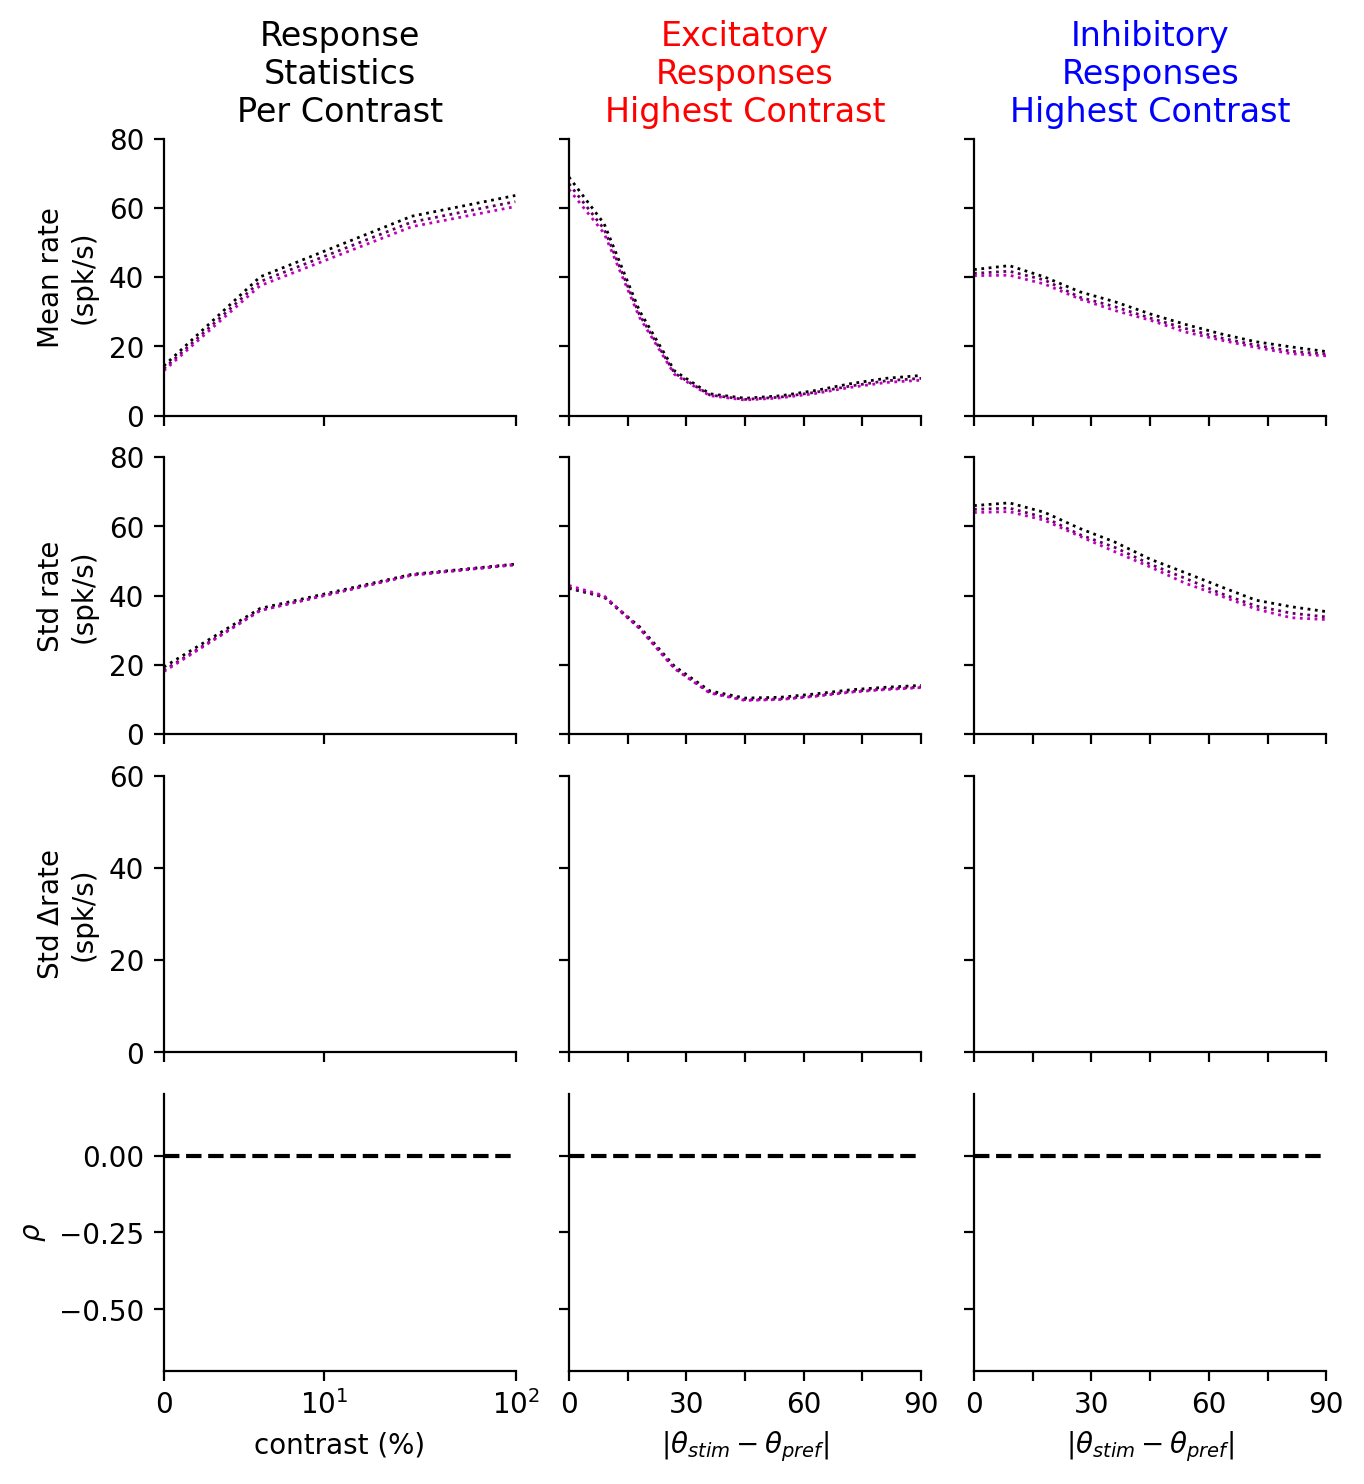

In [61]:
with open('./data_moments'+'.pkl', 'rb') as handle:
    data_preds = np.transpose(pickle.load(handle)[1],(1,0,2))
with open('./data_contrasts'+'.pkl', 'rb') as handle:
    cons = pickle.load(handle)[1]
    
nori = 20

oris = np.arange(nori//2+1) * 90/(nori/2)
def abs_ori(A):
    return 0.5*(A[:nori//2+1] + np.concatenate((A[0:1],A[-1:nori//2-1:-1])))

cidx = 5

good_cons = [0,1,3,5]

fig,axs = plt.subplots(4,3,figsize=(2.5*3,2*4),dpi=200,sharex='col',sharey='row')
fig.subplots_adjust(hspace=0.15,wspace=0.15)

for opto_idx in range(0,5,2):
    axs[0,0].plot(cons[good_cons],sim_opto_preds[good_cons,1,opto_idx,0],c=(0.75*opto_idx/4,0,0.75*opto_idx/4),ls=':',lw=1)

    axs[1,0].plot(cons[good_cons],sim_opto_preds[good_cons,3,opto_idx,0],c=(0.75*opto_idx/4,0,0.75*opto_idx/4),ls=':',lw=1)

    # axs[2,0].plot(cons[good_cons],sim_opto_preds[good_cons,4,opto_idx,0],c=(opto_idx/4,0.84*opto_idx/4,0),ls=':',lw=1)

    axs[0,1].plot(oris,abs_ori(sim_opto_Epreds[cidx,1,:,opto_idx,0]),
        c=(0.75*opto_idx/4,0,0.75*opto_idx/4),ls=':',lw=1)
    axs[0,2].plot(oris,abs_ori(sim_opto_Ipreds[cidx,1,:,opto_idx,0]),
        c=(0.75*opto_idx/4,0,0.75*opto_idx/4),ls=':',lw=1)

    axs[1,1].plot(oris,abs_ori(sim_opto_Epreds[cidx,3,:,opto_idx,0]),
        c=(0.75*opto_idx/4,0,0.75*opto_idx/4),ls=':',lw=1)
    axs[1,2].plot(oris,abs_ori(sim_opto_Ipreds[cidx,3,:,opto_idx,0]),
        c=(0.75*opto_idx/4,0,0.75*opto_idx/4),ls=':',lw=1)

for i in range(3):
    axs[3,i].axhline(0,c='k',ls='--')

for ax in axs.flat:
    ax.spines[['right', 'top']].set_visible(False)

axs[0,0].set_xscale('symlog', linthresh=12)
nticks = 7
ticks = np.array(['{:.0f}'.format(ori) for ori in np.linspace(0,90,nticks)])
ticks[1::2] = ''
for i in range(1,3):
    axs[0,i].set_xticks(np.linspace(0,90,7),ticks)

axs[0,0].set_xlim(0,100)
axs[0,1].set_xlim(0,90)
axs[0,2].set_xlim(0,90)
axs[0,0].set_ylim(0,80)
axs[1,0].set_ylim(0,80)
axs[2,0].set_ylim(0,60)
axs[3,0].set_ylim(-0.7,0.2)

axs[3,0].set_xlabel('contrast (%)')
axs[3,1].set_xlabel(r'$|\theta_{stim}-\theta_{pref}|$')
axs[3,2].set_xlabel(r'$|\theta_{stim}-\theta_{pref}|$')

axs[0,0].set_ylabel('Mean rate\n(spk/s)')
axs[1,0].set_ylabel('Std rate\n(spk/s)')
axs[2,0].set_ylabel(r'Std $\Delta$rate'+'\n(spk/s)')
axs[3,0].set_ylabel(r'$\rho$')

axs[0,0].set_title('Response\nStatistics\nPer Contrast',color='k')
axs[0,1].set_title('Excitatory\nResponses\nHighest Contrast',color='r')
axs[0,2].set_title('Inhibitory\nResponses\nHighest Contrast',color='b')


fig.savefig('./../plots/resp_stats_opto_inh_paper.pdf')

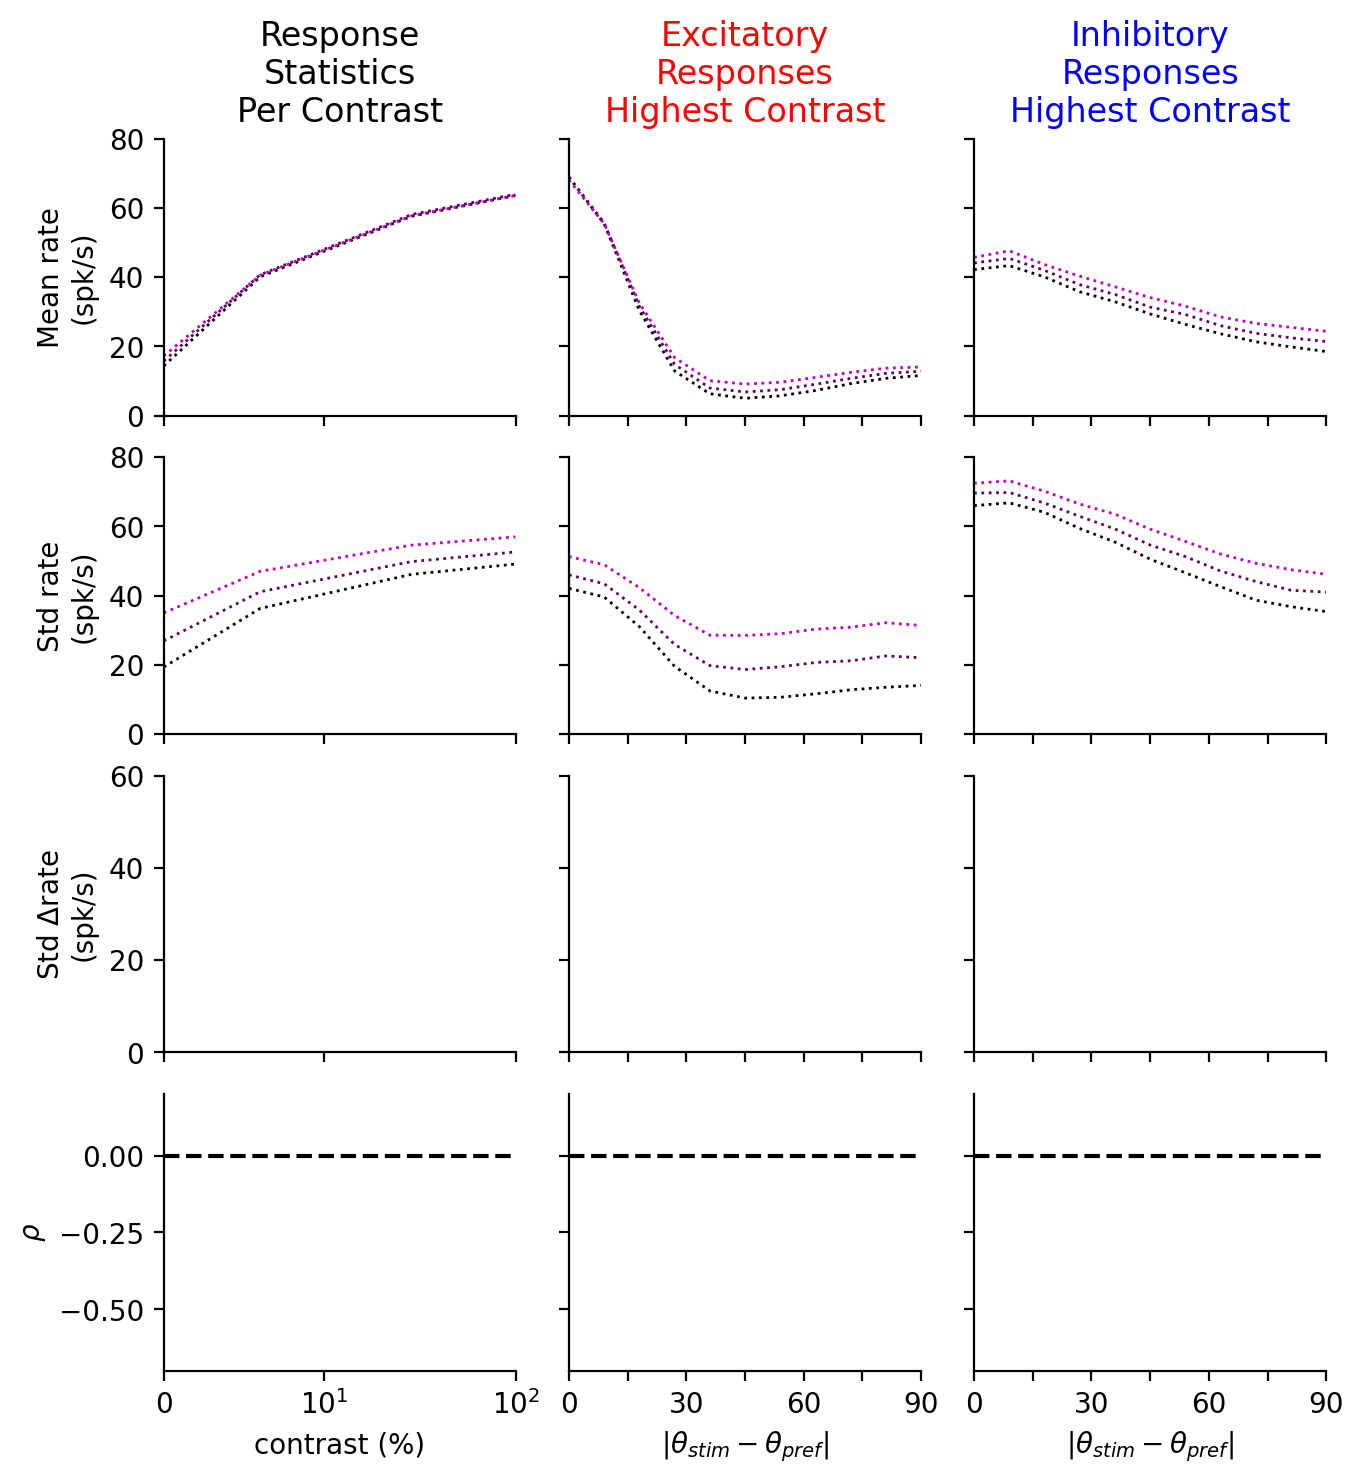

In [62]:
with open('./data_moments'+'.pkl', 'rb') as handle:
    data_preds = np.transpose(pickle.load(handle)[1],(1,0,2))
with open('./data_contrasts'+'.pkl', 'rb') as handle:
    cons = pickle.load(handle)[1]
    
nori = 20

oris = np.arange(nori//2+1) * 90/(nori/2)
def abs_ori(A):
    return 0.5*(A[:nori//2+1] + np.concatenate((A[0:1],A[-1:nori//2-1:-1])))

cidx = 5

good_cons = [0,1,3,5]

fig,axs = plt.subplots(4,3,figsize=(2.5*3,2*4),dpi=200,sharex='col',sharey='row')
fig.subplots_adjust(hspace=0.15,wspace=0.15)

for opto_idx in range(0,5,2):
    axs[0,0].plot(cons[good_cons],sim_opto_preds[good_cons,1,opto_idx,1],c=(0.75*opto_idx/4,0,0.75*opto_idx/4),ls=':',lw=1)

    axs[1,0].plot(cons[good_cons],sim_opto_preds[good_cons,3,opto_idx,1],c=(0.75*opto_idx/4,0,0.75*opto_idx/4),ls=':',lw=1)

    # axs[2,0].plot(cons[good_cons],sim_opto_preds[good_cons,4,opto_idx,1],c=(opto_idx/4,0.84*opto_idx/4,0),ls=':',lw=1)

    axs[0,1].plot(oris,abs_ori(sim_opto_Epreds[cidx,1,:,opto_idx,1]),
        c=(0.75*opto_idx/4,0,0.75*opto_idx/4),ls=':',lw=1)
    axs[0,2].plot(oris,abs_ori(sim_opto_Ipreds[cidx,1,:,opto_idx,1]),
        c=(0.75*opto_idx/4,0,0.75*opto_idx/4),ls=':',lw=1)

    axs[1,1].plot(oris,abs_ori(sim_opto_Epreds[cidx,3,:,opto_idx,1]),
        c=(0.75*opto_idx/4,0,0.75*opto_idx/4),ls=':',lw=1)
    axs[1,2].plot(oris,abs_ori(sim_opto_Ipreds[cidx,3,:,opto_idx,1]),
        c=(0.75*opto_idx/4,0,0.75*opto_idx/4),ls=':',lw=1)

for i in range(3):
    axs[3,i].axhline(0,c='k',ls='--')

for ax in axs.flat:
    ax.spines[['right', 'top']].set_visible(False)

axs[0,0].set_xscale('symlog', linthresh=12)
nticks = 7
ticks = np.array(['{:.0f}'.format(ori) for ori in np.linspace(0,90,nticks)])
ticks[1::2] = ''
for i in range(1,3):
    axs[0,i].set_xticks(np.linspace(0,90,7),ticks)

axs[0,0].set_xlim(0,100)
axs[0,1].set_xlim(0,90)
axs[0,2].set_xlim(0,90)
axs[0,0].set_ylim(0,80)
axs[1,0].set_ylim(0,80)
axs[2,0].set_ylim(0,60)
axs[3,0].set_ylim(-0.7,0.2)

axs[3,0].set_xlabel('contrast (%)')
axs[3,1].set_xlabel(r'$|\theta_{stim}-\theta_{pref}|$')
axs[3,2].set_xlabel(r'$|\theta_{stim}-\theta_{pref}|$')

axs[0,0].set_ylabel('Mean rate\n(spk/s)')
axs[1,0].set_ylabel('Std rate\n(spk/s)')
axs[2,0].set_ylabel(r'Std $\Delta$rate'+'\n(spk/s)')
axs[3,0].set_ylabel(r'$\rho$')

axs[0,0].set_title('Response\nStatistics\nPer Contrast',color='k')
axs[0,1].set_title('Excitatory\nResponses\nHighest Contrast',color='r')
axs[0,2].set_title('Inhibitory\nResponses\nHighest Contrast',color='b')


fig.savefig('./../plots/resp_stats_opto_exc_paper.pdf')

In [10]:
sim_tune_μrEs = np.zeros((3,20,9,2))
sim_tune_μrIs = np.zeros((3,20,9,2))
sim_tune_ΣrEs = np.zeros((4,20,9,2))
sim_tune_ΣrIs = np.zeros((4,20,9,2))
sim_tune_vsm_base_means = np.zeros((9,2))
sim_tune_vsm_base_stds = np.zeros((9,2))
sim_tune_vsm_opto_means = np.zeros((9,2))
sim_tune_vsm_opto_stds = np.zeros((9,2))
sim_tune_vsm_diff_means = np.zeros((9,2))
sim_tune_vsm_diff_stds = np.zeros((9,2))
sim_tune_vsm_norm_covs = np.zeros((9,2))
sim_tune_Lexps = np.zeros((9,2,2))
sim_tune_timeouts = np.zeros((9,2,2))

for tune_idx in range(9):
    for ortho_idx,ortho in enumerate(np.arange(2)):
        try:
            if tune_idx==0 and ortho_idx==1:
                with open('./../results/vary_id_None_tune_{:d}_ortho_{:d}'.format(tune_idx,0)+'.pkl', 'rb') as\
                        handle:
                    res_dict = pickle.load(handle)
            else:
                with open('./../results/vary_id_None_tune_{:d}_ortho_{:d}'.format(tune_idx,ortho_idx)+'.pkl', 'rb') as\
                        handle:
                    res_dict = pickle.load(handle)

            sim_tune_μrEs[:,:,tune_idx,ortho_idx] = np.mean(res_dict['μrEs'],0)
            sim_tune_μrIs[:,:,tune_idx,ortho_idx] = np.mean(res_dict['μrIs'],0)
            sim_tune_ΣrEs[:,:,tune_idx,ortho_idx] = np.mean(res_dict['ΣrEs'],0)
            sim_tune_ΣrIs[:,:,tune_idx,ortho_idx] = np.mean(res_dict['ΣrIs'],0)
            sim_tune_vsm_base_means[tune_idx,ortho_idx] = res_dict['vsm_base_means']
            sim_tune_vsm_base_stds[tune_idx,ortho_idx] = res_dict['vsm_base_stds']
            sim_tune_vsm_opto_means[tune_idx,ortho_idx] = res_dict['vsm_opto_means']
            sim_tune_vsm_opto_stds[tune_idx,ortho_idx] = res_dict['vsm_opto_stds']
            sim_tune_vsm_diff_means[tune_idx,ortho_idx] = res_dict['vsm_diff_means']
            sim_tune_vsm_diff_stds[tune_idx,ortho_idx] = res_dict['vsm_diff_stds']
            sim_tune_vsm_norm_covs[tune_idx,ortho_idx] = res_dict['vsm_norm_covs']
            sim_tune_Lexps[tune_idx,ortho_idx] = np.median(res_dict['Lexps'],-2)
            sim_tune_timeouts[tune_idx,ortho_idx] = np.sum(res_dict['timeouts'],-2)
            
        except:
            sim_tune_μrEs[:,:,tune_idx,ortho_idx] = np.nan
            sim_tune_μrIs[:,:,tune_idx,ortho_idx] = np.nan
            sim_tune_ΣrEs[:,:,tune_idx,ortho_idx] = np.nan
            sim_tune_ΣrIs[:,:,tune_idx,ortho_idx] = np.nan
            sim_tune_vsm_base_means[tune_idx,ortho_idx] = np.nan
            sim_tune_vsm_base_stds[tune_idx,ortho_idx] = np.nan
            sim_tune_vsm_opto_means[tune_idx,ortho_idx] = np.nan
            sim_tune_vsm_opto_stds[tune_idx,ortho_idx] = np.nan
            sim_tune_vsm_diff_means[tune_idx,ortho_idx] = np.nan
            sim_tune_vsm_diff_stds[tune_idx,ortho_idx] = np.nan
            sim_tune_vsm_norm_covs[tune_idx,ortho_idx] = np.nan
            sim_tune_Lexps[tune_idx,ortho_idx] = np.nan
            sim_tune_timeouts[tune_idx,ortho_idx] = 0
        
sim_tune_preds = np.concatenate((
    sim_tune_vsm_base_means[:,None,:],
    sim_tune_vsm_opto_means[:,None,:],
    sim_tune_vsm_base_stds[:,None,:],
    sim_tune_vsm_opto_stds[:,None,:],
    sim_tune_vsm_diff_means[:,None,:],
    sim_tune_vsm_diff_stds[:,None,:],
    sim_tune_vsm_norm_covs[:,None,:],
),1)
        
sim_tune_Epreds = np.concatenate((
    sim_tune_μrEs[0:1,:,:,:],
    sim_tune_μrEs[1:2,:,:,:],
    np.sqrt(sim_tune_ΣrEs[0:1,:,:,:]),
    np.sqrt(sim_tune_ΣrEs[1:2,:,:,:]),
    sim_tune_μrEs[2:3,:,:,:],
    np.sqrt(sim_tune_ΣrEs[2:3,:,:,:]),
    sim_tune_ΣrEs[3:4,:,:,:]/sim_tune_ΣrEs[2:3,:,:,:]
),0)

sim_tune_Ipreds = np.concatenate((
    sim_tune_μrIs[0:1,:,:,:],
    sim_tune_μrIs[1:2,:,:,:],
    np.sqrt(sim_tune_ΣrIs[0:1,:,:,:]),
    np.sqrt(sim_tune_ΣrIs[1:2,:,:,:]),
    sim_tune_μrIs[2:3,:,:,:],
    np.sqrt(sim_tune_ΣrIs[2:3,:,:,:]),
    sim_tune_ΣrIs[3:4,:,:,:]/sim_tune_ΣrIs[2:3,:,:,:]
),0)

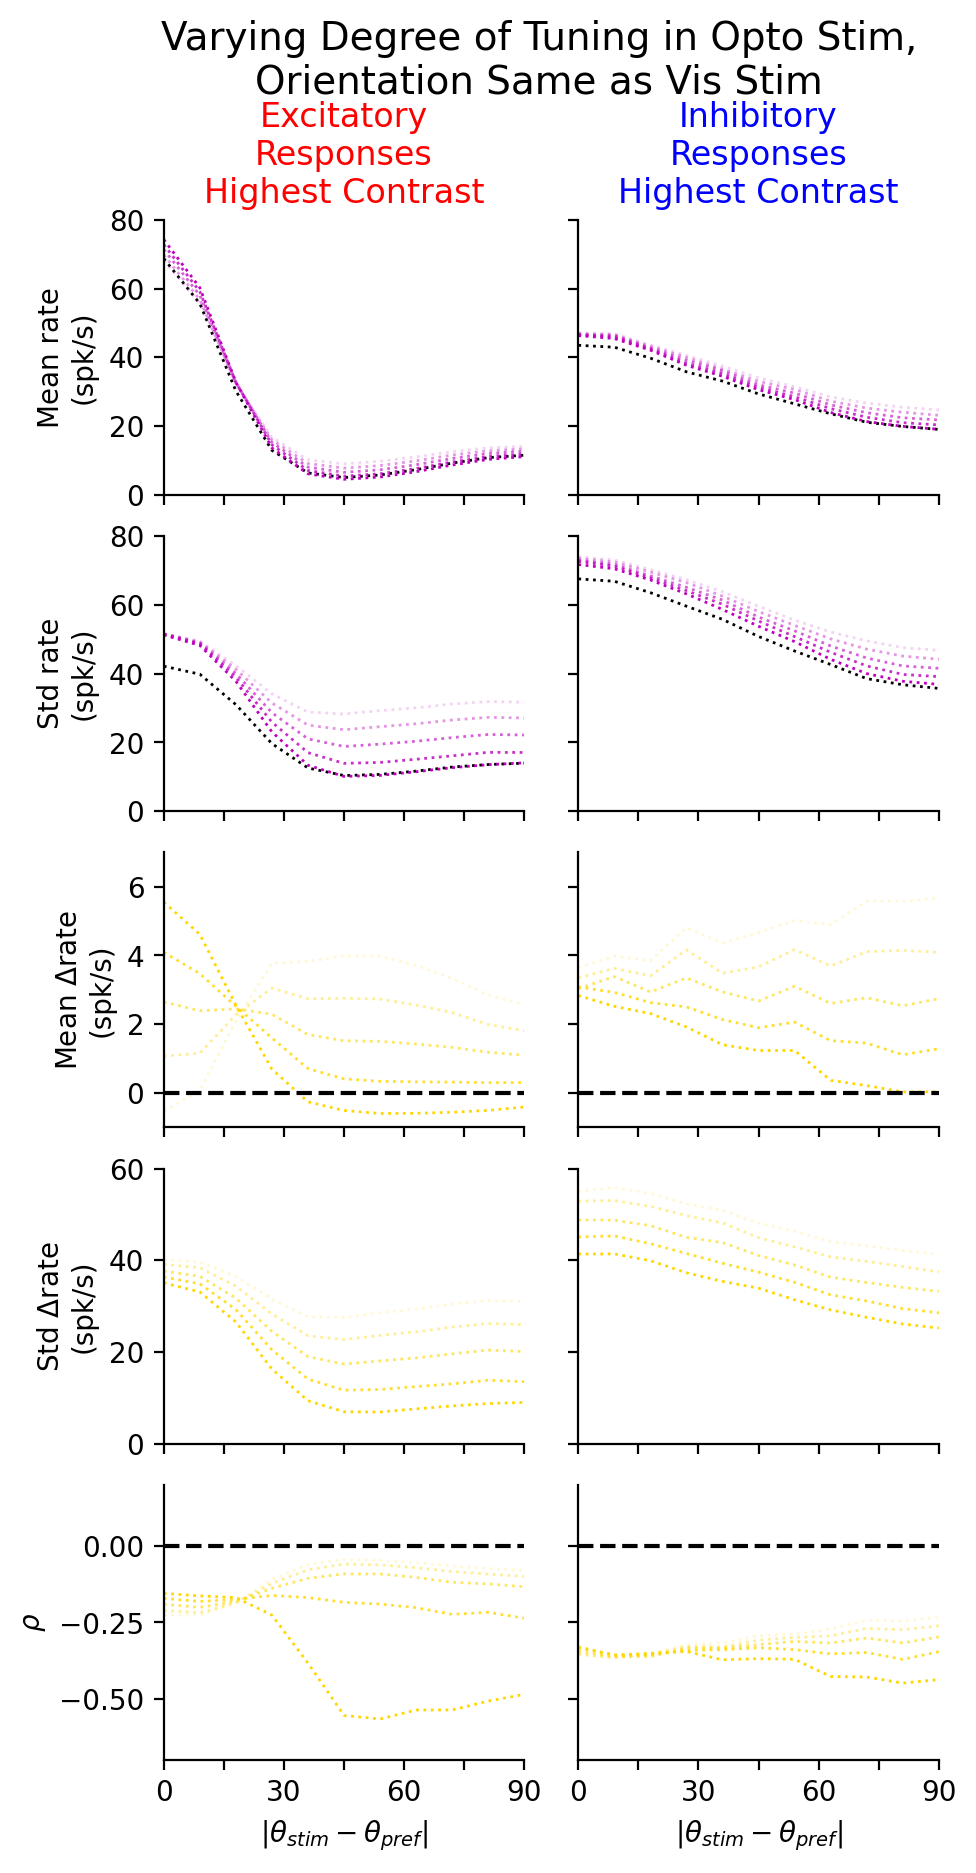

In [13]:
tunes = 100*np.arange(8+1)/8

nori = 20

oris = np.arange(nori//2+1) * 90/(nori/2)
def abs_ori(A):
    return 0.5*(A[:nori//2+1] + np.concatenate((A[0:1],A[-1:nori//2-1:-1])))

fig,axs = plt.subplots(5,2,figsize=(2.5*2,2*5),dpi=200,sharex='col',sharey='row')
fig.subplots_adjust(hspace=0.15,wspace=0.15)

axs[0,0].plot(oris,abs_ori(sim_tune_Epreds[0,:,0,0]),c='k',ls=':',lw=1)
axs[0,1].plot(oris,abs_ori(sim_tune_Ipreds[0,:,0,0]),c='k',ls=':',lw=1)
axs[1,0].plot(oris,abs_ori(sim_tune_Epreds[2,:,0,0]),c='k',ls=':',lw=1)
axs[1,1].plot(oris,abs_ori(sim_tune_Ipreds[2,:,0,0]),c='k',ls=':',lw=1)

for tidx in range(0,9,2):
    axs[0,0].plot(oris,abs_ori(sim_tune_Epreds[1,:,tidx,0]),
                     c='m',ls=':',lw=1,alpha=((tidx+1)/9)**0.8)
    axs[0,1].plot(oris,abs_ori(sim_tune_Ipreds[1,:,tidx,0]),
                     c='m',ls=':',lw=1,alpha=((tidx+1)/9)**0.8)
    axs[1,0].plot(oris,abs_ori(sim_tune_Epreds[3,:,tidx,0]),
                     c='m',ls=':',lw=1,alpha=((tidx+1)/9)**0.8)
    axs[1,1].plot(oris,abs_ori(sim_tune_Ipreds[3,:,tidx,0]),
                     c='m',ls=':',lw=1,alpha=((tidx+1)/9)**0.8)
    axs[2,0].plot(oris,abs_ori(sim_tune_Epreds[4,:,tidx,0]),
                     c='gold',ls=':',lw=1,alpha=((tidx+1)/9)**0.8)
    axs[2,1].plot(oris,abs_ori(sim_tune_Ipreds[4,:,tidx,0]),
                     c='gold',ls=':',lw=1,alpha=((tidx+1)/9)**0.8)
    axs[3,0].plot(oris,abs_ori(sim_tune_Epreds[5,:,tidx,0]),
                     c='gold',ls=':',lw=1,alpha=((tidx+1)/9)**0.8)
    axs[3,1].plot(oris,abs_ori(sim_tune_Ipreds[5,:,tidx,0]),
                     c='gold',ls=':',lw=1,alpha=((tidx+1)/9)**0.8)
    axs[4,0].plot(oris,abs_ori(sim_tune_Epreds[6,:,tidx,0]),
                     c='gold',ls=':',lw=1,alpha=((tidx+1)/9)**0.8)
    axs[4,1].plot(oris,abs_ori(sim_tune_Ipreds[6,:,tidx,0]),
                     c='gold',ls=':',lw=1,alpha=((tidx+1)/9)**0.8)

for i in range(2):
    axs[2,i].axhline(0,c='k',ls='--')
    axs[4,i].axhline(0,c='k',ls='--')
    
# axs[0,0].legend()
# axs[1,0].legend()
# axs[2,0].legend()

for ax in axs.flat:
    ax.spines[['right', 'top']].set_visible(False)

nticks = 7
ticks = np.array(['{:.0f}'.format(ori) for ori in np.linspace(0,90,nticks)])
ticks[1::2] = ''
for i in range(2):
    axs[0,i].set_xticks(np.linspace(0,90,7),ticks)

axs[0,0].set_xlim(0,90)
axs[0,1].set_xlim(0,90)
axs[0,0].set_ylim(0,80)
axs[1,0].set_ylim(0,80)
axs[2,0].set_ylim(-1,7)
axs[3,0].set_ylim(0,60)
axs[4,0].set_ylim(-0.7,0.2)

axs[4,0].set_xlabel(r'$|\theta_{stim}-\theta_{pref}|$')
axs[4,1].set_xlabel(r'$|\theta_{stim}-\theta_{pref}|$')

axs[0,0].set_ylabel('Mean rate\n(spk/s)')
axs[1,0].set_ylabel('Std rate\n(spk/s)')
axs[2,0].set_ylabel(r'Mean $\Delta$rate'+'\n(spk/s)')
axs[3,0].set_ylabel(r'Std $\Delta$rate'+'\n(spk/s)')
axs[4,0].set_ylabel(r'$\rho$')

axs[0,0].set_title('Excitatory\nResponses\nHighest Contrast',color='r')
axs[0,1].set_title('Inhibitory\nResponses\nHighest Contrast',color='b')

fig.suptitle('Varying Degree of Tuning in Opto Stim,\nOrientation Same as Vis Stim',fontsize=14)

# fig.tight_layout()
fig.savefig('./../plots/opto_iso_tune_resp_stats_paper.pdf')

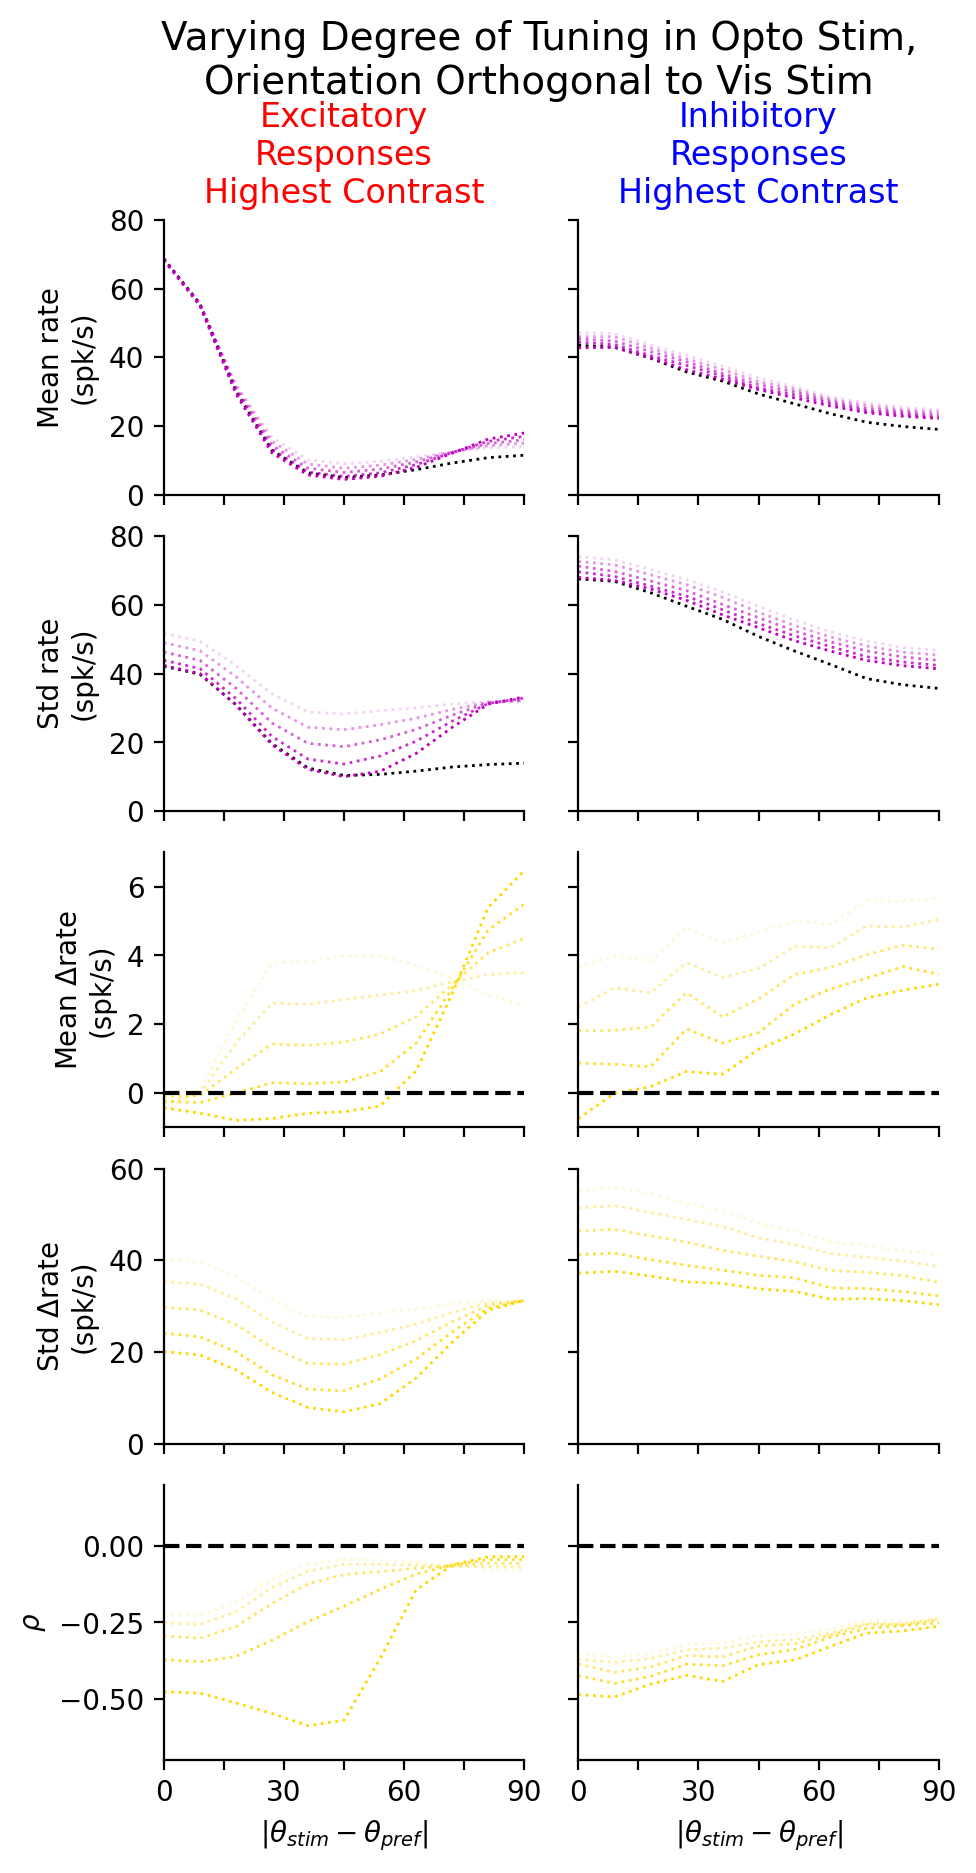

In [14]:
tunes = 100*np.arange(8+1)/8

nori = 20

oris = np.arange(nori//2+1) * 90/(nori/2)
def abs_ori(A):
    return 0.5*(A[:nori//2+1] + np.concatenate((A[0:1],A[-1:nori//2-1:-1])))

fig,axs = plt.subplots(5,2,figsize=(2.5*2,2*5),dpi=200,sharex='col',sharey='row')
fig.subplots_adjust(hspace=0.15,wspace=0.15)

axs[0,0].plot(oris,abs_ori(sim_tune_Epreds[0,:,0,0]),c='k',ls=':',lw=1)
axs[0,1].plot(oris,abs_ori(sim_tune_Ipreds[0,:,0,0]),c='k',ls=':',lw=1)
axs[1,0].plot(oris,abs_ori(sim_tune_Epreds[2,:,0,0]),c='k',ls=':',lw=1)
axs[1,1].plot(oris,abs_ori(sim_tune_Ipreds[2,:,0,0]),c='k',ls=':',lw=1)

for tidx in range(0,9,2):
    axs[0,0].plot(oris,abs_ori(sim_tune_Epreds[1,:,tidx,1]),
                     c='m',ls=':',lw=1,alpha=((tidx+1)/9)**0.8)
    axs[0,1].plot(oris,abs_ori(sim_tune_Ipreds[1,:,tidx,1]),
                     c='m',ls=':',lw=1,alpha=((tidx+1)/9)**0.8)
    axs[1,0].plot(oris,abs_ori(sim_tune_Epreds[3,:,tidx,1]),
                     c='m',ls=':',lw=1,alpha=((tidx+1)/9)**0.8)
    axs[1,1].plot(oris,abs_ori(sim_tune_Ipreds[3,:,tidx,1]),
                     c='m',ls=':',lw=1,alpha=((tidx+1)/9)**0.8)
    axs[2,0].plot(oris,abs_ori(sim_tune_Epreds[4,:,tidx,1]),
                     c='gold',ls=':',lw=1,alpha=((tidx+1)/9)**0.8)
    axs[2,1].plot(oris,abs_ori(sim_tune_Ipreds[4,:,tidx,1]),
                     c='gold',ls=':',lw=1,alpha=((tidx+1)/9)**0.8)
    axs[3,0].plot(oris,abs_ori(sim_tune_Epreds[5,:,tidx,1]),
                     c='gold',ls=':',lw=1,alpha=((tidx+1)/9)**0.8)
    axs[3,1].plot(oris,abs_ori(sim_tune_Ipreds[5,:,tidx,1]),
                     c='gold',ls=':',lw=1,alpha=((tidx+1)/9)**0.8)
    axs[4,0].plot(oris,abs_ori(sim_tune_Epreds[6,:,tidx,1]),
                     c='gold',ls=':',lw=1,alpha=((tidx+1)/9)**0.8)
    axs[4,1].plot(oris,abs_ori(sim_tune_Ipreds[6,:,tidx,1]),
                     c='gold',ls=':',lw=1,alpha=((tidx+1)/9)**0.8)

for i in range(2):
    axs[2,i].axhline(0,c='k',ls='--')
    axs[4,i].axhline(0,c='k',ls='--')
    
# axs[0,0].legend()
# axs[1,0].legend()
# axs[2,0].legend()

for ax in axs.flat:
    ax.spines[['right', 'top']].set_visible(False)

nticks = 7
ticks = np.array(['{:.0f}'.format(ori) for ori in np.linspace(0,90,nticks)])
ticks[1::2] = ''
for i in range(2):
    axs[0,i].set_xticks(np.linspace(0,90,7),ticks)

axs[0,0].set_xlim(0,90)
axs[0,1].set_xlim(0,90)
axs[0,0].set_ylim(0,80)
axs[1,0].set_ylim(0,80)
axs[2,0].set_ylim(-1,7)
axs[3,0].set_ylim(0,60)
axs[4,0].set_ylim(-0.7,0.2)

axs[4,0].set_xlabel(r'$|\theta_{stim}-\theta_{pref}|$')
axs[4,1].set_xlabel(r'$|\theta_{stim}-\theta_{pref}|$')

axs[0,0].set_ylabel('Mean rate\n(spk/s)')
axs[1,0].set_ylabel('Std rate\n(spk/s)')
axs[2,0].set_ylabel(r'Mean $\Delta$rate'+'\n(spk/s)')
axs[3,0].set_ylabel(r'Std $\Delta$rate'+'\n(spk/s)')
axs[4,0].set_ylabel(r'$\rho$')

axs[0,0].set_title('Excitatory\nResponses\nHighest Contrast',color='r')
axs[0,1].set_title('Inhibitory\nResponses\nHighest Contrast',color='b')

fig.suptitle('Varying Degree of Tuning in Opto Stim,\nOrientation Orthogonal to Vis Stim',fontsize=14)

# fig.tight_layout()
fig.savefig('./../plots/opto_ortho_tune_resp_stats_paper.pdf')

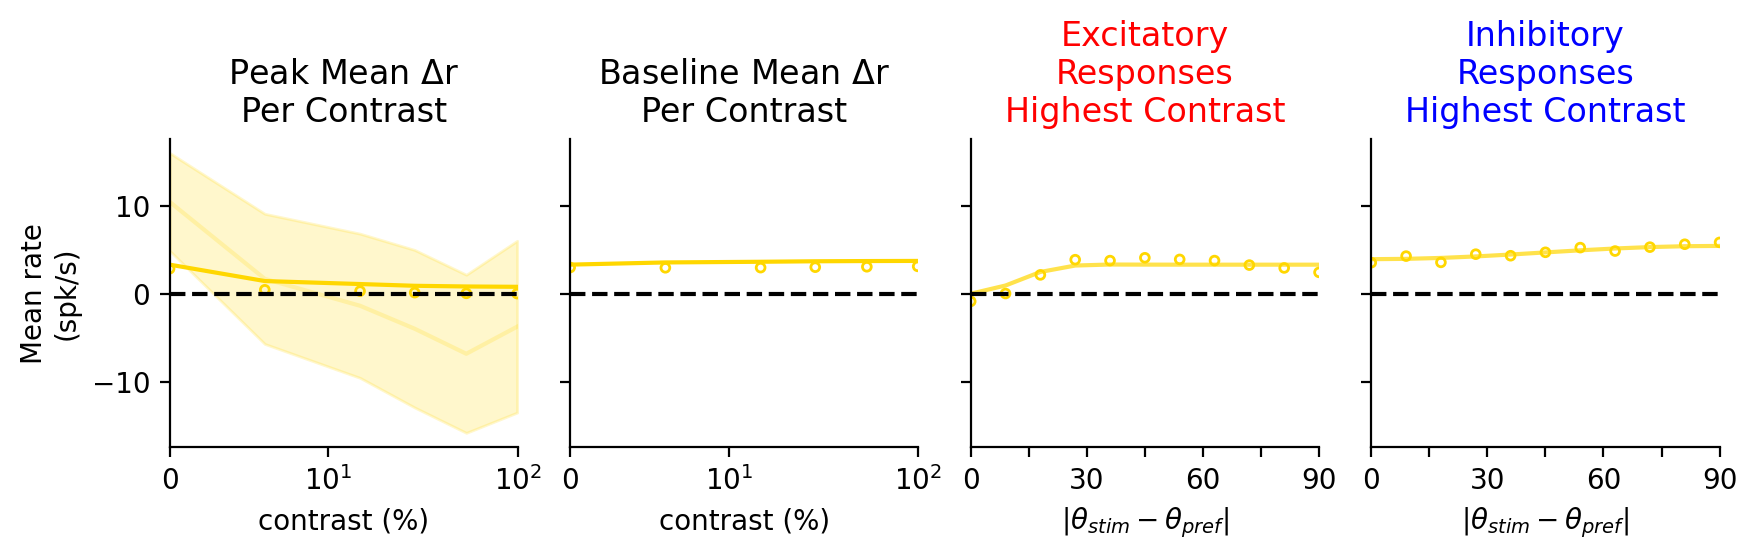

In [539]:
with open('./data_moments'+'.pkl', 'rb') as handle:
    data_preds = np.transpose(pickle.load(handle)[1],(1,0,2))
with open('./data_contrasts'+'.pkl', 'rb') as handle:
    cons = pickle.load(handle)[1]
    
nori = 20

oris = np.arange(nori//2+1) * 90/(nori/2)
def abs_ori(A):
    return 0.5*(A[:nori//2+1] + np.concatenate((A[0:1],A[-1:nori//2-1:-1])))

cidx = 5

fig,axs = plt.subplots(1,4,figsize=(2.5*4,2*1),dpi=200,sharex='col',sharey='row')
fig.subplots_adjust(hspace=0.15,wspace=0.15)

axs[0].plot(cons,data_preds[:,1,0]-data_preds[:,0,0],color='gold',alpha=0.2)
axs[0].fill_between(cons,data_preds[:,1,0]-data_preds[:,0,0]-np.sqrt(data_preds[:,0,1]**2+data_preds[:,1,1]**2),
    data_preds[:,1,0]-data_preds[:,0,0]+np.sqrt(data_preds[:,0,1]**2+data_preds[:,1,1]**2),color='gold',alpha=0.2)
axs[0].plot(cons,dmft_preds[:,6],c='gold',ls='-')
axs[0].scatter(cons,sim_preds[:,6],edgecolors='gold',facecolors='none',marker='o',s=10)

axs[1].plot(cons,dmft_preds[:,7],c='gold',ls='-')
axs[1].scatter(cons,sim_preds[:,7],edgecolors='gold',facecolors='none',marker='o',s=10)

axs[2].plot(oris,abs_ori(dmft_Epreds[cidx,6,:]),c='gold',ls='-',alpha=0.7)
axs[2].scatter(oris,abs_ori(sim_Epreds[cidx,6,:]),
    edgecolors='gold',facecolors='none',marker='o',s=10)

axs[3].plot(oris,abs_ori(dmft_Ipreds[cidx,6,:]),c='gold',ls='-',alpha=0.7)
axs[3].scatter(oris,abs_ori(sim_Ipreds[cidx,6,:]),
    edgecolors='gold',facecolors='none',marker='o',s=10)

for i in range(4):
    axs[i].axhline(0,c='k',ls='--')
    
# axs[0,0].legend()
# axs[1,0].legend()
# axs[2,0].legend()

for ax in axs.flat:
    ax.spines[['right', 'top']].set_visible(False)

axs[0].set_xscale('symlog', linthresh=12)
axs[1].set_xscale('symlog', linthresh=12)
nticks = 7
ticks = np.array(['{:.0f}'.format(ori) for ori in np.linspace(0,90,nticks)])
ticks[1::2] = ''
for i in range(2,4):
    axs[i].set_xticks(np.linspace(0,90,7),ticks)

axs[0].set_xlim(0,100)
axs[1].set_xlim(0,100)
axs[2].set_xlim(0,90)
axs[3].set_xlim(0,90)
# axs[0].set_ylim(-1,7)

axs[0].set_xlabel('contrast (%)')
axs[1].set_xlabel('contrast (%)')
axs[2].set_xlabel(r'$|\theta_{stim}-\theta_{pref}|$')
axs[3].set_xlabel(r'$|\theta_{stim}-\theta_{pref}|$')

axs[0].set_ylabel('Mean rate\n(spk/s)')

axs[0].set_title(r'Peak Mean $\Delta$r'+'\nPer Contrast',color='k')
axs[1].set_title(r'Baseline Mean $\Delta$r'+'\nPer Contrast',color='k')
axs[2].set_title('Excitatory\nResponses\nHighest Contrast',color='r')
axs[3].set_title('Inhibitory\nResponses\nHighest Contrast',color='b')

# fig.tight_layout()
fig.savefig('./../plots/delta_rate_stats_paper.pdf')

In [621]:
from sklearn.decomposition import PCA

pca_dim = 5

sim_mult_ori_rs = np.zeros((6,80,5,10000))

for i,c_idx in enumerate([0,1,2,3,4,5]):
    for j,Lx in enumerate(np.arange(4+1)/4):
        res_file = './../results/mult_ori_id_None'
        if not np.isclose(Lx,1.0):
            res_file = res_file + '_Lx{:.2f}'.format(Lx)
        try:
            with open(res_file+'_c_{:d}'.format(c_idx)+'.pkl','rb') as\
                    handle:
                res_dict = pickle.load(handle)
            
            sim_mult_ori_rs[i,:,j,:] = res_dict['rates'][:,1,:]
        except:
            sim_mult_ori_rs[i,:,j,:] = np.nan
        
pca = PCA(n_components=pca_dim)
pca.fit(sim_mult_ori_rs.reshape((-1,10000)))

sim_mult_ori_rs = pca.fit_transform(sim_mult_ori_rs.reshape((-1,10000))).reshape((6,80,5,pca_dim))

print(pca.explained_variance_ratio_)

[0.17144633 0.16007232 0.14903317 0.11797464 0.09856827]


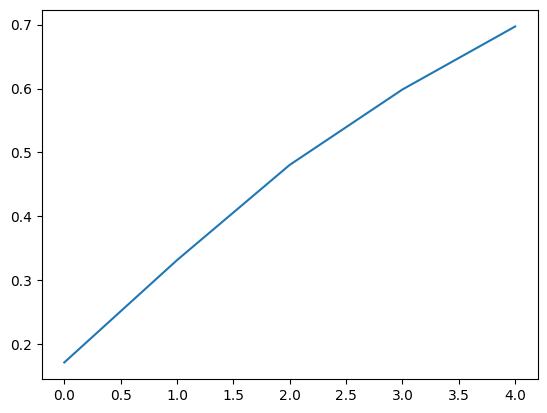

In [629]:
plt.plot(np.cumsum([0.17144633, 0.16007232, 0.14903317, 0.11797464, 0.09856827]))

In [622]:
np.save('opto_rates_pca.npy',sim_mult_ori_rs)

/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_23801/3112799093.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(sim_mult_ori_rs[c_idx,:,o_idx,0],


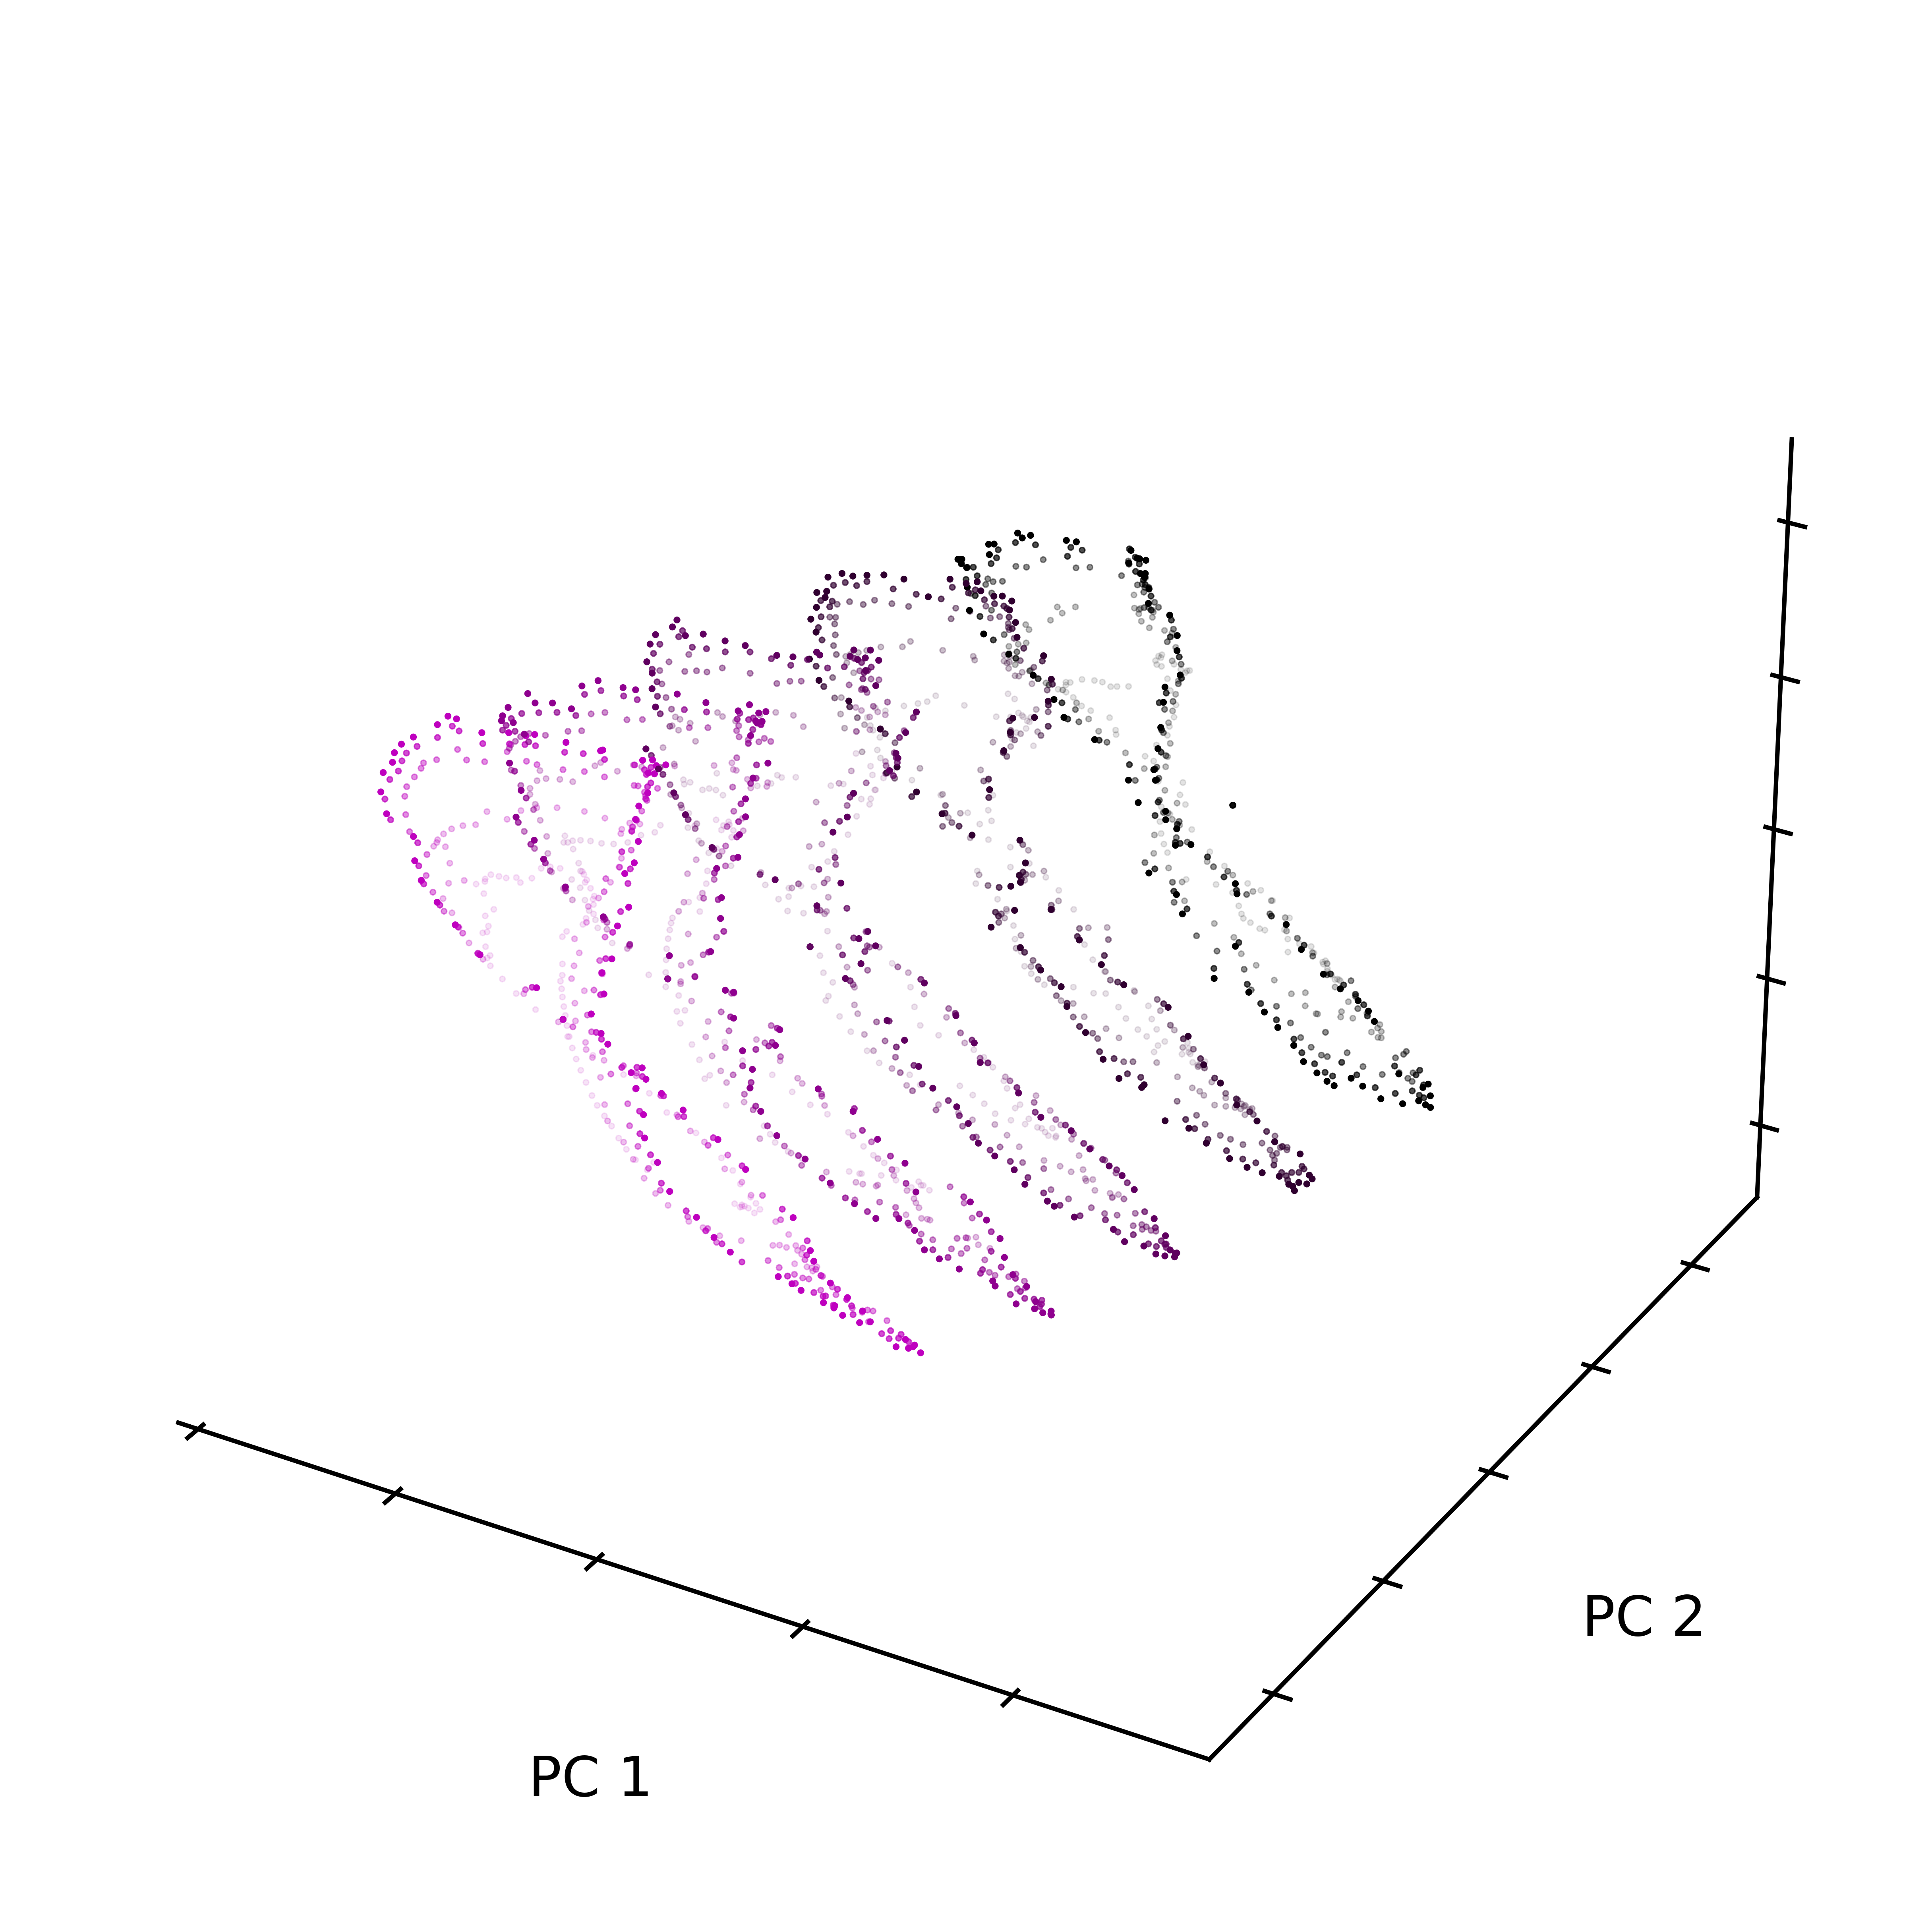

In [665]:
fig,ax = plt.subplots(1,1,figsize=(6,6),dpi=1000,subplot_kw=dict(projection='3d'))

s = 1
for c_idx in range(6):
    for o_idx in range(5):
        ax.scatter(sim_mult_ori_rs[c_idx,:,o_idx,0],
                   sim_mult_ori_rs[c_idx,:,o_idx,1],
                   sim_mult_ori_rs[c_idx,:,o_idx,2],s=s,lw=s/4,c=(0.75*o_idx/4,0,0.75*o_idx/4),alpha=((c_idx+1)/6)**2)

for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    # make the panes transparent
    axis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    axis._axinfo["grid"]['color'] =  (1,1,1,0)
    # remove axis ticks
    axis.set_ticklabels([])
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
# ax.zaxis.labelpad=-4

# fig.tight_layout()
fig.savefig('./../plots/opto_geom_paper.pdf')

# Poster Figures

# Plot Distributions of Responses

In [3]:
with open('./data_monk_rates'+'.txt', 'rb') as handle:
    data_rates_raw = np.loadtxt(handle)
    
idxs = np.unique(data_rates_raw[:,0])
cons = np.unique(data_rates_raw[:,1])
lsrs = np.unique(data_rates_raw[:,2])

data_rates = np.zeros((len(idxs),len(cons),len(lsrs)))

for i,idx in enumerate(idxs):
    for j,con in enumerate(cons):
        for k,lsr in enumerate(lsrs):
            data_rates[i,j,k] = data_rates_raw[np.logical_and(np.logical_and(data_rates_raw[:,0]==idx,
                                                                             data_rates_raw[:,1]==con),
                                                                             data_rates_raw[:,2]==lsr),3]

In [18]:
su_idxs = np.array([1,5,7,8,9,13,15,16,17,18,19,21,23,25,27,28,29,33,35,38,43,46,48,52,54,55,56,58,60,61,63,65,67,69,71,74,75,81,83,85,87,89,90,91,95,97,98,99,100,102,103,105,106,108,110]) - 1
mu_idxs = np.setdiff1d(np.arange(111),su_idxs)

In [14]:
def cdf(A,min,max,N=500):
    bin_edges=np.linspace(min,max,N)
    hist,_=np.histogram(A,bin_edges)#,normed=True)
    bin_mean=0.5*(bin_edges[0:-1]+bin_edges[1::])
    spacings=np.diff(bin_edges)[0];
    hist=hist/np.sum(hist*spacings)
    return bin_mean,np.cumsum(spacings*hist)

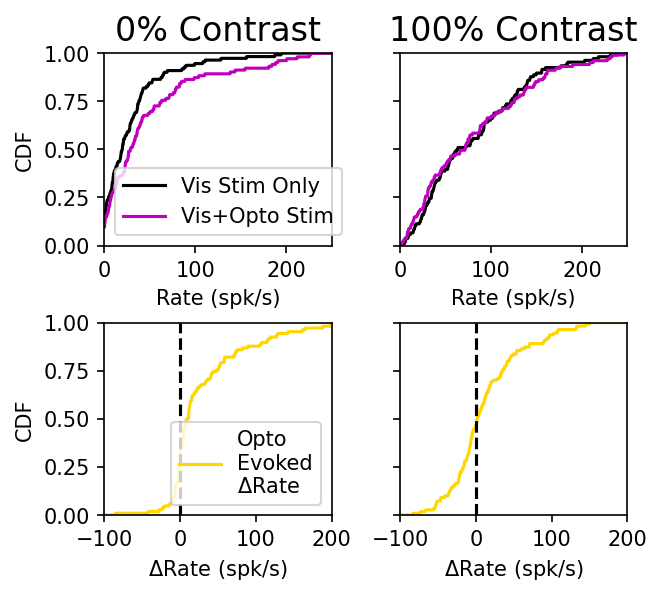

In [15]:
fig, axs = plt.subplots(2,2, figsize=(2.25*2,2*2), dpi=150, sharex='row', sharey=True)
fig.subplots_adjust(hspace = .4, wspace=.3)

rmax = 250
Δrmin = -100
Δrmax = 200

axs[0,0].plot(*cdf(data_rates[:, 0, 0],0,rmax),'k',label='Vis Stim Only')
axs[0,0].plot(*cdf(data_rates[:, 0,-1],0,rmax),'m',label='Vis+Opto Stim')

axs[0,1].plot(*cdf(data_rates[:,-1, 0],0,rmax),'k')
axs[0,1].plot(*cdf(data_rates[:,-1,-1],0,rmax),'m')

axs[1,0].plot(*cdf(data_rates[:, 0,-1]-data_rates[:, 0, 0],Δrmin,Δrmax),'gold',label='Opto\nEvoked\n'+r'$\Delta$Rate')
axs[1,0].axvline(0,c='k',ls='--')

axs[1,1].plot(*cdf(data_rates[:,-1,-1]-data_rates[:,-1, 0],Δrmin,Δrmax),'gold')
axs[1,1].axvline(0,c='k',ls='--')

axs[0,0].legend()
axs[1,0].legend()

axs[0,0].set_xlim(0,rmax)
axs[1,0].set_xlim(Δrmin,Δrmax)
axs[0,0].set_ylim(0,1)
axs[1,0].set_ylim(0,1)

axs[1,0].set_xlabel('contrast (%)')

axs[0,0].set_xlabel('Rate (spk/s)')
axs[0,1].set_xlabel('Rate (spk/s)')
axs[1,0].set_xlabel(r'$\Delta$Rate (spk/s)')
axs[1,1].set_xlabel(r'$\Delta$Rate (spk/s)')
axs[0,0].set_ylabel('CDF')
axs[1,0].set_ylabel('CDF')
axs[0,0].set_title('0% Contrast',fontsize=16)
axs[0,1].set_title('100% Contrast',fontsize=16)

# fig.tight_layout()
fig.savefig('./../plots/data_cdfs.pdf')

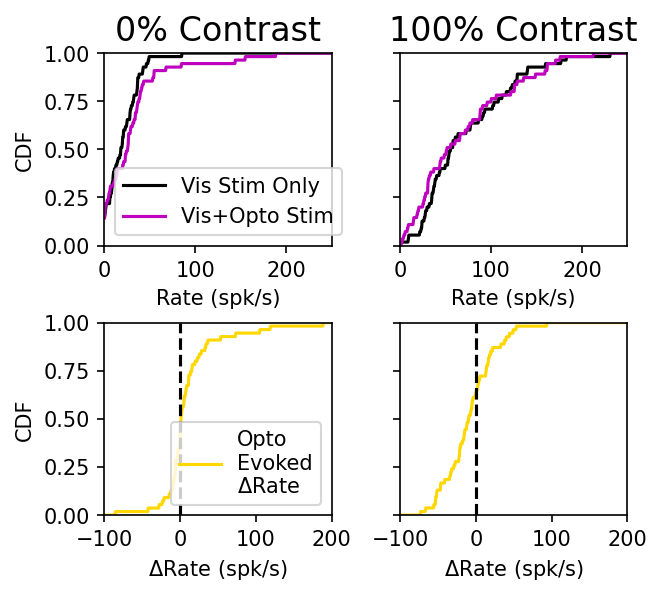

In [22]:
fig, axs = plt.subplots(2,2, figsize=(2.25*2,2*2), dpi=150, sharex='row', sharey=True)
fig.subplots_adjust(hspace = .4, wspace=.3)

rmax = 250
Δrmin = -100
Δrmax = 200

axs[0,0].plot(*cdf(data_rates[su_idxs, 0, 0],0,rmax),'k',label='Vis Stim Only')
axs[0,0].plot(*cdf(data_rates[su_idxs, 0,-1],0,rmax),'m',label='Vis+Opto Stim')

axs[0,1].plot(*cdf(data_rates[su_idxs,-1, 0],0,rmax),'k')
axs[0,1].plot(*cdf(data_rates[su_idxs,-1,-1],0,rmax),'m')

axs[1,0].plot(*cdf(data_rates[su_idxs, 0,-1]-data_rates[su_idxs, 0, 0],Δrmin,Δrmax),'gold',label='Opto\nEvoked\n'+r'$\Delta$Rate')
axs[1,0].axvline(0,c='k',ls='--')

axs[1,1].plot(*cdf(data_rates[su_idxs,-1,-1]-data_rates[su_idxs,-1, 0],Δrmin,Δrmax),'gold')
axs[1,1].axvline(0,c='k',ls='--')

axs[0,0].legend()
axs[1,0].legend()

axs[0,0].set_xlim(0,rmax)
axs[1,0].set_xlim(Δrmin,Δrmax)
axs[0,0].set_ylim(0,1)
axs[1,0].set_ylim(0,1)

axs[1,0].set_xlabel('contrast (%)')

axs[0,0].set_xlabel('Rate (spk/s)')
axs[0,1].set_xlabel('Rate (spk/s)')
axs[1,0].set_xlabel(r'$\Delta$Rate (spk/s)')
axs[1,1].set_xlabel(r'$\Delta$Rate (spk/s)')
axs[0,0].set_ylabel('CDF')
axs[1,0].set_ylabel('CDF')
axs[0,0].set_title('0% Contrast',fontsize=16)
axs[0,1].set_title('100% Contrast',fontsize=16)

# fig.tight_layout()
fig.savefig('./../plots/data_sing_unit_cdfs.pdf')

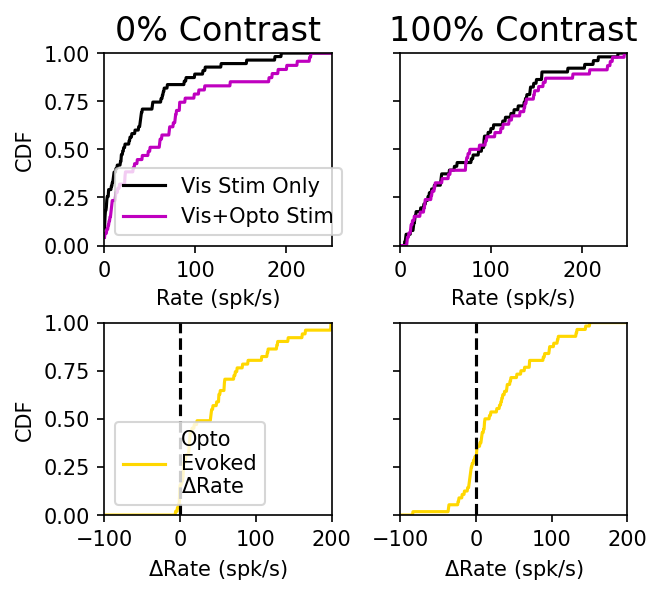

In [23]:
fig, axs = plt.subplots(2,2, figsize=(2.25*2,2*2), dpi=150, sharex='row', sharey=True)
fig.subplots_adjust(hspace = .4, wspace=.3)

rmax = 250
Δrmin = -100
Δrmax = 200

axs[0,0].plot(*cdf(data_rates[mu_idxs, 0, 0],0,rmax),'k',label='Vis Stim Only')
axs[0,0].plot(*cdf(data_rates[mu_idxs, 0,-1],0,rmax),'m',label='Vis+Opto Stim')

axs[0,1].plot(*cdf(data_rates[mu_idxs,-1, 0],0,rmax),'k')
axs[0,1].plot(*cdf(data_rates[mu_idxs,-1,-1],0,rmax),'m')

axs[1,0].plot(*cdf(data_rates[mu_idxs, 0,-1]-data_rates[mu_idxs, 0, 0],Δrmin,Δrmax),'gold',label='Opto\nEvoked\n'+r'$\Delta$Rate')
axs[1,0].axvline(0,c='k',ls='--')

axs[1,1].plot(*cdf(data_rates[mu_idxs,-1,-1]-data_rates[mu_idxs,-1, 0],Δrmin,Δrmax),'gold')
axs[1,1].axvline(0,c='k',ls='--')

axs[0,0].legend()
axs[1,0].legend()

axs[0,0].set_xlim(0,rmax)
axs[1,0].set_xlim(Δrmin,Δrmax)
axs[0,0].set_ylim(0,1)
axs[1,0].set_ylim(0,1)

axs[1,0].set_xlabel('contrast (%)')

axs[0,0].set_xlabel('Rate (spk/s)')
axs[0,1].set_xlabel('Rate (spk/s)')
axs[1,0].set_xlabel(r'$\Delta$Rate (spk/s)')
axs[1,1].set_xlabel(r'$\Delta$Rate (spk/s)')
axs[0,0].set_ylabel('CDF')
axs[1,0].set_ylabel('CDF')
axs[0,0].set_title('0% Contrast',fontsize=16)
axs[0,1].set_title('100% Contrast',fontsize=16)

# fig.tight_layout()
fig.savefig('./../plots/data_sing_mult_cdfs.pdf')

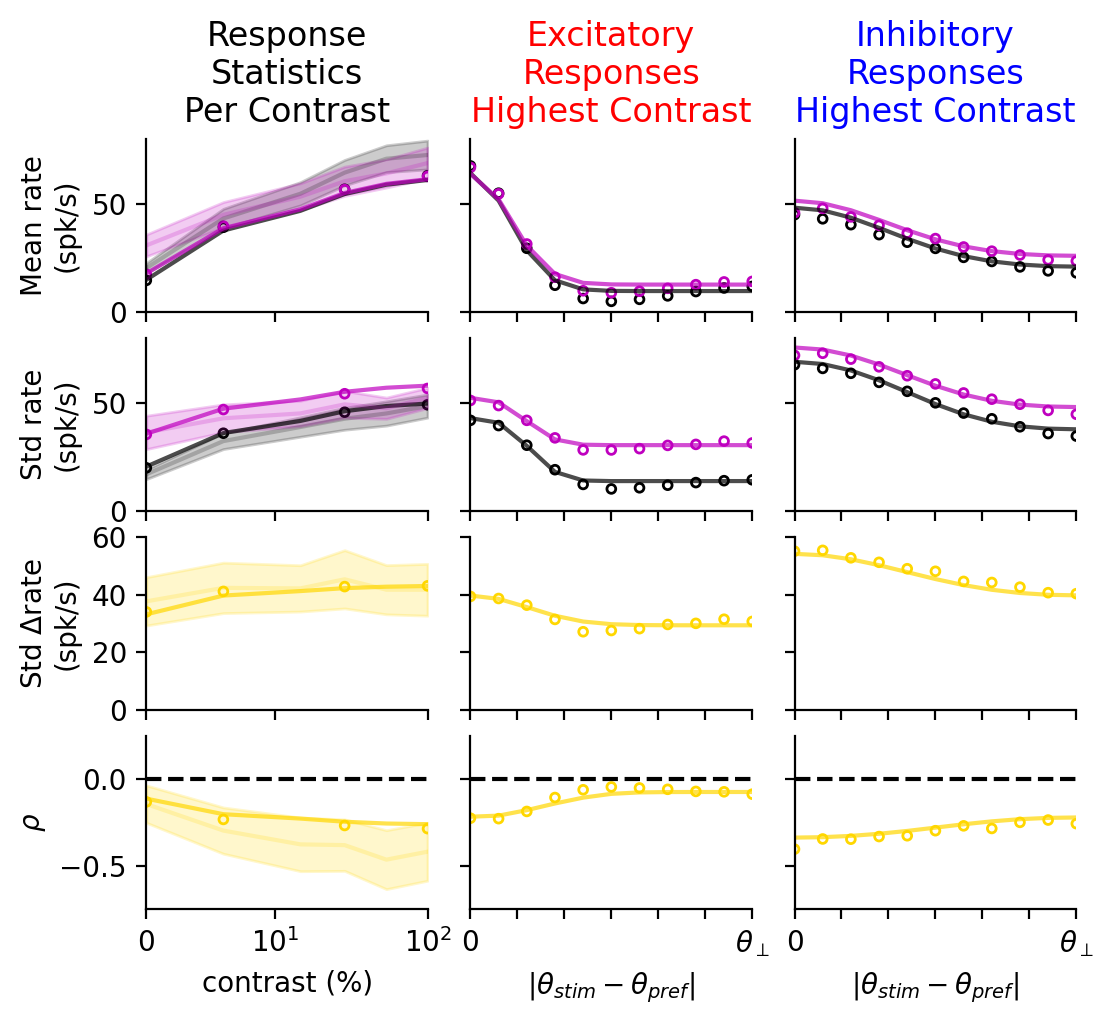

In [595]:
with open('./data_moments'+'.pkl', 'rb') as handle:
    data_preds = np.transpose(pickle.load(handle)[1],(1,0,2))
with open('./data_contrasts'+'.pkl', 'rb') as handle:
    cons = pickle.load(handle)[1]
    
nori = 20

oris = np.arange(nori//2+1) * 90/(nori/2)
def abs_ori(A):
    return 0.5*(A[:nori//2+1] + np.concatenate((A[0:1],A[-1:nori//2-1:-1])))

cidx = 5

fig,axs = plt.subplots(4,3,figsize=(2*3,1.25*4),dpi=200,sharex='col',sharey='row')
fig.subplots_adjust(hspace=0.15,wspace=0.15)

axs[0,0].plot([-1],[-1],label=r'Data $\pm$ SEM')
axs[0,0].plot([-1],[-1],label='Simulation')
axs[0,0].plot([-1],[-1],label='Theory')
axs[0,0].plot(cons,data_preds[:,0,0],color='k',alpha=0.2,label='Vis Stim Only')
axs[0,0].fill_between(cons,data_preds[:,0,0]-data_preds[:,0,1],
    data_preds[:,0,0]+data_preds[:,0,1],color='k',alpha=0.2,label='Vis Stim Only')
axs[0,0].plot(cons,dmft_preds[:,0],c='k',ls='-',label='Vis Stim Only',alpha=0.7)
axs[0,0].scatter(cons,sim_preds[:,0],edgecolors='k',facecolors='none',marker='o',s=10,label='Vis Stim Only')
axs[0,0].plot(cons,data_preds[:,1,0],color='m',alpha=0.2)
axs[0,0].fill_between(cons,data_preds[:,1,0]-data_preds[:,1,1],
    data_preds[:,1,0]+data_preds[:,1,1],color='m',alpha=0.2)
axs[0,0].plot(cons,dmft_preds[:,1],c='m',ls='-',alpha=0.7)
axs[0,0].scatter(cons,sim_preds[:,1],edgecolors='m',facecolors='none',marker='o',s=10)

axs[1,0].plot(cons,data_preds[:,2,0],color='k',alpha=0.2)
axs[1,0].fill_between(cons,data_preds[:,2,0]-data_preds[:,2,1],
    data_preds[:,2,0]+data_preds[:,2,1],color='k',alpha=0.2)
axs[1,0].plot(cons,dmft_preds[:,2],c='k',ls='-',alpha=0.7)
axs[1,0].scatter(cons,sim_preds[:,2],edgecolors='k',facecolors='none',marker='o',s=10)
axs[1,0].plot(cons,data_preds[:,3,0],color='m',alpha=0.2,label='Vis+Opto Stim')
axs[1,0].fill_between(cons,data_preds[:,3,0]-data_preds[:,3,1],
    data_preds[:,3,0]+data_preds[:,3,1],color='m',alpha=0.2,label='Vis+Opto Stim')
axs[1,0].plot(cons,dmft_preds[:,3],c='m',ls='-',label='Vis+Opto Stim',alpha=0.7)
axs[1,0].scatter(cons,sim_preds[:,3],edgecolors='m',facecolors='none',marker='o',s=10,label='Vis+Opto Stim')

axs[2,0].plot(cons,data_preds[:,4,0],color='gold',alpha=0.2,label=r'Opto Evoked $\Delta$Rate')
axs[2,0].fill_between(cons,data_preds[:,4,0]-data_preds[:,4,1],
    data_preds[:,4,0]+data_preds[:,4,1],color='gold',alpha=0.2,label=r'Opto Evoked $\Delta$Rate')
axs[2,0].plot(cons,dmft_preds[:,4],c='gold',ls='-',label=r'Opto Evoked $\Delta$Rate',alpha=0.7)
axs[2,0].scatter(cons,sim_preds[:,4],edgecolors='gold',facecolors='none',marker='o',s=10,label=r'Opto Evoked $\Delta$Rate')

axs[3,0].plot(cons,data_preds[:,5,0],color='gold',alpha=0.2)
axs[3,0].fill_between(cons,data_preds[:,5,0]-data_preds[:,5,1],
    data_preds[:,5,0]+data_preds[:,5,1],color='gold',alpha=0.2)
axs[3,0].plot(cons,dmft_preds[:,5],c='gold',ls='-',alpha=0.7)
axs[3,0].scatter(cons,sim_preds[:,5],edgecolors='gold',facecolors='none',marker='o',s=10)

axs[0,1].plot(oris,abs_ori(dmft_Epreds[cidx,0,:]),c='k',ls='-',alpha=0.7)
axs[0,1].scatter(oris,abs_ori(sim_Epreds[cidx,0,:]),#abs_ori(sim_Epred_errs[cidx,0,:]),
    edgecolors='k',facecolors='none',marker='o',s=10)
axs[0,1].plot(oris,abs_ori(dmft_Epreds[cidx,1,:]),c='m',ls='-',alpha=0.7)
axs[0,1].scatter(oris,abs_ori(sim_Epreds[cidx,1,:]),#abs_ori(sim_Epred_errs[cidx,1,:]),
    edgecolors='m',facecolors='none',marker='o',s=10)

axs[0,2].plot(oris,abs_ori(dmft_Ipreds[cidx,0,:]),c='k',ls='-',alpha=0.7)
axs[0,2].scatter(oris,abs_ori(sim_Ipreds[cidx,0,:]),#abs_ori(sim_Ipred_errs[cidx,0,:]),
    edgecolors='k',facecolors='none',marker='o',s=10)
axs[0,2].plot(oris,abs_ori(dmft_Ipreds[cidx,1,:]),c='m',ls='-',alpha=0.7)
axs[0,2].scatter(oris,abs_ori(sim_Ipreds[cidx,1,:]),#abs_ori(sim_Ipred_errs[cidx,1,:]),
    edgecolors='m',facecolors='none',marker='o',s=10)

axs[1,1].plot(oris,abs_ori(dmft_Epreds[cidx,2,:]),c='k',ls='-',alpha=0.7)
axs[1,1].scatter(oris,abs_ori(sim_Epreds[cidx,2,:]),#abs_ori(sim_Epred_errs[cidx,2,:]),
    edgecolors='k',facecolors='none',marker='o',s=10)
axs[1,1].plot(oris,abs_ori(dmft_Epreds[cidx,3,:]),c='m',ls='-',alpha=0.7)
axs[1,1].scatter(oris,abs_ori(sim_Epreds[cidx,3,:]),#abs_ori(sim_Epred_errs[cidx,3,:]),
    edgecolors='m',facecolors='none',marker='o',s=10)

axs[1,2].plot(oris,abs_ori(dmft_Ipreds[cidx,2,:]),c='k',ls='-',alpha=0.7)
axs[1,2].scatter(oris,abs_ori(sim_Ipreds[cidx,2,:]),#abs_ori(sim_Ipred_errs[cidx,2,:]),
    edgecolors='k',facecolors='none',marker='o',s=10)
axs[1,2].plot(oris,abs_ori(dmft_Ipreds[cidx,3,:]),c='m',ls='-',alpha=0.7)
axs[1,2].scatter(oris,abs_ori(sim_Ipreds[cidx,3,:]),#abs_ori(sim_Ipred_errs[cidx,3,:]),
    edgecolors='m',facecolors='none',marker='o',s=10)

axs[2,1].plot(oris,abs_ori(dmft_Epreds[cidx,4,:]),c='gold',ls='-',alpha=0.7)
axs[2,1].scatter(oris,abs_ori(sim_Epreds[cidx,4,:]),#abs_ori(sim_Epred_errs[cidx,4,:]),
    edgecolors='gold',facecolors='none',marker='o',s=10)

axs[2,2].plot(oris,abs_ori(dmft_Ipreds[cidx,4,:]),c='gold',ls='-',alpha=0.7)
axs[2,2].scatter(oris,abs_ori(sim_Ipreds[cidx,4,:]),#abs_ori(sim_Ipred_errs[cidx,4,:]),
    edgecolors='gold',facecolors='none',marker='o',s=10)

axs[3,1].plot(oris,abs_ori(dmft_Epreds[cidx,5,:]),c='gold',ls='-',alpha=0.7)
axs[3,1].scatter(oris,abs_ori(sim_Epreds[cidx,5,:]),#abs_ori(sim_Epred_errs[cidx,5,:]),
    edgecolors='gold',facecolors='none',marker='o',s=10)

axs[3,2].plot(oris,abs_ori(dmft_Ipreds[cidx,5,:]),c='gold',ls='-',alpha=0.7)
axs[3,2].scatter(oris,abs_ori(sim_Ipreds[cidx,5,:]),#abs_ori(sim_Ipred_errs[cidx,5,:]),
    edgecolors='gold',facecolors='none',marker='o',s=10)

for i in range(3):
    axs[3,i].axhline(0,c='k',ls='--')
    
# axs[0,0].legend()
# axs[1,0].legend()
# axs[2,0].legend()

for ax in axs.flat:
    ax.spines[['right', 'top']].set_visible(False)

axs[0,0].set_xscale('symlog', linthresh=12)
nticks = 7
# ticks = np.array(['{:.0f}'.format(ori) for ori in np.linspace(0,90,nticks)])
# ticks[1::2] = ''
ticks = np.concatenate(([r'0'],np.array([r'',]*(nticks-2)),[r'$\theta_\perp$']))
for i in range(1,3):
    axs[0,i].set_xticks(ticks=np.linspace(0,90,nticks),labels=ticks)

axs[0,0].set_xlim(0,100)
axs[0,1].set_xlim(0,90)
axs[0,2].set_xlim(0,90)
axs[0,0].set_ylim(0,80)
axs[1,0].set_ylim(0,80)
axs[2,0].set_ylim(0,60)
axs[3,0].set_ylim(-0.75,0.25)

axs[3,0].set_xlabel('contrast (%)')
axs[3,1].set_xlabel(r'$|\theta_{stim}-\theta_{pref}|$')
axs[3,2].set_xlabel(r'$|\theta_{stim}-\theta_{pref}|$')

axs[0,0].set_ylabel('Mean rate\n(spk/s)')
axs[1,0].set_ylabel('Std rate\n(spk/s)')
axs[2,0].set_ylabel(r'Std $\Delta$rate'+'\n(spk/s)')
axs[3,0].set_ylabel(r'$\rho$')

axs[0,0].set_title('Response\nStatistics\nPer Contrast',color='k')
axs[0,1].set_title('Excitatory\nResponses\nHighest Contrast',color='r')
axs[0,2].set_title('Inhibitory\nResponses\nHighest Contrast',color='b')

# fig.tight_layout()
fig.savefig('./../plots/resp_stats_sim_dmft.pdf')

# Plot Structure Removal Results

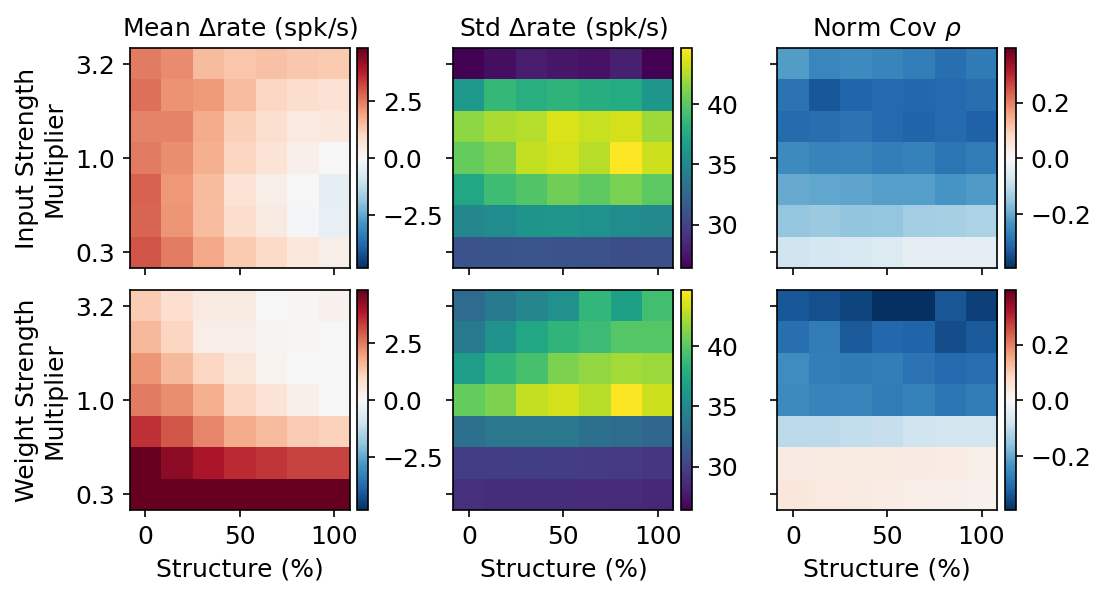

In [576]:
# fig,axs = plt.subplots(2,3,figsize=(2.6*3,2*2),dpi=150,sharey=True,sharex='col')#,width_ratios=[3,3,4])
# fig.subplots_adjust(wspace=0.25,hspace=0.1)

# diff_mean_lim = np.nanmax(np.abs(np.concatenate((rX_vsm_diff_means.flatten(),J_vsm_diff_means[:,1:].flatten()))))
# diff_std_lolim = np.nanmin(np.concatenate((rX_vsm_diff_stds.flatten(),J_vsm_diff_stds.flatten())))
# diff_std_uplim = np.nanmax(np.concatenate((rX_vsm_diff_stds.flatten(),J_vsm_diff_stds.flatten())))
# norm_cov_lim = np.nanmax(np.abs(np.concatenate((rX_vsm_norm_covs.flatten(),J_vsm_norm_covs[:,1:].flatten()))))
# # norm_cov_lim = 0.32

# cbar = imshowbar(fig,axs[0,0],rX_vsm_diff_means.T,origin='lower',cmap='RdBu_r',vmin=-diff_mean_lim,vmax=diff_mean_lim)
# # axs[0,0].imshow(rX_vsm_diff_means,origin='lower',cmap='RdBu_r',vmin=-diff_mean_lim,vmax=diff_mean_lim)
# cbar.ax.tick_params(labelsize=12)
# cbar = imshowbar(fig,axs[0,1],rX_vsm_diff_stds.T,origin='lower',vmin=diff_std_lolim,vmax=diff_std_uplim)
# # axs[1,0].imshow(rX_vsm_diff_stds,origin='lower',vmin=diff_std_lolim,vmax=diff_std_uplim)
# cbar.ax.tick_params(labelsize=12)
# cbar = imshowbar(fig,axs[0,2],rX_vsm_norm_covs.T,origin='lower',cmap='RdBu_r',vmin=-norm_cov_lim,vmax=norm_cov_lim)
# # axs[2,0].imshow(rX_vsm_norm_covs,origin='lower',cmap='RdBu_r',vmin=-norm_cov_lim,vmax=norm_cov_lim)
# cbar.ax.tick_params(labelsize=12)

# cbar = imshowbar(fig,axs[1,0],J_vsm_diff_means.T,origin='lower',cmap='RdBu_r',vmin=-diff_mean_lim,vmax=diff_mean_lim)
# # axs[0,1].imshow(J_vsm_diff_means,origin='lower',cmap='RdBu_r',vmin=-diff_mean_lim,vmax=diff_mean_lim)
# cbar.ax.tick_params(labelsize=12)
# cbar = imshowbar(fig,axs[1,1],J_vsm_diff_stds.T,origin='lower',vmin=diff_std_lolim,vmax=diff_std_uplim)
# # axs[1,1].imshow(J_vsm_diff_stds,origin='lower',vmin=diff_std_lolim,vmax=diff_std_uplim)
# cbar.ax.tick_params(labelsize=12)
# cbar = imshowbar(fig,axs[1,2],J_vsm_norm_covs.T,origin='lower',cmap='RdBu_r',vmin=-norm_cov_lim,vmax=norm_cov_lim)
# # axs[2,1].imshow(J_vsm_norm_covs,origin='lower',cmap='RdBu_r',vmin=-norm_cov_lim,vmax=norm_cov_lim)
# cbar.ax.tick_params(labelsize=12)

# # cbar = imshowbar(fig,axs[0,2],CVL_vsm_diff_means,origin='lower',cmap='RdBu_r',vmin=-diff_mean_lim,vmax=diff_mean_lim)
# # cbar.ax.tick_params(labelsize=12)
# # cbar = imshowbar(fig,axs[1,2],CVL_vsm_diff_stds,origin='lower',vmin=diff_std_lolim,vmax=diff_std_uplim)
# # cbar.ax.tick_params(labelsize=12)
# # cbar = imshowbar(fig,axs[2,2],CVL_vsm_norm_covs,origin='lower',cmap='RdBu_r',vmin=-norm_cov_lim,vmax=norm_cov_lim)
# # cbar.ax.tick_params(labelsize=12)

# axs[0,0].set_ylabel('Input Strength\nMultiplier',fontsize=12)
# axs[1,0].set_ylabel('Weight Strength\nMultiplier',fontsize=12)

# for i in range(2):
#     axs[i,0].set_yticks(np.arange(0,7,3),['{:.1f}'.format(x) for x in 10**(np.arange(0,6+1)/6-0.5)[::3]],
#                         fontsize=12)

# for i in range(3):
#     axs[1,i].set_xticks(np.arange(0,7,3),['{:d}'.format(int(struct*100)) for struct in (np.arange(6+1)/6)[::3]],
#                         fontsize=12)
#     axs[1,i].set_xlabel('Structure (%)',fontsize=12)

# axs[0,0].set_title(r'Mean $\Delta$rate (spk/s)',fontsize=12)
# axs[0,1].set_title(r'Std $\Delta$rate (spk/s)',fontsize=12)
# axs[0,2].set_title(r'Norm Cov $\rho$',fontsize=12)

# # fig.tight_layout()
# fig.savefig('../plots'+'/varied_struct_all.pdf', bbox_inches='tight')

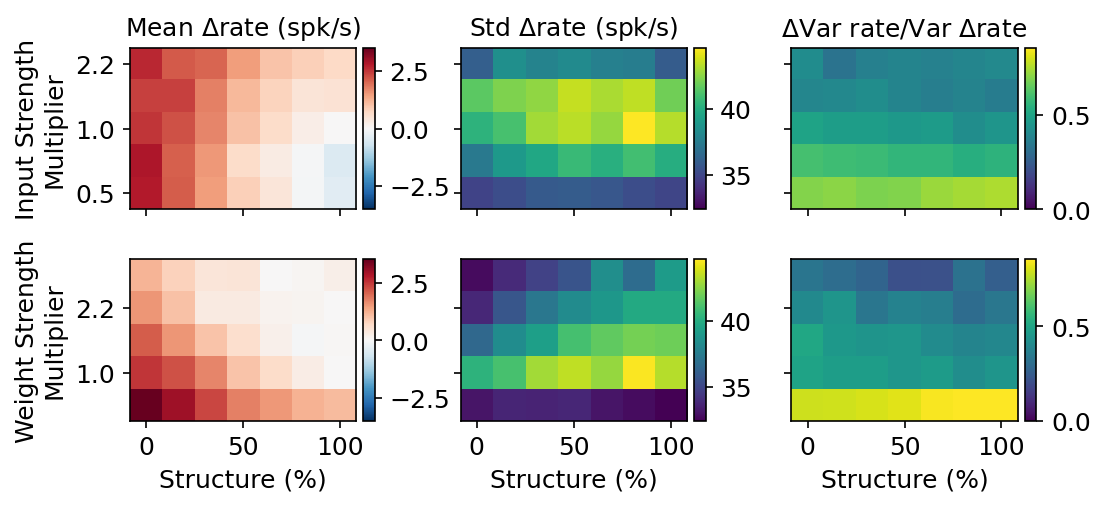

In [620]:
fig,axs = plt.subplots(2,3,figsize=(2.6*3,1.75*2),dpi=150,sharex=True,sharey='row')#,width_ratios=[3,3,4])
fig.subplots_adjust(wspace=0.35,hspace=0.1)

diff_mean_lim = np.nanmax(np.abs(np.concatenate((rX_vsm_diff_means[:,1:-1].flatten(),J_vsm_diff_means[:,2:].flatten()))))
diff_std_lolim = np.nanmin(np.concatenate((rX_vsm_diff_stds[:,1:-1].flatten(),J_vsm_diff_stds[:,2:].flatten())))
diff_std_uplim = np.nanmax(np.concatenate((rX_vsm_diff_stds[:,1:-1].flatten(),J_vsm_diff_stds[:,2:].flatten())))
std_diff_lim = np.nanmax(np.abs(np.concatenate((rX_vsm_std_diffs[:,1:-1].flatten(),J_vsm_std_diffs[:,2:].flatten()))))
# std_diff_lim = 0.32

cbar = imshowbar(fig,axs[0,0],rX_vsm_diff_means[:,1:-1].T,origin='lower',cmap='RdBu_r',vmin=-diff_mean_lim,vmax=diff_mean_lim)
# axs[0,0].imshow(rX_vsm_diff_means,origin='lower',cmap='RdBu_r',vmin=-diff_mean_lim,vmax=diff_mean_lim)
cbar.ax.tick_params(labelsize=12)
cbar = imshowbar(fig,axs[0,1],rX_vsm_diff_stds[:,1:-1].T,origin='lower',vmin=diff_std_lolim,vmax=diff_std_uplim)
# axs[1,0].imshow(rX_vsm_diff_stds,origin='lower',vmin=diff_std_lolim,vmax=diff_std_uplim)
cbar.ax.tick_params(labelsize=12)
cbar = imshowbar(fig,axs[0,2],rX_vsm_std_diffs[:,1:-1].T,origin='lower',vmin=0,vmax=std_diff_lim)
# axs[2,0].imshow(rX_vsm_std_diffs,origin='lower',cmap='RdBu_r',vmin=-std_diff_lim,vmax=std_diff_lim)
cbar.ax.tick_params(labelsize=12)

cbar = imshowbar(fig,axs[1,0],J_vsm_diff_means[:,2:].T,origin='lower',cmap='RdBu_r',vmin=-diff_mean_lim,vmax=diff_mean_lim)
# axs[0,1].imshow(J_vsm_diff_means,origin='lower',cmap='RdBu_r',vmin=-diff_mean_lim,vmax=diff_mean_lim)
cbar.ax.tick_params(labelsize=12)
cbar = imshowbar(fig,axs[1,1],J_vsm_diff_stds[:,2:].T,origin='lower',vmin=diff_std_lolim,vmax=diff_std_uplim)
# axs[1,1].imshow(J_vsm_diff_stds,origin='lower',vmin=diff_std_lolim,vmax=diff_std_uplim)
cbar.ax.tick_params(labelsize=12)
cbar = imshowbar(fig,axs[1,2],J_vsm_std_diffs[:,2:].T,origin='lower',vmin=0,vmax=std_diff_lim)
# axs[2,1].imshow(J_vsm_std_diffs,origin='lower',cmap='RdBu_r',vmin=-std_diff_lim,vmax=std_diff_lim)
cbar.ax.tick_params(labelsize=12)

# cbar = imshowbar(fig,axs[0,2],CVL_vsm_diff_means,origin='lower',cmap='RdBu_r',vmin=-diff_mean_lim,vmax=diff_mean_lim)
# cbar.ax.tick_params(labelsize=12)
# cbar = imshowbar(fig,axs[1,2],CVL_vsm_diff_stds,origin='lower',vmin=diff_std_lolim,vmax=diff_std_uplim)
# cbar.ax.tick_params(labelsize=12)
# cbar = imshowbar(fig,axs[2,2],CVL_vsm_std_diffs,origin='lower',cmap='RdBu_r',vmin=-std_diff_lim,vmax=std_diff_lim)
# cbar.ax.tick_params(labelsize=12)

axs[0,0].set_ylabel('Input Strength\nMultiplier',fontsize=12)
axs[1,0].set_ylabel('Weight Strength\nMultiplier',fontsize=12)

axs[0,0].set_yticks(np.arange(0,5)[::2],['{:.1f}'.format(x) for x in 10**(np.arange(0,6+1)/6-0.5)[1:-1:2]],
                    fontsize=12)
axs[1,0].set_yticks(np.arange(0,5)[1::2],['{:.1f}'.format(x) for x in 10**(np.arange(0,6+1)/6-0.5)[3:-1:2]],
                    fontsize=12)

for i in range(3):
    axs[1,i].set_xticks(np.arange(0,7,3),['{:d}'.format(int(struct*100)) for struct in (np.arange(6+1)/6)[::3]],
                        fontsize=12)
    axs[1,i].set_xlabel('Structure (%)',fontsize=12)

axs[0,0].set_title(r'Mean $\Delta$rate (spk/s)',fontsize=12)
axs[0,1].set_title(r'Std $\Delta$rate (spk/s)',fontsize=12)
# axs[0,2].set_title(r'$\Delta$Std rate',fontsize=12)
axs[0,2].set_title(r'$\Delta$Var rate/Var $\Delta$rate',fontsize=12)

# fig.tight_layout()
fig.savefig('../plots'+'/varied_struct_all.pdf', bbox_inches='tight')

# Plot Normalization Results

/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_23801/3899757098.py:61: RuntimeWarning: invalid value encountered in divide
  axs[1,0].plot(cons,np.concatenate(([1,],((peak2-base)/(peak1-base))[1:])),c=['k','m'][i],ls='-',alpha=0.7)


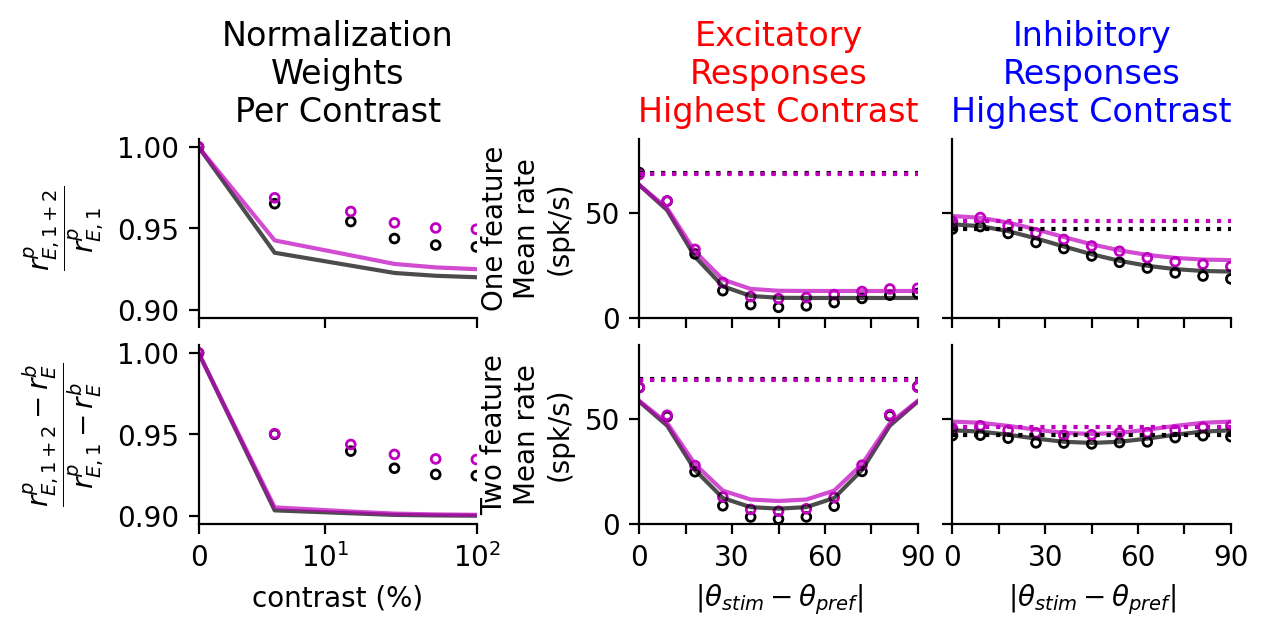

In [408]:
# with open('./data_moments'+'.pkl', 'rb') as handle:
#     data_preds = np.transpose(pickle.load(handle)[1],(1,0,2))
# with open('./data_contrasts'+'.pkl', 'rb') as handle:
#     cons = pickle.load(handle)[1]
    
# nori = 20

# oris = np.arange(nori//2+1) * 90/(nori/2)
# def abs_ori(A):
#     return 0.5*(A[:nori//2+1] + np.concatenate((A[0:1],A[-1:nori//2-1:-1])))

# cidx = 5

# fig,axs = plt.subplots(2,4,figsize=(2*3.33,1.25*2),dpi=200,sharex='col',sharey='col',width_ratios=[3,1,3,3])
# fig.subplots_adjust(hspace=0.15,wspace=0.15)

# axs[0,1].set_axis_off()
# axs[1,1].set_axis_off()
# axs[0,3].yaxis.set_tick_params(which='both',labelleft=False)
# axs[1,3].yaxis.set_tick_params(which='both',labelleft=False)

# axs[0,2].plot(oris,abs_ori(dmft_μrEs[cidx,0,:]),c='k',ls='-',alpha=0.7)
# axs[0,2].scatter(oris,abs_ori(sim_μrEs[cidx,0,:]),
#     edgecolors='k',facecolors='none',marker='o',s=10)
# axs[0,2].plot(oris,abs_ori(dmft_μrEs[cidx,1,:]),c='m',ls='-',alpha=0.7)
# axs[0,2].scatter(oris,abs_ori(sim_μrEs[cidx,1,:]),
#     edgecolors='m',facecolors='none',marker='o',s=10)

# axs[0,3].plot(oris,abs_ori(dmft_μrIs[cidx,0,:]),c='k',ls='-',alpha=0.7)
# axs[0,3].scatter(oris,abs_ori(sim_μrIs[cidx,0,:]),
#     edgecolors='k',facecolors='none',marker='o',s=10)
# axs[0,3].plot(oris,abs_ori(dmft_μrIs[cidx,1,:]),c='m',ls='-',alpha=0.7)
# axs[0,3].scatter(oris,abs_ori(sim_μrIs[cidx,1,:]),
#     edgecolors='m',facecolors='none',marker='o',s=10)

# axs[1,2].plot(oris,abs_ori(dmft_norm_μrEs[cidx,0,:]),c='k',ls='-',alpha=0.7)
# axs[1,2].scatter(oris,abs_ori(sim_norm_μrEs[cidx,0,:]),
#     edgecolors='k',facecolors='none',marker='o',s=10)
# axs[1,2].plot(oris,abs_ori(dmft_norm_μrEs[cidx,1,:]),c='m',ls='-',alpha=0.7)
# axs[1,2].scatter(oris,abs_ori(sim_norm_μrEs[cidx,1,:]),
#     edgecolors='m',facecolors='none',marker='o',s=10)

# axs[1,3].plot(oris,abs_ori(dmft_norm_μrIs[cidx,0,:]),c='k',ls='-',alpha=0.7)
# axs[1,3].scatter(oris,abs_ori(sim_norm_μrIs[cidx,0,:]),
#     edgecolors='k',facecolors='none',marker='o',s=10)
# axs[1,3].plot(oris,abs_ori(dmft_norm_μrIs[cidx,1,:]),c='m',ls='-',alpha=0.7)
# axs[1,3].scatter(oris,abs_ori(sim_norm_μrIs[cidx,1,:]),
#     edgecolors='m',facecolors='none',marker='o',s=10)

# for i in range(2):
#     axs[i,2].axhline(sim_μrEs[cidx,0,0],c='k',ls=':')
#     axs[i,2].axhline(sim_μrEs[cidx,1,0],c='m',ls=':')
#     axs[i,3].axhline(sim_μrIs[cidx,0,0],c='k',ls=':')
#     axs[i,3].axhline(sim_μrIs[cidx,1,0],c='m',ls=':')
    
# for i,opto in enumerate(np.arange(2)):
#     base = np.mean(dmft_μrEs[0,i,:])
#     peak1 = dmft_μrEs[:,i,0]
#     peak2 = dmft_norm_μrEs[:,i,0]
#     axs[0,0].plot(cons,peak2/peak1,c=['k','m'][i],ls='-',alpha=0.7)
#     axs[1,0].plot(cons,np.concatenate(([1,],((peak2-base)/(peak1-base))[1:])),c=['k','m'][i],ls='-',alpha=0.7)
#     base = np.mean(sim_μrEs[0,i,:])
#     peak1 = sim_μrEs[:,i,0]
#     peak2 = sim_norm_μrEs[:,i,0]
#     axs[0,0].scatter(cons,peak2/peak1,edgecolors=['k','m'][i],
#                 facecolors='none',marker='o',s=10,
#                 label=['Vis Only','Vis+Opto'][i])
#     axs[1,0].scatter(cons,(peak2-base)/(peak1-base),edgecolors=['k','m'][i],
#                 facecolors='none',marker='o',s=10,
#                 label=['Vis Only','Vis+Opto'][i])
    
# # axs[0,0].legend()
# # axs[1,0].legend()
# # axs[2,0].legend()

# for ax in axs.flat:
#     ax.spines[['right', 'top']].set_visible(False)

# axs[0,0].set_xscale('symlog', linthresh=12)
# nticks = 7
# ticks = np.array(['{:.0f}'.format(ori) for ori in np.linspace(0,90,nticks)])
# ticks[1::2] = ''
# for i in range(2,4):
#     axs[0,i].set_xticks(np.linspace(0,90,7),ticks)

# axs[0,0].set_xlim(0,100)
# axs[0,2].set_xlim(0,90)
# axs[0,3].set_xlim(0,90)
# # axs[0,0].set_ylim(None,1)
# for i in range(2,4):
#     axs[0,i].set_ylim(0,85)
#     axs[1,i].set_ylim(0,85)

# axs[1,0].set_xlabel('contrast (%)')
# axs[1,2].set_xlabel(r'$|\theta_{stim}-\theta_{pref}|$')
# axs[1,3].set_xlabel(r'$|\theta_{stim}-\theta_{pref}|$')

# axs[0,0].set_ylabel(r'$\dfrac{r^p_{E,1+2}}{r^p_{E,1}}$')
# axs[1,0].set_ylabel(r'$\dfrac{r^p_{E,1+2}-r^b_E}{r^p_{E,1}-r^b_E}$')
# axs[0,2].set_ylabel('One feature\nMean rate\n(spk/s)')
# axs[1,2].set_ylabel('Two feature\nMean rate\n(spk/s)')

# axs[0,0].set_title('Normalization\nWeights\nPer Contrast',color='k')
# axs[0,2].set_title('Excitatory\nResponses\nHighest Contrast',color='r')
# axs[0,3].set_title('Inhibitory\nResponses\nHighest Contrast',color='b')

# # fig.tight_layout()
# fig.savefig('./../plots/opto_norm_sim_vs_dmft.pdf')

/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_23801/3543969913.py:61: RuntimeWarning: invalid value encountered in divide
  axs[1,0].plot(cons,np.concatenate(([1,],((peak2-base)/(peak1-base))[1:])),c=['k','m'][i],ls='-',alpha=0.7)


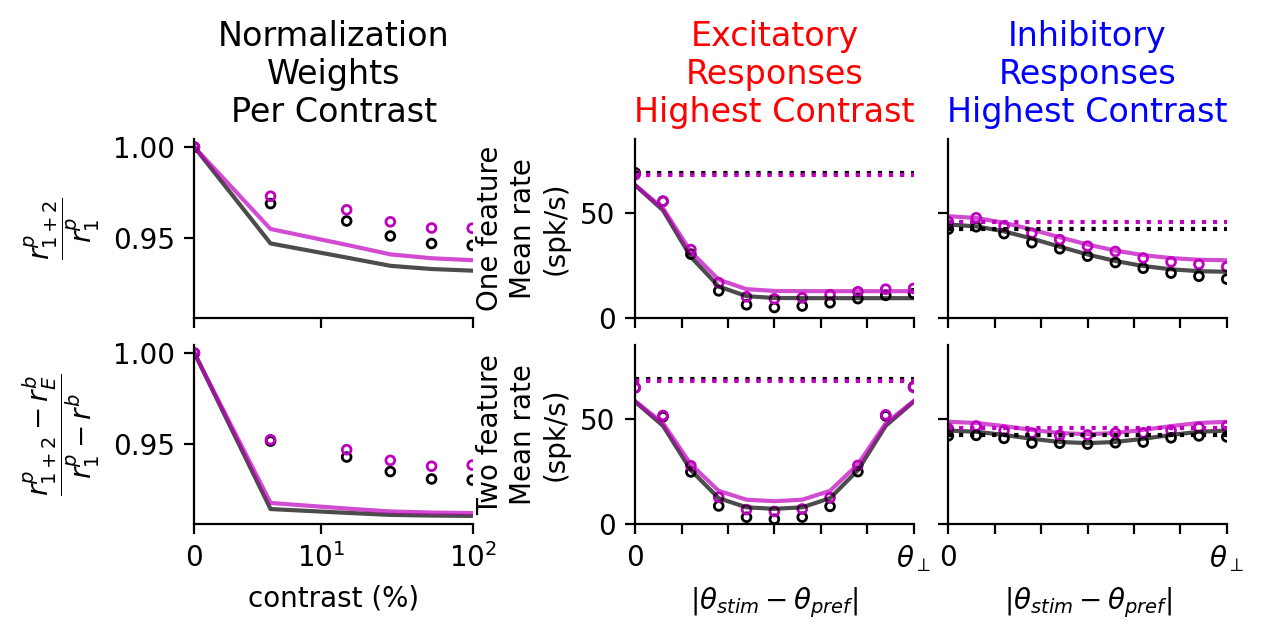

In [456]:
# with open('./data_moments'+'.pkl', 'rb') as handle:
#     data_preds = np.transpose(pickle.load(handle)[1],(1,0,2))
# with open('./data_contrasts'+'.pkl', 'rb') as handle:
#     cons = pickle.load(handle)[1]
    
# nori = 20

# oris = np.arange(nori//2+1) * 90/(nori/2)
# def abs_ori(A):
#     return 0.5*(A[:nori//2+1] + np.concatenate((A[0:1],A[-1:nori//2-1:-1])))

# cidx = 5

# fig,axs = plt.subplots(2,4,figsize=(2*3.33,1.25*2),dpi=200,sharex='col',sharey='col',width_ratios=[3,1,3,3])
# fig.subplots_adjust(hspace=0.15,wspace=0.15)

# axs[0,1].set_axis_off()
# axs[1,1].set_axis_off()
# axs[0,3].yaxis.set_tick_params(which='both',labelleft=False)
# axs[1,3].yaxis.set_tick_params(which='both',labelleft=False)

# axs[0,2].plot(oris,abs_ori(dmft_μrEs[cidx,0,:]),c='k',ls='-',alpha=0.7)
# axs[0,2].scatter(oris,abs_ori(sim_μrEs[cidx,0,:]),
#     edgecolors='k',facecolors='none',marker='o',s=10)
# axs[0,2].plot(oris,abs_ori(dmft_μrEs[cidx,1,:]),c='m',ls='-',alpha=0.7)
# axs[0,2].scatter(oris,abs_ori(sim_μrEs[cidx,1,:]),
#     edgecolors='m',facecolors='none',marker='o',s=10)

# axs[0,3].plot(oris,abs_ori(dmft_μrIs[cidx,0,:]),c='k',ls='-',alpha=0.7)
# axs[0,3].scatter(oris,abs_ori(sim_μrIs[cidx,0,:]),
#     edgecolors='k',facecolors='none',marker='o',s=10)
# axs[0,3].plot(oris,abs_ori(dmft_μrIs[cidx,1,:]),c='m',ls='-',alpha=0.7)
# axs[0,3].scatter(oris,abs_ori(sim_μrIs[cidx,1,:]),
#     edgecolors='m',facecolors='none',marker='o',s=10)

# axs[1,2].plot(oris,abs_ori(dmft_norm_μrEs[cidx,0,:]),c='k',ls='-',alpha=0.7)
# axs[1,2].scatter(oris,abs_ori(sim_norm_μrEs[cidx,0,:]),
#     edgecolors='k',facecolors='none',marker='o',s=10)
# axs[1,2].plot(oris,abs_ori(dmft_norm_μrEs[cidx,1,:]),c='m',ls='-',alpha=0.7)
# axs[1,2].scatter(oris,abs_ori(sim_norm_μrEs[cidx,1,:]),
#     edgecolors='m',facecolors='none',marker='o',s=10)

# axs[1,3].plot(oris,abs_ori(dmft_norm_μrIs[cidx,0,:]),c='k',ls='-',alpha=0.7)
# axs[1,3].scatter(oris,abs_ori(sim_norm_μrIs[cidx,0,:]),
#     edgecolors='k',facecolors='none',marker='o',s=10)
# axs[1,3].plot(oris,abs_ori(dmft_norm_μrIs[cidx,1,:]),c='m',ls='-',alpha=0.7)
# axs[1,3].scatter(oris,abs_ori(sim_norm_μrIs[cidx,1,:]),
#     edgecolors='m',facecolors='none',marker='o',s=10)

# for i in range(2):
#     axs[i,2].axhline(sim_μrEs[cidx,0,0],c='k',ls=':')
#     axs[i,2].axhline(sim_μrEs[cidx,1,0],c='m',ls=':')
#     axs[i,3].axhline(sim_μrIs[cidx,0,0],c='k',ls=':')
#     axs[i,3].axhline(sim_μrIs[cidx,1,0],c='m',ls=':')
    
# for i,opto in enumerate(np.arange(2)):
#     base = 0.8*np.mean(dmft_μrEs[0,i,:])+0.2*np.mean(dmft_μrIs[0,i,:])
#     peak1 = 0.8*dmft_μrEs[:,i,0]+0.2*dmft_μrIs[:,i,0]
#     peak2 = 0.8*dmft_norm_μrEs[:,i,0]+0.2*dmft_norm_μrIs[:,i,0]
#     axs[0,0].plot(cons,peak2/peak1,c=['k','m'][i],ls='-',alpha=0.7)
#     axs[1,0].plot(cons,np.concatenate(([1,],((peak2-base)/(peak1-base))[1:])),c=['k','m'][i],ls='-',alpha=0.7)
#     base = 0.8*np.mean(sim_μrEs[0,i,:])+0.2*np.mean(sim_μrIs[0,i,:])
#     peak1 = 0.8*sim_μrEs[:,i,0]+0.2*sim_μrIs[:,i,0]
#     peak2 = 0.8*sim_norm_μrEs[:,i,0]+0.2*sim_norm_μrIs[:,i,0]
#     axs[0,0].scatter(cons,peak2/peak1,edgecolors=['k','m'][i],
#                 facecolors='none',marker='o',s=10,
#                 label=['Vis Only','Vis+Opto'][i])
#     axs[1,0].scatter(cons,(peak2-base)/(peak1-base),edgecolors=['k','m'][i],
#                 facecolors='none',marker='o',s=10,
#                 label=['Vis Only','Vis+Opto'][i])
    
# # axs[0,0].legend()
# # axs[1,0].legend()
# # axs[2,0].legend()

# for ax in axs.flat:
#     ax.spines[['right', 'top']].set_visible(False)
    

# axs[0,0].set_xscale('symlog', linthresh=12)
# nticks = 7
# # ticks = np.array(['{:.0f}'.format(ori) for ori in np.linspace(0,90,nticks)])
# # ticks[1::2] = ''
# ticks = np.concatenate(([r'0'],np.array([r'',]*(nticks-2)),[r'$\theta_\perp$']))
# for i in range(2,4):
#     axs[0,i].set_xticks(ticks=np.linspace(0,90,nticks),labels=ticks)

# axs[0,0].set_xlim(0,100)
# axs[0,2].set_xlim(0,90)
# axs[0,3].set_xlim(0,90)
# # axs[0,0].set_ylim(None,1)
# for i in range(2,4):
#     axs[0,i].set_ylim(0,85)
#     axs[1,i].set_ylim(0,85)

# axs[1,0].set_xlabel('contrast (%)')
# axs[1,2].set_xlabel(r'$|\theta_{stim}-\theta_{pref}|$')
# axs[1,3].set_xlabel(r'$|\theta_{stim}-\theta_{pref}|$')

# axs[0,0].set_ylabel(r'$\dfrac{r^p_{1+2}}{r^p_{1}}$')
# axs[1,0].set_ylabel(r'$\dfrac{r^p_{1+2}-r^b_E}{r^p_{1}-r^b}$')
# axs[0,2].set_ylabel('One feature\nMean rate\n(spk/s)')
# axs[1,2].set_ylabel('Two feature\nMean rate\n(spk/s)')

# axs[0,0].set_title('Normalization\nWeights\nPer Contrast',color='k')
# axs[0,2].set_title('Excitatory\nResponses\nHighest Contrast',color='r')
# axs[0,3].set_title('Inhibitory\nResponses\nHighest Contrast',color='b')

# # fig.tight_layout()
# fig.savefig('./../plots/opto_norm_sim_vs_dmft.pdf')

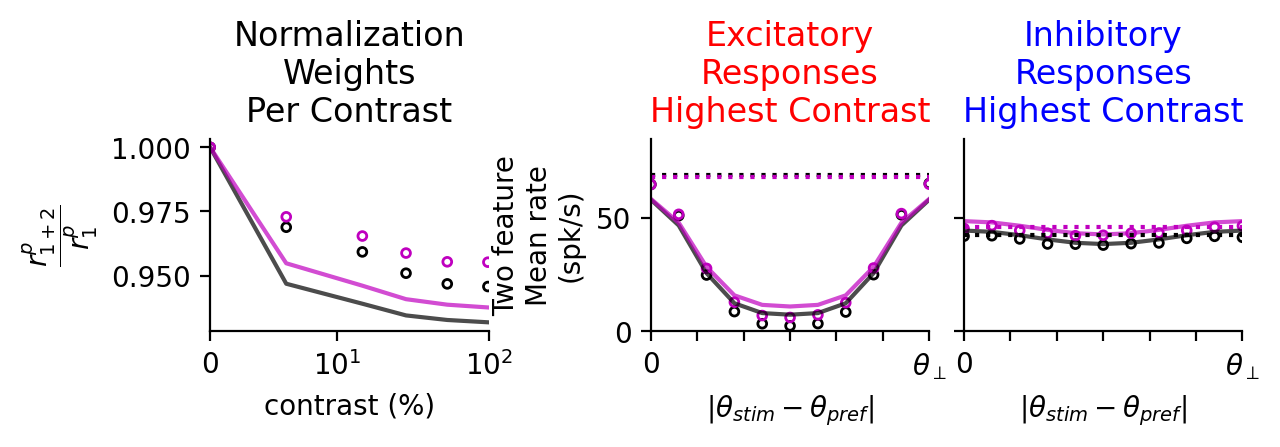

In [465]:
with open('./data_moments'+'.pkl', 'rb') as handle:
    data_preds = np.transpose(pickle.load(handle)[1],(1,0,2))
with open('./data_contrasts'+'.pkl', 'rb') as handle:
    cons = pickle.load(handle)[1]
    
nori = 20

oris = np.arange(nori//2+1) * 90/(nori/2)
def abs_ori(A):
    return 0.5*(A[:nori//2+1] + np.concatenate((A[0:1],A[-1:nori//2-1:-1])))

cidx = 5

fig,axs = plt.subplots(1,4,figsize=(2*3.33,1.25*1),dpi=200,sharex='col',sharey='col',width_ratios=[3,1,3,3])
fig.subplots_adjust(hspace=0.15,wspace=0.15)

axs[1].set_axis_off()
axs[3].yaxis.set_tick_params(which='both',labelleft=False)

axs[2].plot(oris,abs_ori(dmft_norm_μrEs[cidx,0,:]),c='k',ls='-',alpha=0.7)
axs[2].scatter(oris,abs_ori(sim_norm_μrEs[cidx,0,:]),
    edgecolors='k',facecolors='none',marker='o',s=10)
axs[2].plot(oris,abs_ori(dmft_norm_μrEs[cidx,1,:]),c='m',ls='-',alpha=0.7)
axs[2].scatter(oris,abs_ori(sim_norm_μrEs[cidx,1,:]),
    edgecolors='m',facecolors='none',marker='o',s=10)

axs[3].plot(oris,abs_ori(dmft_norm_μrIs[cidx,0,:]),c='k',ls='-',alpha=0.7)
axs[3].scatter(oris,abs_ori(sim_norm_μrIs[cidx,0,:]),
    edgecolors='k',facecolors='none',marker='o',s=10)
axs[3].plot(oris,abs_ori(dmft_norm_μrIs[cidx,1,:]),c='m',ls='-',alpha=0.7)
axs[3].scatter(oris,abs_ori(sim_norm_μrIs[cidx,1,:]),
    edgecolors='m',facecolors='none',marker='o',s=10)

axs[2].axhline(sim_μrEs[cidx,0,0],c='k',ls=':')
axs[2].axhline(sim_μrEs[cidx,1,0],c='m',ls=':')
axs[3].axhline(sim_μrIs[cidx,0,0],c='k',ls=':')
axs[3].axhline(sim_μrIs[cidx,1,0],c='m',ls=':')
    
for i,opto in enumerate(np.arange(2)):
    base = 0.8*np.mean(dmft_μrEs[0,i,:])+0.2*np.mean(dmft_μrIs[0,i,:])
    peak1 = 0.8*dmft_μrEs[:,i,0]+0.2*dmft_μrIs[:,i,0]
    peak2 = 0.8*dmft_norm_μrEs[:,i,0]+0.2*dmft_norm_μrIs[:,i,0]
    axs[0].plot(cons,peak2/peak1,c=['k','m'][i],ls='-',alpha=0.7)
    base = 0.8*np.mean(sim_μrEs[0,i,:])+0.2*np.mean(sim_μrIs[0,i,:])
    peak1 = 0.8*sim_μrEs[:,i,0]+0.2*sim_μrIs[:,i,0]
    peak2 = 0.8*sim_norm_μrEs[:,i,0]+0.2*sim_norm_μrIs[:,i,0]
    axs[0].scatter(cons,peak2/peak1,edgecolors=['k','m'][i],
                facecolors='none',marker='o',s=10,
                label=['Vis Only','Vis+Opto'][i])
    
# axs[0,0].legend()
# axs[1,0].legend()
# axs[2,0].legend()

for ax in axs.flat:
    ax.spines[['right', 'top']].set_visible(False)
    

axs[0].set_xscale('symlog', linthresh=12)
nticks = 7
# ticks = np.array(['{:.0f}'.format(ori) for ori in np.linspace(0,90,nticks)])
# ticks[1::2] = ''
ticks = np.concatenate(([r'0'],np.array([r'',]*(nticks-2)),[r'$\theta_\perp$']))
for i in range(2,4):
    axs[i].set_xticks(ticks=np.linspace(0,90,nticks),labels=ticks)

axs[0].set_xlim(0,100)
axs[2].set_xlim(0,90)
axs[3].set_xlim(0,90)
# axs[0,0].set_ylim(None,1)
for i in range(2,4):
    axs[i].set_ylim(0,85)

axs[0].set_xlabel('contrast (%)')
axs[2].set_xlabel(r'$|\theta_{stim}-\theta_{pref}|$')
axs[3].set_xlabel(r'$|\theta_{stim}-\theta_{pref}|$')

axs[0].set_ylabel(r'$\dfrac{r^p_{1+2}}{r^p_{1}}$')
axs[2].set_ylabel('Two feature\nMean rate\n(spk/s)')

axs[0].set_title('Normalization\nWeights\nPer Contrast',color='k')
axs[2].set_title('Excitatory\nResponses\nHighest Contrast',color='r')
axs[3].set_title('Inhibitory\nResponses\nHighest Contrast',color='b')

# fig.tight_layout()
fig.savefig('./../plots/opto_norm_sim_vs_dmft.pdf')

# Investigate Weight Scaling to Improve Reshuffling

In [339]:
with open('./../results/best_fit.pkl','rb') as\
        handle:
    res_dict = pickle.load(handle)
sim_prms = res_dict['prms']
sim_aXs = res_dict['best_monk_aXs']
sim_bX = res_dict['best_monk_bX']

R = np.vstack([sim_μrEs[:,0,0],sim_μrIs[:,0,0]])

W = sim_prms['J']*np.array([[1,-sim_prms['gE']],[1./sim_prms['beta'],-sim_prms['gI']/sim_prms['beta']]])
H = (sim_bX+sim_aXs[None,:])*sim_prms['K']*sim_prms['J']*np.array([sim_prms['hE'],sim_prms['hI']/sim_prms['beta']])[:,None]

new_prms = sim_prms.copy()
new_prms['J'] *= 1.0
new_prms['beta'] *= 1.0
new_prms['gE'] *= 1.1
new_prms['hE'] *= 1.00

newW = new_prms['J']*np.array([[1,-new_prms['gE']],[1./new_prms['beta'],-new_prms['gI']/new_prms['beta']]])
newH = (sim_bX+sim_aXs[None,:])*new_prms['K']*new_prms['J']*np.array([new_prms['hE'],new_prms['hI']/new_prms['beta']])[:,None]

In [341]:
print(sim_prms)
print(new_prms)
print()
print(np.linalg.det(W))
print(np.linalg.det(newW))

{'K': 500, 'SoriE': 38.63562027289319, 'SoriI': 34.275028486642775, 'SoriF': 26.323950517631808, 'J': 0.00013491946819766635, 'beta': 0.1697620063721225, 'gE': 8.092185620858125, 'gI': 4.769591405676211, 'hE': 5.31001329301364, 'hI': 0.7349604313831126, 'L': 3.2502453755535385, 'CVL': 14.45213578396271}
{'K': 500, 'SoriE': 38.63562027289319, 'SoriI': 34.275028486642775, 'SoriF': 26.323950517631808, 'J': 0.00013491946819766635, 'beta': 0.1697620063721225, 'gE': 8.901404182943939, 'gI': 4.769591405676211, 'hE': 5.31001329301364, 'hI': 0.7349604313831126, 'L': 3.2502453755535385, 'CVL': 14.45213578396271}

3.5627557247535467e-07
4.4304656760544187e-07


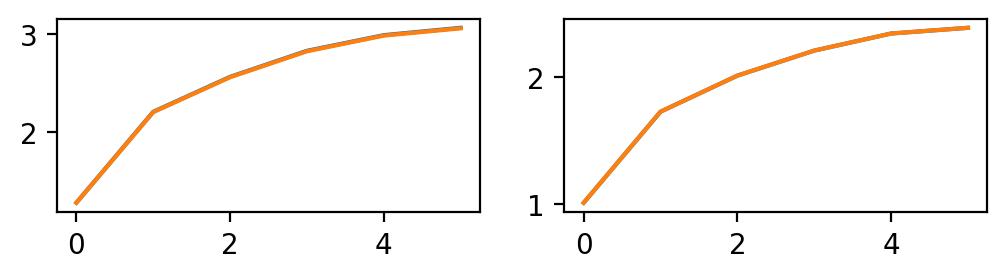

In [278]:
fig,axs = plt.subplots(1,2,figsize=(2*3,1.25*1),dpi=200)

for i in range(2):
    axs[i].plot((W@R+H)[i])
    axs[i].plot((newW@R+newH)[i])